# Прогнозирование стоимости автомобиля по характеристикам

### Описание признаков в тестовом датасете:

bodyType - тип кузова,
brand - марка автомобиля,
car_url - адрес страницы с объявлением,
color - цвет автомобиля,
complectation_dict - словарь с параметрами комплектации авто,
description - описание автомобиля,
engineDisplacement - объем двигателя,
enginePower - мощность двигателя,
equipment_dict - словарь оснащения авто,
fuelType - тип топлива,
image - изображение,
mileage - пробег,
modelDate - дата выпуска модели,
model_info - информация о модели,
model_name - название модели,
name - имя,
numberOfDoors - кол-во дверей,
parsing_unixtime - когда был произведен парсинг данных,
priceCurrency - валюта,
productionDate - год производства,
sell_id,
super_gen - словарь с дополинтельной информацией,
vehicleConfiguration - конфигурация транспортного средства,
vehicleTransmission - трансмиссия,
vendor - регион изготовления,
Владельцы - кол-во владельцев,
Владение - период владения,
ПТС,
Привод,
Руль,
Состояние,
Таможня

## Парсинг.
В результате парсинга данных результат оказался неудовлетворительным. С учетом отсутствия достаточного количества времени принял решение воспользоваться набором данных с Kaggle.

In [1]:
# использовалась при работе в Colabe Notebooks
# used when working at Colabe Notebooks
#from google.colab import drive

## Импорт библиотек

In [2]:
import numpy as np
import pandas as pd
import sys
import re
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import time
import xgboost as xgb

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from pandas_profiling import ProfileReport
from scipy.stats import ttest_ind
from itertools import combinations
from tqdm.notebook import tqdm
from catboost import CatBoostRegressor
import xgboost as xgb
from sklearn.base import clone

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, RobustScaler, MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_selection import f_regression, mutual_info_regression
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, BaggingRegressor
from sklearn.ensemble import StackingRegressor

%matplotlib inline
warnings.simplefilter('ignore')
sns.set()

In [3]:
# использовалась при работе в Colabe Notebooks
# used when working at Colabe Notebooks
#drive.mount('/drive')

In [4]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

In [5]:
# зафиксируем RANDOM_SEED, чтобы эксперименты были воспроизводимы:
RANDOM_SEED = 42

## Пользовательские функции.

In [6]:
def mape(y_true, y_pred):
    """
    Функция возвращает метрику MAPE.
    На вход получает массив реальных и предсказанных значений y.
    """
    return np.mean(np.abs((y_pred-y_true)/y_true))

In [7]:
def months_to_sent(months):
    """
    Функция, которая принимает на вход количество месяцев, а возвращает строку в формате "x  месяц(-а -ев)"
    """
    if months == 1:
        return f'{months} месяц'
    elif 2 <= months <= 4:
        return f'{months} месяца'
    return f'{months} месяцев'


def years_to_sent(years):
    """
    Функция, которая принимает на вход количество лет, а возвращает строку в формате "x  лет/год/года"
    """
    if 11 <= years <= 14 or 5 <= years % 10 <= 9 or years % 10 == 0:
        return f'{years} лет'
    elif years % 10 == 1:
        return f'{years} год'
    elif 2 <= years % 10 <= 4:
        return f'{years} годa'


def tenure(row):
    """
    Функция, которая приводит содержимое ячейки "Владение" в train к тому же виду, как в test.
    Вход: строка series (строка колонки).
    Выход: возвращает вместо словаря информацию в виде "x лет y месяцев"
    """
    row = re.findall('\d+', str(row))  # находим все целые числа в строке
    if row != []:
        years = 2020 - (int(row[0])+1)  # 2020, т.к. данные собраны в 2020 году
        months = 2 + (12 - int(row[1]))
        if years < 0:
            return months_to_sent(int(row[1]))
        elif years == 0 and months < 12:
            return months_to_sent(months)
        elif years >= 0 and months == 12:
            return years_to_sent(years + 1)
        elif years >= 0 and months > 12:
            return years_to_sent(years + 1)+' и '+months_to_sent(months - 12)
        elif years > 0 and months < 12:
            return years_to_sent(years)+' и '+months_to_sent(months)
        return None

In [8]:
def convert_engineDisplacement_to_float(row):
    """
    Функция, которая принимает строку, содержащую информацию про объеме двигателя, находит числовое значение (через точку, например 2.0),
    возвращает значение литров во float формате.
    """
    row = str(row)
    volume = re.findall('\d\.\d', row)
    if volume == []:
        return None
    return float(volume[0])

In [9]:
def intitial_eda_checks(df, missing_percent):
    '''
    Функция принимает на вход датафрейм, а также заданный порог % пустых значений, который хотим обработать. 
    На выход выводит на экран информацию о сумме пустых значений для всех колонок, а также проце
    '''
    if df.isnull().sum().sum() > 0:
        mask_total = df.isnull().sum().sort_values(ascending=False)
        total = mask_total[mask_total > 0]

        mask_percent = df.isnull().mean().sort_values(ascending=False)
        percent = mask_percent[mask_percent > 0]

        series = mask_percent[mask_percent > missing_percent]
        columns = series.index.to_list()

        missing_data = pd.DataFrame(pd.concat(
            [total, round(percent*100, 2)], axis=1, keys=['Количество', '%']))
        print('Сумма и процент значений NaN:\n \n')
        display(missing_data)
    else:
        print('NaN значения не найдены.')

In [10]:
def num_of_months(row):
    """
    Функция перевеодит формат данных "x лет y месяца(ев)" в количество месяцев.
    
    Вход: строка series.
    Выход: количество месяцев.
    """
    if pd.notnull(row) and row != 'no_data':
        list_ownership = row.split()  # разделяем строку на список из месяца и лет
        if len(list_ownership) == 2:  # если содержится информация только про годы
            if list_ownership[1] in ['год', 'года', 'лет']:
                return int(list_ownership[0])*12
            return int(list_ownership[0])  # переводим год в месяцы
        # случай, когда содержится инфо только про месяц
        # прибавляем к годам*12 количетсво месяцев
        return int(list_ownership[0])*12 + int(list_ownership[3])

In [11]:
def get_boxplot(column):
    """
    Функция для отрисовки коробочной диаграммы для нечисловых признаков.
    
    На вход получаем колоноку, для которой строим график.
    График отрисовываем относительно целевой переменной pricing, ограниченной по квантилю.
    """
    fig, ax = plt.subplots(figsize=(25, 5))
    plt.subplots_adjust(wspace=0.5)
    sns.boxplot(x=column, y='price',
                data=data[data['train'] == 1],
                ax=ax)
    plt.xticks(rotation=45)
    # поскольку в price много выбросов, огриничимся 75% квантилем
    ax.set_ylim(0, (data.price.quantile(0.75) + 8 *
                    (data.price.quantile(0.75) - data.price.quantile(0.25))))
    ax.set_title('Boxplot для ' + column)
    plt.show()

In [12]:
def analyze_cat_cols(col):
    """
    Функция для анализа категориального признака.
    
    На вход получаем колонку, для которой проводим анализ.
    
    В результате выводи графики:
        1. Распределение количества объявлений по признаку.
            Дополнительно, выводится график (прямая) возможного среднего количетсва объявлений по всем категориям признака, чтобы сравнить, насколько
            отклоняется от среднего та или иная категория признака.
        2. График боксплот для признака/целевой переменной (цены).
    """
    fig, axes = plt.subplots(figsize=(25, 5))
    # Посчитаем среднее значение количества объявлений по всем категориям признака
    mean = data[col].value_counts().values.mean()
    x = data[col].unique()
    # Построим графики по признаку и для среднего
    sns.histplot(data=data, x=data[col],
                 stat='count', bins=data[col].nunique())
    axes.plot(x, [mean for i in x], '--', color='r')
    plt.xticks(rotation=45)
    plt.title('Распределение количества объясвлений по '+col)
    plt.show()
    
    # Строим боксплот
    get_boxplot(col)

In [13]:
def km_per_year(row):
    """
    Функция делает пересчет км пробега автомобиля в год. 
    Для расчета количества лет использование берется год производства автомобиля.
    
    Вход: строка датафрейма.
    Выход: информация о км/год.
    """
    if row['mileage'] != 0:
        # обрабатываем случаи, когда мошина произведена в год сбора данных, чтоб не делить на 0
        if row['parsing_date'].year - row['productionDate'] == 0:
            return row['mileage']
        else:
            return row['mileage']/(row['parsing_date'].year - row['productionDate'])
    return 0  # возвращаем 0, если машина без пробега (новая)

In [14]:
def prod_date_range(row, year_lim):
    """
    Функция для создания столбца с информацией, старше ли авто, чем year_lim.
    Вход: строка, установленный лимит.
    Выход: 
        1 - если авто старше
        0 - если нет.
    """
    if (row['parsing_date'].year-row['productionDate']) >= year_lim:
        return 1
    return 0

In [15]:
def iqr_analysis(series, mode=False):
    """
    Функция выводит инфорамцию о границах выборосов для признака.
    Если mode = True, возвращается верхняя и нижняя границы выбросов. Иначе, просто выводится информация на экран.
    """
    IQR = series.quantile(0.75) - series.quantile(0.25)
    perc25 = series.quantile(0.25)
    perc75 = series.quantile(0.75)

    f = perc25 - 1.5*IQR
    l = perc75 + 1.5*IQR

    if mode:
        return f, l

    print(
        "\n25-й перцентиль: {},".format(perc25),
        "\n75-й перцентиль: {},".format(perc75),
        "\nIQR: {}, ".format(IQR),
        "\nГраницы выбросов: [{f}, {l}].".format(
            f=perc25 - 1.5*IQR, l=perc75 + 1.5*IQR),
        "\n\nМинимальное значение признака: {}.".format(series.min()),
        "\nМаксимальное значение признака: {} .\n".format(series.max()))

    if series.min() < f:
        print("Найдены выбросы по нижней границе признака! Количество: {}, {}%".format(series.where(
            series < f).count(), round(series.where(series < f).count()/series.count()*100, 2)))
    if series.max() > l:
        print("Найдены выбросы по верхней границе признака! Количество: {}, {}%".format(series.where(
            series > l).count(), round(series.where(series > l).count()/series.count()*100, 2)))

In [16]:
def get_stat_dif(column):
    """ 
    Поиск статистически значимых различий для колонки с помощью теста Стьюдента.
    """
    cols = data.loc[:, column].value_counts().index[:]
    combinations_all = list(combinations(cols, 2))

    tmp = data[data['train'] == 1]

    for comb in combinations_all:
        if ttest_ind(tmp.loc[data[data['train'] == 1].loc[:, column] == comb[0], 'price'],
                     tmp.loc[data[data['train'] == 1].loc[:, column] == comb[1], 'price']).pvalue <= 0.05/len(combinations_all):  # учли поправку Бонферони
            # print('Найдены статистически значимые различия для колонки и комбинаций', column, comb)
            pass
        else:
            print(
                'Не найдены статистически значимые различия для колонки и комбинации', column, comb)
            return column
            break

In [17]:
def regularise(X_train, y_train):
    """ 
    Подбор параметров GradientBoosting.
    """
    max_depth = [5, 10, 15]
    n_estimators = [100, 200,1000]
    hyperparameters = dict(max_depth=max_depth, n_estimators=n_estimators)
    model = GradientBoostingRegressor()
    model.fit(X_train, y_train)

    clf = GridSearchCV(model, hyperparameters)

    best_model = clf.fit(X_train, y_train)

    best_max_depth = best_model.best_estimator_.get_params()['max_depth']
    best_n_estimators = best_model.best_estimator_.get_params()['n_estimators']

    return best_max_depth, best_n_estimators

In [18]:
def compute_meta_feature(regr, X_train, X_test, y_train, cv):
    """ 
    Вычисление метапризнаков Stacking.
    """
    X_meta_train = np.zeros_like(y_train, dtype=np.float32)    
    splits = cv.split(X_train)
    for train_fold_index, predict_fold_index in splits:
        X_fold_train, X_fold_predict = X_train[train_fold_index], X_train[predict_fold_index]
        y_fold_train = y_train[train_fold_index]
        
        folded_regr = clone(regr)
        folded_regr.fit(X_fold_train, y_fold_train)
        
        X_meta_train[predict_fold_index] = folded_regr.predict(X_fold_predict)
        
    meta_regr = clone(regr)
    meta_regr.fit(X_train, y_train)

    X_meta_test = meta_regr.predict(X_test)

    return X_meta_train, X_meta_test

def generate_meta_features(regr, X_train, X_test, y_train, cv):
    """ 
    Генерация метапризнаков Stacking.
    """
    features = [compute_meta_feature(regr, X_train, X_test, y_train, cv) for regr in tqdm(regr)]    
    stacked_features_train = np.vstack([features_train for features_train, features_test in features]).T
    stacked_features_test = np.vstack([features_test for features_train, features_test in features]).T
    return stacked_features_train, stacked_features_test


## Setup

In [19]:
VERSION = 17
# подключил к ноутбуку внешний датасет
#DIR_TRAIN = '../input/parsing-all-moscow-auto-ru-09-09-2020/'
#DIR_TRAIN_NEW = '../input/autorucars/'
#DIR_TEST = '../input/sf-dst-car-price-prediction/'
VAL_SIZE = 0.20   # 20%

## 2. Импорт, обзор и очистка данных

In [20]:
# Подключение при работе в Jupyter/Github
train = pd.read_csv('all_auto_ru_09_09_2020.csv')
test = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample_submission.csv')

In [21]:
#!ls '../input'

In [22]:
## Подключение с Kaggle
#train = pd.read_csv(DIR_TRAIN+'all_auto_ru_09_09_2020.csv') # датасет для обучения модели
#test = pd.read_csv(DIR_TEST+'test.csv')
#sample_submission = pd.read_csv(DIR_TEST+'sample_submission.csv')

In [23]:
# Подключение при работе в Jupyter/Github
#train = pd.read_csv('all_auto_ru_09_09_2020.csv')
#test = pd.read_csv('test.csv')
#sample_submission = pd.read_csv('sample_submission.csv')

In [24]:
print('Размерность тренировочного датасета: ', train.shape)
display(train.head(2))
print('Размерность тестового датасета: ', test.shape)
display(test.head(2))
print('Размерность тестового submission: ', sample_submission.shape)
display(sample_submission.head(2))

Размерность тренировочного датасета:  (89378, 26)


,bodyType,brand,color,fuelType,modelDate,name,numberOfDoors,productionDate,vehicleConfiguration,vehicleTransmission,...,Руль,Состояние,Владельцы,ПТС,Таможня,Владение,price,start_date,hidden,model
0,Седан,AUDI,040001,бензин,1990.0,2.8 MT (174 л.с.) 4WD,4.0,1991,SEDAN MECHANICAL 2.8,MECHANICAL,...,LEFT,NaN,3.0,ORIGINAL,True,NaN,200000.0,2019-10-03T08:09:11Z,NaN,100
1,Седан,AUDI,EE1D19,бензин,1982.0,1.8 MT (90 л.с.),4.0,1986,SEDAN MECHANICAL 1.8,MECHANICAL,...,LEFT,NaN,3.0,ORIGINAL,True,NaN,60000.0,2020-09-06T06:49:40Z,NaN,100


Размерность тестового датасета:  (34686, 32)


,bodyType,brand,car_url,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,...,vehicleConfiguration,vehicleTransmission,vendor,Владельцы,Владение,ПТС,Привод,Руль,Состояние,Таможня
0,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,синий,NaN,"Все автомобили, представленные в продаже, прох...",1.2 LTR,105 N12,"{""engine-proof"":true,""tinted-glass"":true,""airb...",бензин,...,LIFTBACK ROBOT 1.2,роботизированная,EUROPEAN,3 или более,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
1,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,чёрный,NaN,ЛОТ: 01217195\nАвтопрага Север\nДанный автомоб...,1.6 LTR,110 N12,"{""cruise-control"":true,""asr"":true,""esp"":true,""...",бензин,...,LIFTBACK MECHANICAL 1.6,механическая,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен


Размерность тестового submission:  (34686, 2)


,sell_id,price
0,1100575026,0
1,1100549428,0


In [25]:
display(train.info())
display(test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89378 entries, 0 to 89377
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              89377 non-null  object 
 1   brand                 89378 non-null  object 
 2   color                 89378 non-null  object 
 3   fuelType              89378 non-null  object 
 4   modelDate             89377 non-null  float64
 5   name                  89377 non-null  object 
 6   numberOfDoors         89377 non-null  float64
 7   productionDate        89378 non-null  int64  
 8   vehicleConfiguration  89377 non-null  object 
 9   vehicleTransmission   89377 non-null  object 
 10  engineDisplacement    89377 non-null  object 
 11  enginePower           89377 non-null  float64
 12  description           86124 non-null  object 
 13  mileage               89378 non-null  int64  
 14  Комплектация          89378 non-null  object 
 15  Привод             

None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34686 entries, 0 to 34685
Data columns (total 32 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   bodyType              34686 non-null  object
 1   brand                 34686 non-null  object
 2   car_url               34686 non-null  object
 3   color                 34686 non-null  object
 4   complectation_dict    6418 non-null   object
 5   description           34686 non-null  object
 6   engineDisplacement    34686 non-null  object
 7   enginePower           34686 non-null  object
 8   equipment_dict        24690 non-null  object
 9   fuelType              34686 non-null  object
 10  image                 34686 non-null  object
 11  mileage               34686 non-null  int64 
 12  modelDate             34686 non-null  int64 
 13  model_info            34686 non-null  object
 14  model_name            34686 non-null  object
 15  name                  34686 non-null

None

In [26]:
# Переименуем test колонки
test.rename(columns={"Привод": "drivetrain",
                     "Руль": "driveSide",
                     "Состояние": "condition",
                     "Владельцы": "ownersCount",
                     "ПТС": "tcp",
                     "Таможня": "customs",
                     "Владение": "ownershipTime",
                     "model_name": "model"}, inplace=True)

# Переименуем train колонки
train.rename(columns={"Привод": "drivetrain",
                      "Руль": "driveSide",
                      "Состояние": "condition",
                      "Владельцы": "ownersCount",
                      "ПТС": "tcp",
                      "Таможня": "customs",
                      "Владение": "ownershipTime"}, inplace=True)

Предварительный анализ test данных
Посмотрим на данные в test, которые нужно предсказывать, на особенности данных.

In [27]:
#ProfileReport(test, title="Pandas Profiling Report for Test Dataset")

Выводы: во время последующего сбора данных и анализа обратить внимание на:

Есть пропуски в test данных - нужно попробовать заполнить
Представлено всего 12 брендов автомобилей
Признаки, которые выглядят бесполезными для моделирования - car_url (уникальный для каждой записи), priceCurrencly (одинаковый у всех)
Необходимо разобраться с признаками complectation_dict, description, equipment_dict, model_info, super_gen - посмотреть, можно ли извлечь доп. признаки
Condition - у всех "хорошее состояние", обратить внимание, если в train будут записи и другим состоянием, может влиять на выбросы по цене.
Customs - у всех "растоможетн", обратить внимание, если в train будут записи и другим состоянием, может влиять на выбросы по цене.

Сравним типы данных в test и train.
Найдем расхождения в типах данных для train и test, устраним их до анализа данных.

In [28]:
# Создадим список с колонками, которые присутствуют и в train, и в test
cols_intersection = list(set(test.columns).intersection(train.columns))

In [29]:
# Проверим, в каких колонках типы данных различаются у train и test
cols_type_dif = []  # создаем список с колонками, в которых типы данных отличаются
print("Найдены расхождения в типах данных для:")

for col in cols_intersection:
    if type(test[col][0]) != type(train[col][0]):
        print(
            f"\t- колонки {col}: для train - {type(train[col][0])}, для test - {type(test[col][0])}")
        cols_type_dif.append(col)

Найдены расхождения в типах данных для:
	- колонки modelDate: для train - <class 'numpy.float64'>, для test - <class 'numpy.int64'>
	- колонки customs: для train - <class 'numpy.bool_'>, для test - <class 'str'>
	- колонки enginePower: для train - <class 'numpy.float64'>, для test - <class 'str'>
	- колонки condition: для train - <class 'numpy.float64'>, для test - <class 'str'>
	- колонки ownersCount: для train - <class 'numpy.float64'>, для test - <class 'str'>
	- колонки numberOfDoors: для train - <class 'numpy.float64'>, для test - <class 'numpy.int64'>


#### ownersCount

Количество владельцев автомобиля (1 - один, 2 - два, 3 - 3 и более).

In [30]:
print("Уникальные значения для train", train.ownersCount.unique())
print("Уникальные значения для test", test.ownersCount.unique())

Уникальные значения для train [ 3.  1.  2. nan]
Уникальные значения для test ['3 или более' '1\xa0владелец' '2\xa0владельца']


Преобразуем значения test в числовые (float).

In [31]:
# Создаем словать с кодировкой значений в числовые
ownersCount_dict = {"3 или более": 3.,
                    "1\xa0владелец": 1., "2\xa0владельца": 2.}
test['ownersCount'].replace(
    to_replace=ownersCount_dict, inplace=True)  # заменяем значения в соответствии со словарем

In [32]:
# Проверяем результаты преобразования
print("Уникальные значения для test", test.ownersCount.unique())
print("Уникальные значения для train", train.ownersCount.unique())

Уникальные значения для test [3. 1. 2.]
Уникальные значения для train [ 3.  1.  2. nan]


#### enginePower

Мощность л.с.

In [33]:
print("Пример значения для train", train.enginePower.sample().values)
print("Пример значения для test", test.enginePower.sample().values)

Пример значения для train [88.]
Пример значения для test ['160 N12']


Преобразуем значения test в числовые (float).

In [34]:
# Преобразовываем значения столбца, избавляемся от постфика N12
test['enginePower'] = test['enginePower'].apply(
    lambda x: float(str(x).split(" ")[0]))

In [35]:
# Посмотрим на результат преобразования
print("Пример значения для test", test.enginePower.sample(1).values)
print("Пример значения для train", train.enginePower.sample(1).values)

Пример значения для test [204.]
Пример значения для train [136.]


#### numberOfDoors

Количество дверей.

In [36]:
print("Уникальные значения для train", train.numberOfDoors.unique())
print("Уникальные значения для test", test.numberOfDoors.unique())

Уникальные значения для train [ 4.  5.  3.  2. nan  0.]
Уникальные значения для test [5 4 2 3 0]


In [37]:
# Конвертируем значения train в int
train['numberOfDoors'] = train['numberOfDoors'].astype('Int64')

#### customs

Информация, растоможен ли автомобиль: 0 - не растоможен, 1 - растоможен.

In [38]:
print("Уникальные значения для train", train.customs.unique())
print("Уникальные значения для test", test.customs.unique())

Уникальные значения для train [ True]
Уникальные значения для test ['Растаможен']


Поскольку далее для моделирования нам понадобится числовая переменная, то сразу переведем в числовую 0 - не растоможен, 1 - растоможен, как для train, так и для test.

In [39]:
# Делаем преобразование значений в int (0 или 1)
train['customs'] = train['customs'].apply(lambda x: 1 if x == True else 0)
test['customs'] = test['customs'].apply(
    lambda x: 1 if x == "Растаможен" else 0)

#### condition

Состояние автомобиля: 0 - не требует ремонта , 1 - требует ремонта.

In [40]:
print("Уникальные значения для train", train.condition.unique())
print("Уникальные значения для test", test.condition.unique())

Уникальные значения для train [nan]
Уникальные значения для test ['Не требует ремонта']


Поскольку далее для моделирования нам понадобится числовая переменная, то сразу проведем преобразование как для train, так и для test.

In [41]:
# Делаем преобразование значений в int (0 или 1)
train['condition'] = train['condition'].apply(lambda x: 0 if pd.isna(x) else 1)
test['condition'] = test['condition'].apply(
    lambda x: 0 if x == "Не требует ремонта" else 1)

#### modelDate

Год выпуска модели автомобиля.

In [42]:
print("Уникальные значения для train", train.modelDate.unique())
print("Уникальные значения для test", test.modelDate.unique())

Уникальные значения для train [1990. 1982. 1988. 1976. 1983. 1979. 1986. 1991. 1978. 1987. 1992. 1938.
 2010. 2014. 2000. 2016. 2004. 2012. 2008. 1996. 2003. 2015. 2011. 2007.
 1999. 1994. 2009. 2018. 2001. 1997. 2006. 2019. 2013. 2017. 2002. 2005.
 1980. 1984. 1998. 1966. 1975. 1937. 1936. 1949. 2020. 1995. 1981. 1972.
 1977. 1989. 1968. 1985. 1958. 1971. 1956. 1955. 1970. 1963. 1973. 1964.
 1957. 1993. 1960. 1927. 1908. 1932.   nan 1965. 1935. 1967. 1948. 1969.
 1934. 1974. 1950. 1961. 1904. 1959. 1951.]
Уникальные значения для test [2013 2017 2008 2009 2016 2012 2015 2010 2006 2000 2007 1994 2004 1999
 2005 1976 2001 1969 1996 1998 1989 1934 2014 2011 2018 1986 1997 1990
 2019 2002 1991 1987 1980 1982 1938 1988 2003 1983 1978 1979 1984 1992
 1995 1993 1985 1974 1966 1977 1981 1972 1968 1975 1949 1937 1936 1973
 1959 1958 2020 1965 1971 1904 1963 1955 1951 1960]


Годы - целые числа. Преобразуем train данные в int.

In [43]:
train['modelDate'] = train['modelDate'].astype('Int64')

#### ownershipTime 

Вемя владения автомобилем. Формат хранения информации в train и test отличается.

In [44]:
# Применяем функцию по очистке данных и приведению train к такому же виду, как в test выборке.
train['ownershipTime'] = train['ownershipTime'].apply(tenure)

In [45]:
# Заполним пропуски в train выборке значениями 'no_data'.
train['ownershipTime'] = train['ownershipTime'].fillna('no_data')

#### mileage

Пробег

In [46]:
print("Пример значения для train",
      train[train['mileage'].isnull() == False]['mileage'].sample(1).values)
print("Пример значения для test",
      test[test['mileage'].isnull() == False]['mileage'].sample(1).values)

Пример значения для train [120000]
Пример значения для test [91170]


#### engineDisplacement

Объем двигателя в литрах, нужно привести к общему формату во всех датасетах.

In [47]:
print("Пример значения для train", train[train['engineDisplacement'].isnull(
) == False]['engineDisplacement'].sample(1).values)
print("Пример значения для test", test[test['engineDisplacement'].isnull(
) == False]['engineDisplacement'].sample(1).values)

Пример значения для train ['2.0']
Пример значения для test ['2.5 LTR']


Избавимся от LTR в наименовании объема двигателя и конвертируем во float.

In [48]:
# Сконвертируем информацию об объёме двигателя из поля name
train['engineDisplacement'] = train['name'].apply(
    convert_engineDisplacement_to_float)

In [49]:
# Сразу проверим пропуски
len(train[train['engineDisplacement'].isna()])

110

In [50]:
# Пропуски для электро машин, понятно причина пропуска, обработаем позже
train[train['engineDisplacement'].isna()].fuelType.unique()

array(['электро', 'универсал'], dtype=object)

In [51]:
# Для 'LTR' значения в test заменим на 0, т.к. это электрокары
test[test['engineDisplacement'] == ' LTR']['engineDisplacement'].replace(
    " LTR", "0.0 LTR", inplace=True)
# Сконвертируем информацию во float
test['engineDisplacement'] = test['engineDisplacement'].apply(
    convert_engineDisplacement_to_float)

### Совмещаем test, train для обработки и анализа

До совмещения test и train посмотрим, какие признаки можем извлечь из test/train, помимо колонок, которые в явном виде пересекаются между датафреймами.

In [52]:
# Список колонок, которых нет в train, но есть в test
dif_list_test = list(set(test.columns).difference(train.columns))
print("Список колонок, которых нет в train, но есть в test:", dif_list_test)

# Посмотрим на данные в этих колонках
print("\nTEST DF:")
test[dif_list_test].sample(3)

Список колонок, которых нет в train, но есть в test: ['car_url', 'equipment_dict', 'complectation_dict', 'vendor', 'image', 'parsing_unixtime', 'priceCurrency', 'sell_id', 'model_info', 'super_gen']

TEST DF:


,car_url,equipment_dict,complectation_dict,vendor,image,parsing_unixtime,priceCurrency,sell_id,model_info,super_gen
29157,https://auto.ru/cars/used/sale/mitsubishi/lanc...,NaN,NaN,JAPANESE,https://avatars.mds.yandex.net/get-verba/21620...,1603269191,RUB,1096389354,"{""code"":""LANCER"",""name"":""Lancer"",""ru_name"":""Ла...","{""id"":""20494479"",""displacement"":1584,""engine_t..."
14673,https://auto.ru/cars/used/sale/infiniti/qx70/1...,"{""cruise-control"":true,""tinted-glass"":true,""es...","{""id"":""20182450"",""name"":""Sport + NAVI"",""availa...",JAPANESE,https://autoru.naydex.net/LxPU17803/f5b8d77S/u...,1603283160,RUB,1101322369,"{""code"":""QX70"",""name"":""QX70"",""ru_name"":""ку икс...","{""id"":""20182269"",""displacement"":3696,""engine_t..."
28088,https://auto.ru/cars/used/sale/mitsubishi/lanc...,NaN,NaN,JAPANESE,https://avatars.mds.yandex.net/get-autoru-vos/...,1603265132,RUB,1099056822,"{""code"":""LANCER"",""name"":""Lancer"",""ru_name"":""Ла...","{""id"":""20494479"",""displacement"":1584,""engine_t..."


In [53]:
# Список колонок, которых нет в test, но есть в train
dif_list_train = list(set(train.columns).difference(test.columns))
print("Список колонок, которых нет в test, но есть в train:", dif_list_train)

# Посмотрим на данные в этих колонках
print("\nTRAIN DF:")
train[dif_list_train].sample(3)

Список колонок, которых нет в test, но есть в train: ['price', 'Комплектация', 'hidden', 'start_date']

TRAIN DF:


,price,Комплектация,hidden,start_date
62265,680000.0,{'id': '0'},NaN,2020-09-01T10:36:46Z
4155,390000.0,{'id': '0'},NaN,2020-03-12T15:13:51Z
5526,2492050.0,"{'id': '22226266', 'name': '318i SE', 'availab...",NaN,2020-08-10T08:56:24Z


Идеи для обогощений датасетов, чтобы получить общие данные для работы:

[x] Train: добавить колонку vendor, можно создать словарик соответсвия brand-vendor
[x] All: поскольку все данные парсились в разное время, то добавим колонку parsing_date для всех датафреймов.
В признаках super_gen и equipment_dict лежит информация о характеристиках и комплектации автомобиля, частично дублирующая информацию остальных признаков.

#### Добавляем vendor в train

In [54]:
# Создаем словарь из вендоров по брендам
vendor_dict = test.groupby(['vendor'])['brand'].apply(
    lambda grp: list(grp.value_counts().index)).to_dict()
vendor_dict

{'EUROPEAN': ['BMW', 'VOLKSWAGEN', 'MERCEDES', 'AUDI', 'SKODA', 'VOLVO'],
 'JAPANESE': ['NISSAN', 'TOYOTA', 'MITSUBISHI', 'HONDA', 'INFINITI', 'LEXUS']}

In [55]:
# Список брендов, которых нет в test, но есть в train
dif_list_brands = list(
    set(train.brand.unique()).difference(test.brand.unique()))
print("Список колонок, которых нет в test, но есть в train:", dif_list_brands)

Список колонок, которых нет в test, но есть в train: ['CHERY', 'CHEVROLET', 'GEELY', 'CADILLAC', 'FORD', 'CHRYSLER', 'SSANG_YONG', 'MINI', 'PEUGEOT', 'PORSCHE', 'KIA', 'DODGE', 'GREAT_WALL', 'CITROEN', 'SUBARU', 'MAZDA', 'HYUNDAI', 'JAGUAR', 'DAEWOO', 'RENAULT', 'OPEL', 'LAND_ROVER', 'JEEP', 'SUZUKI']


In [56]:
# Добавим в словарь vendor_dict недостающие бренды по существующим ключам
eur_append = ['PORSCHE', 'LAND_ROVER', 'JAGUAR',
              'MINI', 'RENAULT', 'OPEL', 'PEUGEOT', 'CITROEN', 'FERRARI', 'FIAT', 'SMART', 'AURUS']
jap_append = ['SUBARU', 'MAZDA', 'SUZUKI']

for brand in eur_append:
    vendor_dict['EUROPEAN'].append(brand)
for brand in jap_append:
    vendor_dict['JAPANESE'].append(brand)

In [57]:
# Добавляем новые ключи
vendor_dict.update({'AMERICAN': ['CHEVROLET', 'CHRYSLER', 'CADILLAC', 'JEEP', 'FORD', 'DODGE', 'FISKER', 'TESLA'],
                    'ASIAN': ['HYUNDAI', 'DAEWOO', 'KIA', 'CHERY', 'SSANG_YONG', 'GEELY', 'GREAT_WALL', 'ACURA',
                             'BYD', 'SUZUKI', 'XPENG']})

In [58]:
# Смотрим итоговый словарь
print(vendor_dict)

{'EUROPEAN': ['BMW', 'VOLKSWAGEN', 'MERCEDES', 'AUDI', 'SKODA', 'VOLVO', 'PORSCHE', 'LAND_ROVER', 'JAGUAR', 'MINI', 'RENAULT', 'OPEL', 'PEUGEOT', 'CITROEN', 'FERRARI', 'FIAT', 'SMART', 'AURUS'], 'JAPANESE': ['NISSAN', 'TOYOTA', 'MITSUBISHI', 'HONDA', 'INFINITI', 'LEXUS', 'SUBARU', 'MAZDA', 'SUZUKI'], 'AMERICAN': ['CHEVROLET', 'CHRYSLER', 'CADILLAC', 'JEEP', 'FORD', 'DODGE', 'FISKER', 'TESLA'], 'ASIAN': ['HYUNDAI', 'DAEWOO', 'KIA', 'CHERY', 'SSANG_YONG', 'GEELY', 'GREAT_WALL', 'ACURA', 'BYD', 'SUZUKI', 'XPENG']}


In [59]:
# Создадим новый словарь для мапинга
new_map = {str(x): str(k) for k, v in vendor_dict.items() for x in v}

In [60]:
# Создаем признак vendor в train
train['vendor'] = train.brand.copy()
train['vendor'] = train['vendor'].map(new_map)

#### Добавляем parsing_date во все датасеты

In [61]:
# Добавляем фиксированную дату в train, берем признак из имени файла (09.09.2020)
train['parsing_date'] = '2020-09-09'
train['parsing_date'] = pd.to_datetime(train['parsing_date'])

In [62]:
# Добавляем колонку из unixtime в test, train
test['parsing_date'] = pd.to_datetime(test['parsing_unixtime'], unit='s')
test['parsing_date'] = pd.to_datetime(test['parsing_date']).dt.floor('d')

In [63]:
# Поскольку это служебный признак, то мы его сразу добавляем в список на удаление
# Создадим список и добавим колонки, которые планируем удалить по результатам предварительного анализа
cols_removal = ['parsing_date']

In [64]:
# Для анализа склеиваем все датафреймы по общим колонкам, добавляем признак train
train['train'] = 1  # помечаем где у нас трейн
test['train'] = 0  # помечаем где у нас тест
# в тесте у нас нет значения цены, мы его должны предсказать, поэтому пока просто заполняем нулями
test['price'] = 0
train['sell_id'] = 0  # поле понадобавиться для сабмита

data = pd.concat([train, test], axis=0,
                 join="inner", ignore_index=True)

In [65]:
# Посмотрим, что получилось
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124064 entries, 0 to 124063
Data columns (total 27 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   bodyType              124063 non-null  object        
 1   brand                 124064 non-null  object        
 2   color                 124064 non-null  object        
 3   fuelType              124064 non-null  object        
 4   modelDate             124063 non-null  Int64         
 5   name                  124063 non-null  object        
 6   numberOfDoors         124063 non-null  Int64         
 7   productionDate        124064 non-null  int64         
 8   vehicleConfiguration  124063 non-null  object        
 9   vehicleTransmission   124063 non-null  object        
 10  engineDisplacement    123899 non-null  float64       
 11  enginePower           124063 non-null  float64       
 12  description           120810 non-null  object        
 13 

In [66]:
# Преобразуем modelDate в int
data['modelDate'] = data['modelDate'].astype('Int64')

In [67]:
data.sample(3)

,bodyType,brand,color,fuelType,modelDate,name,numberOfDoors,productionDate,vehicleConfiguration,vehicleTransmission,...,ownersCount,tcp,customs,ownershipTime,price,model,vendor,parsing_date,train,sell_id
105351,минивэн,MERCEDES,серебристый,дизель,2003,L1 2.2d AT (150 л.с.) 4WD,4,2007,MINIVAN AUTOMATIC 2.2,автоматическая,...,2.0,Оригинал,1,NaN,0.0,VIANO,EUROPEAN,2020-10-21,0,1101233713
56654,Внедорожник 5 дв.,PORSCHE,040001,бензин,2010,3.6 AT (300 л.с.) 4WD,5,2013,ALLROAD_5_DOORS AUTOMATIC 3.6,AUTOMATIC,...,2.0,ORIGINAL,1,1 год и 5 месяцев,2250000.0,CAYENNE,EUROPEAN,2020-09-09,1,0
45371,Внедорожник 3 дв.,MITSUBISHI,CACECB,бензин,1999,3.5 AT (202 л.с.) 4WD,3,2004,ALLROAD_3_DOORS AUTOMATIC 3.5,AUTOMATIC,...,3.0,ORIGINAL,1,6 лет и 2 месяца,650000.0,PAJERO,JAPANESE,2020-09-09,1,0


#### Проведем предварительный анализ данных.

In [68]:
# Запустим библиотеку для предварительного анализа данных
#ProfileReport(data, title="Pandas Profiling Report for Merged Test and Train Datasets")

Выводы:

Суммарно 124064 строки, 1.2% пропусков, 0.4% дубликатов. Данные достаточно "чистые", пригодны для работы.
В датасете 27 признаков. Типы переменных: числовых - 7, категориальных - 18, неопределенный - 1.
Идеи по очистке данных в колонках и вопросы для анализа данных:

bodyType - убрать верхний и нижний регистр, сократить кол-во категорий, убрать информацию о количестве дверей, тк есть отдельный признак numberOfDoors.
color - коды перевести в цвета
fuelType - разобраться, что такое универсал
vehicleTransmission - рус и англ варианты унифицировать
numberOfDoors - разобраться с транспортом 0 дверей
driveSide - рус и англ варианты унифицировать
tcp - рус и англ варианты унифицировать
description - кандидат на удаление, но можно извлечь новые признаки
ownershipTime - кандидат на удаление, т.к. много пропусков
price - есть пропуски, т.к. целевая переменная не заполняем, а удаляем строки.
Признаки-кандидаты на удаление:

vehicleConfiguration - дублирует информацию из колонок vehicleTransmission, engineDisplacement, bodyType Удалить признак после обработки пропусков.
name - дублирует информацию из колонок engineDisplacement, vehicleTransmission, enginePower, drivetrain. Удалить признак после обработки пропусков
price - есть пропущенные значения, удалить строки из обучающей выборки.
Корреляционный анализ:
есть колинеарные признаки:
(productionDate - modelDate, mileage - modelDate/productionDate, ownersCount - modelDate/productionDate). Логично, что дата модели и дата производства связаны, также чем старше машина, тем больше пробег и тем большее количетсво владельцев авто)
`conditions, customs - некорретные коэффициенты, нужно анализировать.
Наибольшее количество пропусков в колонках ownershipCount, ownersCount. Можно попробовать предсказать количество, исходя из даты выпуска (т.к. признаки скоррелированы).

Создадим список, в который будем добавлять колонки-кандидаты на удаление из датасета.

In [69]:
# Создадим список и добавим колонки, которые планируем удалить по результатам предварительного анализа
cols_removal.append('vehicleConfiguration')
cols_removal.append('name')

### Проведем чистку и дополнительную подготовку данных.

#### bodyType

Тип кузова.

In [70]:
data.bodyType.value_counts()

Внедорожник 5 дв.              31885
Седан                          30593
седан                          13147
внедорожник 5 дв.              12228
Хэтчбек 5 дв.                   8668
                               ...  
Хэтчбек 5 дв. Runx                 1
Минивэн Regius                     1
Внедорожник 5 дв. Trackhawk        1
Кабриолет StreetKa                 1
Универсал 5 дв. Gracia             1
Name: bodyType, Length: 192, dtype: int64

In [71]:
# Приведем значения к нижнему регистру, уберем ряд дубликатов в значениях
data['bodyType'] = data['bodyType'].apply(lambda x: str(x).lower())

In [72]:
# Выполним стандартизацию типов кузовов и приведем в соответствие с настройками поиска auto.ru
data['bodyType'].replace(regex={r'внедорожник.*': 'внедорожник',
                                r'седан.*': 'седан',
                                r'хэтчбек.*': 'хэтчбек',
                                r'купе.*': 'купе',  r'тарга.*': 'тарга', r'микровэн.*': 'микровэн',
                                r'пикап.*': 'пикап', r'родстер.*': 'родстер',
                                r'универсал.*': 'универсал', r'лифтбек.*': 'лифтбек',
                                r'минивэн.*': 'минивэн', r'компактвэн.*': 'компактвэн',
                                r'лимузин.*': 'лимузин', r'фургон.*': 'фургон', r'кабриолет.*': 'кабриолет'
                                },
                         inplace=True)

In [73]:
print("Уникальные значения типа кузова после очистки:", data.bodyType.unique())

Уникальные значения типа кузова после очистки: ['седан' 'универсал' 'хэтчбек' 'кабриолет' 'купе' 'лифтбек' 'внедорожник'
 'компактвэн' 'родстер' 'минивэн' 'пикап' 'тарга' 'микровэн' 'фастбек'
 'nan' 'фургон' 'лимузин']


#### vehicleTransmission

Информация про коробку передач.

In [74]:
data.vehicleTransmission.value_counts()

AUTOMATIC           49218
MECHANICAL          25264
автоматическая      19596
ROBOT                7871
механическая         7209
VARIATOR             7024
вариатор             3999
роботизированная     3882
Name: vehicleTransmission, dtype: int64

In [75]:
# Создаем колонку transmission со значениями "автомат" и "механическая"
data['transmission'] = data.vehicleTransmission.copy()

data['transmission'].replace(['AUTOMATIC', 'ROBOT', 'VARIATOR',
                              'роботизированная', 'автоматическая', 'вариатор'], "AT", inplace=True)
data['transmission'].replace(
    ['MECHANICAL', 'механическая'], "MT", inplace=True)

In [76]:
# В колонке vehicleTransmission почистим данные значениями 'робот', 'автоматическая', 'вариатор' или "механическая"
data['vehicleTransmission'].replace(
    ['AUTOMATIC', 'автоматическая'], "автоматическая", inplace=True)
data['vehicleTransmission'].replace(
    ['ROBOT', 'роботизированная', ], "робот", inplace=True)
data['vehicleTransmission'].replace(
    ['VARIATOR', 'вариатор'], "вариатор", inplace=True)
data['vehicleTransmission'].replace(
    ['MECHANICAL', 'механическая'], "механическая", inplace=True)

In [77]:
# Проверим, какие значения получились
print(data['transmission'].unique())
print(data['vehicleTransmission'].unique())

['MT' 'AT' nan]
['механическая' 'автоматическая' 'робот' 'вариатор' nan]


#### color

Цвет автомобиля.

In [78]:
# Посмотрим на представленные цвета
data.color.unique()

array(['040001', 'EE1D19', '0000CC', 'CACECB', '007F00', 'FAFBFB',
       '97948F', '22A0F8', '660099', '200204', 'C49648', 'DEA522',
       '4A2197', 'FFD600', 'FF8649', 'FFC0CB', 'синий', 'чёрный', 'серый',
       'коричневый', 'белый', 'пурпурный', 'бежевый', 'серебристый',
       'красный', 'зелёный', 'жёлтый', 'голубой', 'оранжевый',
       'фиолетовый', 'золотистый', 'розовый'], dtype=object)

In [79]:
# Создаем словать с кодировкой значений в цвета
color_dict = {'040001': 'чёрный', 'EE1D19': 'красный', '0000CC': 'синий', 'CACECB': 'серебристый', '007F00': 'зелёный',
              'FAFBFB': 'белый', '97948F': 'серый', '22A0F8': 'голубой', '660099': 'пурпурный', '200204': 'коричневый',
              'C49648': 'бежевый', 'DEA522': 'золотистый', '4A2197': 'фиолетовый', 'FFD600': 'жёлтый',
              'FF8649': 'оранжевый', 'FFC0CB': 'розовый'}

data['color'].replace(to_replace=color_dict, inplace=True)

In [80]:
# Проверяем результат
data.color.unique()

array(['чёрный', 'красный', 'синий', 'серебристый', 'зелёный', 'белый',
       'серый', 'голубой', 'пурпурный', 'коричневый', 'бежевый',
       'золотистый', 'фиолетовый', 'жёлтый', 'оранжевый', 'розовый'],
      dtype=object)

#### driveSide

Расположение руля

In [81]:
data.driveSide.unique()

array(['LEFT', 'RIGHT', 'Левый', 'Правый'], dtype=object)

In [82]:
# Заменим анлоязычные значения на русские
data['driveSide'] = data['driveSide'].map(
    {'RIGHT': 'Правый', 'LEFT': 'Левый', 'Правый': 'Правый', 'Левый': 'Левый'})

In [83]:
# Уберем верхний регистр
data['driveSide'] = data['driveSide'].str.lower()

In [84]:
# Проверяем результат
data.driveSide.unique()

array(['левый', 'правый'], dtype=object)

#### tcp

Оригинал ПТС

In [85]:
data.tcp.unique()

array(['ORIGINAL', 'DUPLICATE', nan, 'Оригинал', 'Дубликат'], dtype=object)

In [86]:
# Заменим анлоязычные значения на русские
data['tcp'] = data['tcp'].map(
    {'ORIGINAL': 'Оригинал', 'DUPLICATE': 'Дубликат', 'Оригинал': 'Оригинал', 'Дубликат': 'Дубликат'})

In [87]:
# Уберем верхний регистр
data['tcp'] = data['tcp'].str.lower()

In [88]:
# Проверяем результат
data.tcp.unique()

array(['оригинал', 'дубликат', nan], dtype=object)

### Определим количество дубликатов в данных в части train.

In [89]:
print("Количество дубликатов строк в train части датафрейма:",
      data[data.train == 1].duplicated().sum())

Количество дубликатов строк в train части датафрейма: 3577


In [90]:
# Удалим дубликаты из датасета
data.drop_duplicates(inplace=True)

In [91]:
print(f"Для анализа осталось {len(data)} записей.")

Для анализа осталось 120487 записей.


### Посмотрим вцелом на наличие пустых значений и определим стратегию работы с ними.

In [92]:
# Запускаем функцию вывода всех пустых значений
print("Пропуски для TEST+TRAIN датафрейов.\n")
intitial_eda_checks(data, 0)

Пропуски для TEST+TRAIN датафрейов.

Сумма и процент значений NaN:
 



,Количество,%
ownershipTime,22691,18.83
ownersCount,10554,8.76
description,3232,2.68
price,410,0.34
tcp,349,0.29
engineDisplacement,162,0.13
drivetrain,1,0.00
vehicleTransmission,1,0.00
enginePower,1,0.00
transmission,1,0.00


In [93]:
print("Пропуски для TEST датафрейма.\n")
intitial_eda_checks(data[data.train == 0], 0)

Пропуски для TEST датафрейма.

Сумма и процент значений NaN:
 



,Количество,%
ownershipTime,22691,65.42
engineDisplacement,55,0.16
tcp,1,0.00


В 17 столбцах присутствуют пропуски.
Test:
[x] tcp: пропуск в одной записи, посмотреть на нее детально, попробовать восстановить или заполнить модой
[x] ownershipTime: много пропусков (около 65%), проанализировать с чем скоррелирован признак, попробовать заполнить. Если заполнить не получится, то возможно, удалить из признаков для моделирования.
All:
[x] ownersCount - можно построить мапинг с медианой/модой по группам в зависимости от года выпуска авто.
[x] price - значения с пропусками удалить из данных
[x] tcp - поисследовать пропуски и подумать над способами заполнения.
[x] есть ряд столбцов, где присутсвует одинаковое количество (1) пропусков. Проверить гипотезу, что пропуски находятся в одной и той же строке.

#### price

In [94]:
# Проверим, что price отсуствует именно в train данных и мы не затроним test
data[data.price.isnull() == True]['train'].value_counts()

1    410
Name: train, dtype: int64

In [95]:
# Удаляем строки с price = NAN
data.dropna(subset=['price'], inplace=True)

Проверим строки, где есть пропуски по drivetrain, vehicleTransmission, enginePower, transmission, vehicleConfiguration, numberOfDoors, name, modelDate.

In [96]:
# Посмотрим на запись, чтобы проверить гипотезу
data[data.modelDate.isnull() == True]

,bodyType,brand,color,fuelType,modelDate,name,numberOfDoors,productionDate,vehicleConfiguration,vehicleTransmission,...,tcp,customs,ownershipTime,price,model,vendor,parsing_date,train,sell_id,transmission
24624,nan,HONDA,серебристый,универсал,<NA>,NaN,<NA>,1989,NaN,NaN,...,оригинал,1,no_data,120000.0,CIVIC,JAPANESE,2020-09-09,1,0,NaN


In [97]:
# Гипотеза подтвердилась, исключим строку из анализа
row_index = data[data.modelDate.isnull() == True].index[0]
data.drop([row_index], inplace=True)

#### tcp

Проверим гипотезу, что:
tcp пустой у новых машин, tcp пустой там, где это дубликат.

In [98]:
# Посмотрим на примеры таких данных
data[data.tcp.isnull() == True].sample(3)

,bodyType,brand,color,fuelType,modelDate,name,numberOfDoors,productionDate,vehicleConfiguration,vehicleTransmission,...,tcp,customs,ownershipTime,price,model,vendor,parsing_date,train,sell_id,transmission
17407,минивэн,CITROEN,белый,дизель,2016,XL 2.0d AT (150 л.с.),5,2020,MINIVAN AUTOMATIC XL,автоматическая,...,NaN,1,no_data,3149900.0,SPACETOURER,EUROPEAN,2020-09-09,1,0,AT
56518,минивэн,PEUGEOT,серый,дизель,2016,Long 2.0d AT (150 л.с.),5,2020,MINIVAN AUTOMATIC Long,автоматическая,...,NaN,1,no_data,2589900.0,TRAVELLER,EUROPEAN,2020-09-09,1,0,AT
83299,купе,MERCEDES,синий,бензин,2016,200 2.0 AT (197 л.с.) 4WD,2,2019,COUPE AUTOMATIC 200,автоматическая,...,NaN,1,no_data,4050000.0,E_KLASSE,EUROPEAN,2020-09-09,1,0,AT


In [99]:
# Сгруппируем данные по году выпуска и выведем медианный пробег и кол-во владельцев
data[data.tcp.isnull() == True].groupby('productionDate')[
    'mileage', 'ownersCount'].median()

,mileage,ownersCount
productionDate,,
1999,276000,3.0
2018,0,NaN
2019,0,NaN
2020,0,NaN


Действительно, выглядит так, что NAN - для новых машин и одной машины с теста.

In [100]:
# Для одной записи из test присваиваем значение tcp "дубликат"
data.tcp.loc[data[(data.tcp.isnull() == True) & (
    data.train == 0)]['tcp'].index[0]] = 'дубликат'

In [101]:
# Смотрим, какой mileage у оставшихся записей. Удостоверимся, что это авто без пробега
data[data.tcp.isnull() == True].mileage.value_counts()

0    348
Name: mileage, dtype: int64

In [102]:
# Заполняем значением "оригинал" для авто без пробега
data.tcp.fillna('оригинал', inplace=True)

In [103]:
# Проверяем, что получилось
data.tcp.value_counts()

оригинал    105181
дубликат     14895
Name: tcp, dtype: int64

#### description

Пропуски заполнить проблематично, перед постраением модели признак удалим, пока оставим. Идея для нового признака - наличие описания (да/нет).

In [104]:
# добавим колонку в список на удаление перед построением модели
cols_removal.append('description')

#### ownershipTime

Попробуем восстановить информацию о времени владения, исходя из информации в productionDate.

In [105]:
# Создаем новый столбец с количеством месяцев владения
data['ownershipTimeMonths'] = data['ownershipTime'].apply(num_of_months)

In [106]:
# Пока заполняем пропуски no_data, далее решаем, что сделать с признаком
data['ownershipTime'] = data['ownershipTime'].fillna('no_data')

In [107]:
# Смотрим, что получилось
data[data.ownershipTime != 'no_data'][[
    'ownershipTime', 'ownershipTimeMonths']].sample(5)

,ownershipTime,ownershipTimeMonths
27188,1 год и 2 месяца,14.0
40210,3 годa и 10 месяцев,46.0
20493,3 месяца,3.0
12753,1 год,12.0
25060,3 годa и 8 месяцев,44.0


In [108]:
# Заполним нулями признак для новых автомобилей
data['ownershipTimeMonths'].loc[(data['mileage'] == 0) & (
    data['ownershipTimeMonths'].isnull() == True)] = 0

In [109]:
# Добавим исходную колонку в список на удаление перед построением модели, т.к. пропусков очень много
cols_removal.append('ownershipTime')
cols_removal.append('ownershipTimeMonths')

#### ownersCount

Количество владельцев.

In [110]:
# Все пропуски по значению находятся в train части
data[data.ownersCount.isnull() == True].train.value_counts()

1    10535
Name: train, dtype: int64

In [111]:
# Посмотрим по данным с незаполненным количетсвом владельцев медианные значения метрик.
data[data.ownersCount.isnull() == True].groupby('productionDate').median()

,modelDate,numberOfDoors,engineDisplacement,enginePower,mileage,condition,ownersCount,customs,price,train,sell_id,ownershipTimeMonths
productionDate,,,,,,,,,,,,
2017,2015.0,4.0,5.0,424.0,0,0,NaN,1,3829900.0,1,0,0.0
2018,2018.0,5.0,3.0,367.0,0,0,NaN,1,6570070.0,1,0,0.0
2019,2017.0,5.0,2.5,249.0,0,0,NaN,1,4054000.0,1,0,0.0
2020,2018.0,5.0,2.0,184.0,0,0,NaN,1,2989500.0,1,0,0.0


In [112]:
# Посмотрим на уникальные значения пробега по отфильтрованным данным.
data[data.ownersCount.isnull() == True]['mileage'].describe()

count    10535.0
mean         0.0
std          0.0
min          0.0
25%          0.0
50%          0.0
75%          0.0
max          0.0
Name: mileage, dtype: float64

In [113]:
# Владельцы не заполнены, потому что это новые авто. Заполняем пропуски 0.
data['ownersCount'].fillna(0, inplace=True)

In [114]:
# Приведем значение признака из float в int
data['ownersCount'] = data['ownersCount'].astype('int64')

### Детальный анализ признаков
Группировка признаков на категориальные, бинарные и числовые
Посмотрим, какие признаки могут относиться к категориальным, бинарным, числовым.

In [115]:
# Посмотрим, сколько уникальных значений в признаках
print("Количество уникальных категорий в признаках.")
data.nunique(dropna=False)

Количество уникальных категорий в признаках.


bodyType                   16
brand                      36
color                      16
fuelType                    5
modelDate                  78
name                     4774
numberOfDoors               5
productionDate             80
vehicleConfiguration     2023
vehicleTransmission         4
engineDisplacement         69
enginePower               398
description             99737
mileage                 24304
drivetrain                  3
driveSide                   2
condition                   1
ownersCount                 4
tcp                         2
customs                     1
ownershipTime             349
price                    8169
model                    1104
vendor                      4
parsing_date                7
train                       2
sell_id                 34687
transmission                2
ownershipTimeMonths       309
dtype: int64

In [116]:
# Рассмотрим пример признака
print("Выведем пример значений признаков одной из записей датасета.")
data.loc[11]

Выведем пример значений признаков одной из записей датасета.


bodyType                                                            седан
brand                                                                AUDI
color                                                         серебристый
fuelType                                                           бензин
modelDate                                                            1990
name                                                    2.6 MT (150 л.с.)
numberOfDoors                                                           4
productionDate                                                       1994
vehicleConfiguration                                 SEDAN MECHANICAL 2.6
vehicleTransmission                                          механическая
engineDisplacement                                                    2.6
enginePower                                                         150.0
description             Продаю ауди 100 с4  94г.кпп.механика  в идеаль...
mileage                               

In [117]:
# Посмотрим, на колонки, которые планируем впоследствии удалить, чтобы не включать их в анализ
print("Признаки для последующего удаления:", cols_removal)

Признаки для последующего удаления: ['parsing_date', 'vehicleConfiguration', 'name', 'description', 'ownershipTime', 'ownershipTimeMonths']


In [118]:
# Создадим списки с разными категориями признаков
# бинарные признаки
bin_cols = ['condition', 'customs', 'driveSide', 'transmission', 'tcp']

# категориальные переменные
cat_cols = ['bodyType', 'brand', 'color', 'fuelType', 'drivetrain',
            'model', 'vendor', 'vehicleTransmission', 'numberOfDoors', 'ownersCount']

# числовые переменные
num_cols = ['modelDate', 'productionDate',
            'enginePower', 'mileage', 'engineDisplacement']

# сервисные переменные
service_cols = ['train', 'sell_id', 'parsing_date']

# целевая переменная
target_col = ['price']

all_cols = bin_cols + cat_cols + num_cols + service_cols + target_col

print("Кол-во столбцов, для дальнейшей работы после предварительного анализа:", len(all_cols))

Кол-во столбцов, для дальнейшей работы после предварительного анализа: 24


### Распределние численных признаков.

Диаграмы распределения числовых признаков, взаимосвязь с целевой переменной


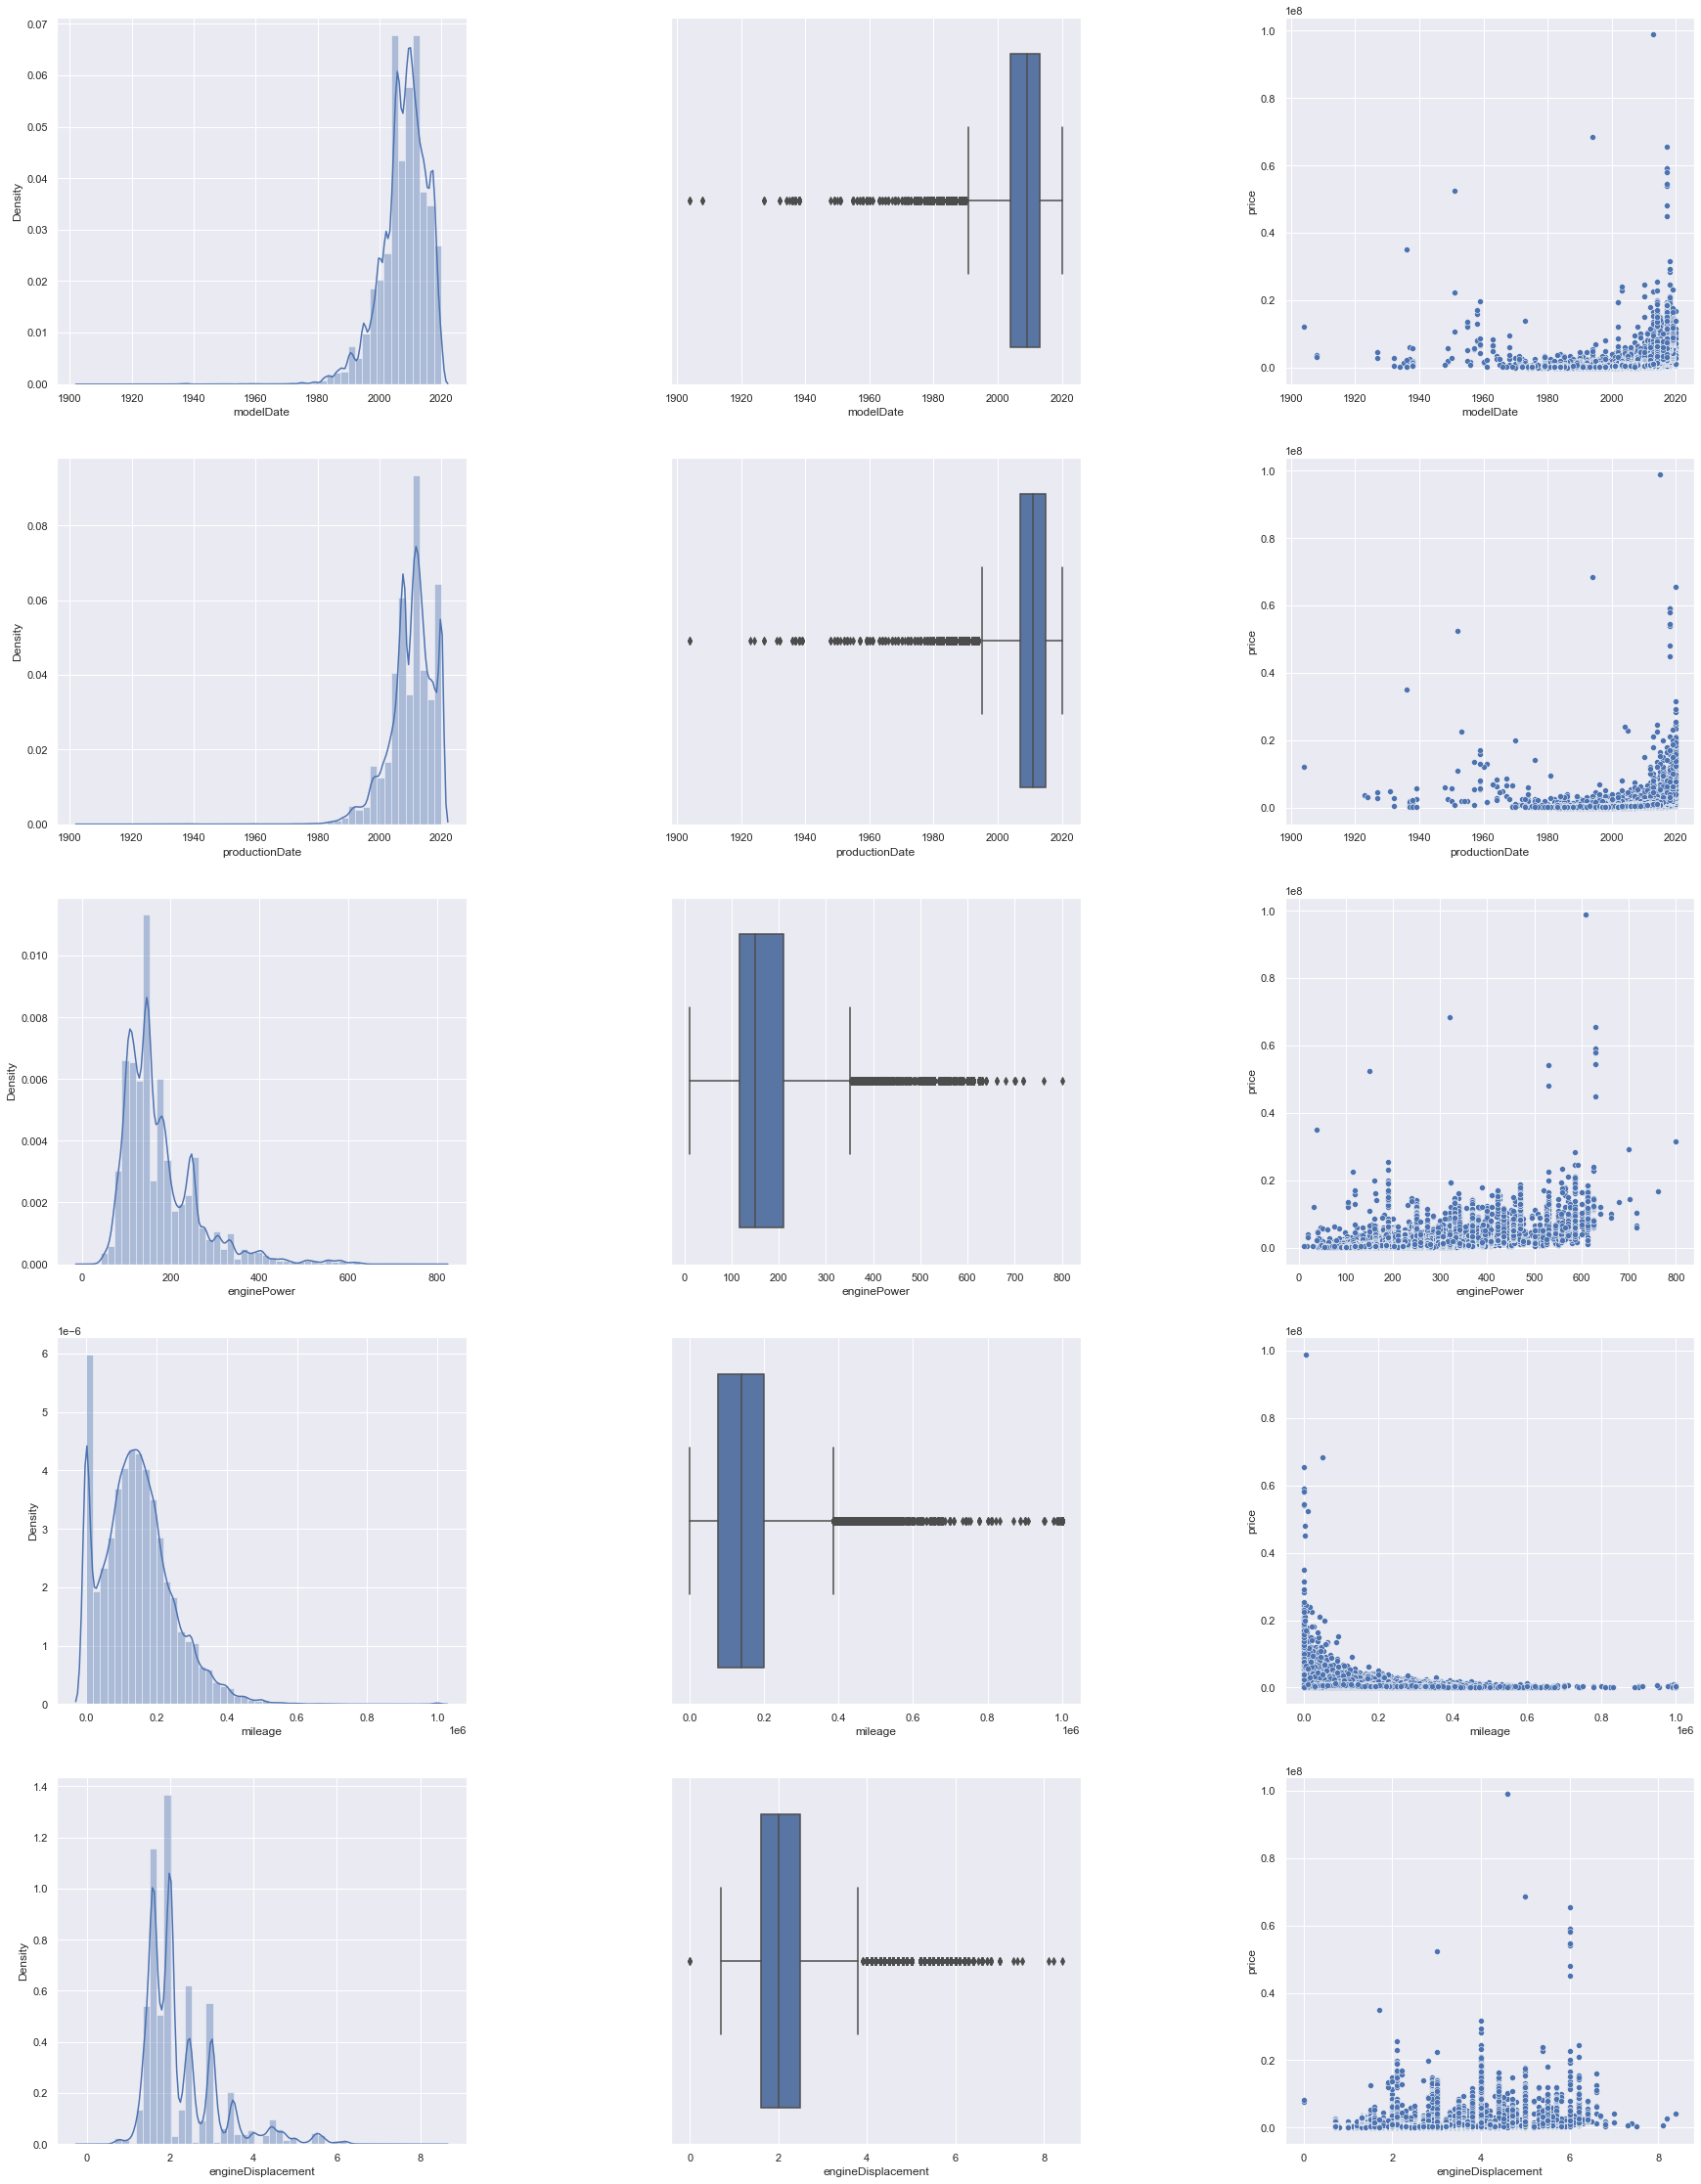

In [119]:
# Построим распределение основных числовых признаков

print("Диаграмы распределения числовых признаков, взаимосвязь с целевой переменной")

fig, axes = plt.subplots(5, 3, figsize=(30, 40))
plt.subplots_adjust(wspace=0.5)
axes = axes.flatten()
i = 0

for col in num_cols:
    sns.distplot(data[col], ax=axes[i])
    i = i + 1
    sns.boxplot(data[col], ax=axes[i])
    i = i + 1
    sns.scatterplot(data=data[data['train'] == 1],
                    x=col, y="price", ax=axes[i])
    i = i + 1

In [120]:
print("Основные статистики для числовых признаков.")
display(data[num_cols].describe())

Основные статистики для числовых признаков.


,modelDate,productionDate,enginePower,mileage,engineDisplacement
count,120076.000000,120076.000000,120076.000000,120076.000000,119915.000000
mean,2007.894142,2010.155010,175.934408,146058.040583,2.266744
std,7.385829,6.995833,85.916687,101886.681110,0.914350
min,1904.000000,1904.000000,11.000000,0.000000,0.000000
25%,2004.000000,2007.000000,116.000000,75648.500000,1.600000
50%,2009.000000,2011.000000,150.000000,138543.000000,2.000000
75%,2013.000000,2015.000000,210.000000,200000.000000,2.500000
max,2020.000000,2020.000000,800.000000,1000000.000000,8.400000


Выводы:

После построения гистограмм стало очевидно, что распределения основных числовых переменных имеют тяжёлый левый или правый хвост, влияет на разбежку между средним и медианой:
для того, чтобы сделать распределение данных переменных более нормальным, можно работать с логарифмированными величинами этих переменных
поработать с выбросами
подумать про группировку признаков по категориям.
Распределение modelDate, productionDate очень схожи:
проверить признаки на мультиколлинеарность во время корреляционного анализа
видно, что в среднем productionDate чуть позже, чем modelDate во времени, т.е. производство приосходит чуть с запозданием, что логично. Можно добавить новый признак - насколько новая модель, т.е. через сколько лет после появления модели был выпущен автомобиль.
mileage: есть пик в 0 - признак нового авто.
enginePower: 11 лс - что это за авто? Поисследовать
engineDisplacement: основная масса авто - 2.0 л, есть разброс.
Взаимосвязь признаков с таргетом:
наблюдается прямая корреляция цены от года модели и года выпуска с исключениями для особо раритетных автомобилей.
наблюдается обратная корреляция цены от пробега авто
цена от мощности вдигателя и объема двигателя зависит, но не так явно, как от других переменных.

#### Корреляционный анализ.
Оценим корреляцию Пирсона для непрерывных переменных. Cильная корреляция между переменными вредна для линейных моделей из-за неустойчивости полученных оценок.

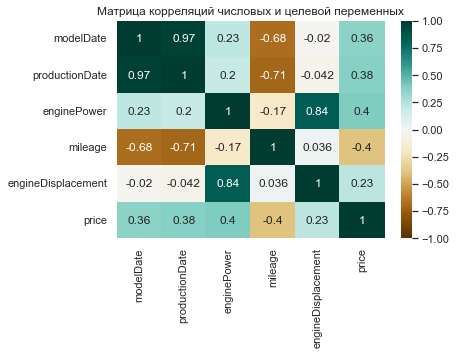

In [121]:
# Построим матрицу корреляций
heatmap = sns.heatmap(data[num_cols + target_col].corr(), vmin=-1,
                      vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Матрица корреляций числовых и целевой переменных')
plt.show()

Вывод:

Взаимосвязь пар числовых признаков по Пирсону достаточно сильная для productionDate, modelDate. При этом, у productionDate чуть большая корреляция с целевой переменной. Удалим признак modelDate.
Достаточно сильная корреляция между productionDate и mileage - чем меньше год выпуска, тем больше пробег
engineDisplacement и enginePower достаточно сильно скоррелированы (0.84). Для моделирования оставим один признак - enginePower, т.к. он сильнее влияет на price.
У всех числовых признаков достаточно высокая корреляция с целевой переменной, это хорошо.

In [122]:
# Добавляем modelDate в список колонок на удаление.
cols_removal.append('modelDate')
cols_removal.append('engineDisplacement')

#### Дополнительный анализ числовых признаков
Посмотрим более пристально на признаки, которые не исключили из анализа.

#### mileage

Дополнительно исследуем признак.

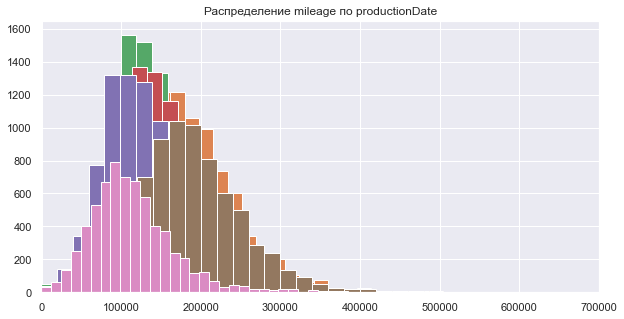

In [123]:
# Посмотрим на топ 5 годов выпуска авто
fig, ax = plt.subplots(figsize=(10, 5))

for x in (data['productionDate'].value_counts())[0:7].index:
    data['mileage'][data['productionDate'] == x].hist(bins=50)

ax.set_xlim(0, 700000)
ax.set_ylim(0, 1650)

plt.title("Распределение mileage по productionDate")
plt.show()

Получается, что mileage имеет достаточно нормальное распределение, не с таким уж сильным правым смещением, если смотреть на графики по годам производства, а не на все числа. Чем старше автомобиль, тем больше пробег и мы наблюдаем смещение.

Чтобы скорректировать признак и сделать его более информативным, создадим новый признак в разделе создания признаков: km_per_year - показывает, сколько км в год проезжал автомобиль. Вычисляется как mileage/productionDate(years) или mileage/ownershipTime. Решить, какой метод использовать.

#### enginePower

Нужно поисследовать странное минимальное значение мощности.

In [124]:
print("Значение мощности двигателя (л.с.) на TEST")
display(data[data.train == 0]['enginePower'].describe())

print("\nЗначение мощности двигателя (л.с.) на TRAIN")
display(data[data.train == 1]['enginePower'].describe())

Значение мощности двигателя (л.с.) на TEST


count    34686.000000
mean       188.194142
std         89.087035
min         30.000000
25%        125.000000
50%        169.000000
75%        233.000000
max        639.000000
Name: enginePower, dtype: float64


Значение мощности двигателя (л.с.) на TRAIN


count    85390.000000
mean       170.954421
std         84.086503
min         11.000000
25%        115.000000
50%        150.000000
75%        199.000000
max        800.000000
Name: enginePower, dtype: float64

Видим, что в test значение минимума больше, а максимума меньше. Посмотрим, что это за авто и сколько их.

In [125]:
print("Строки, в которых мощность двигателя меньше 30 л.с.")
data[data.enginePower < data[data.train == 0]['enginePower'].min()]

Строки, в которых мощность двигателя меньше 30 л.с.


,bodyType,brand,color,fuelType,modelDate,name,numberOfDoors,productionDate,vehicleConfiguration,vehicleTransmission,...,customs,ownershipTime,price,model,vendor,parsing_date,train,sell_id,transmission,ownershipTimeMonths
22691,кабриолет,FORD,зелёный,бензин,1908,2.9 MT (20 л.с.),2,1923,CABRIO MECHANICAL 2.9,механическая,...,1,no_data,3800000.0,MODEL_T,AMERICAN,2020-09-09,1,0,MT,NaN
22692,кабриолет,FORD,чёрный,бензин,1908,2.9 MT (20 л.с.),2,1924,CABRIO MECHANICAL 2.9,механическая,...,1,no_data,3000000.0,MODEL_T,AMERICAN,2020-09-09,1,0,MT,NaN
59955,купе,RENAULT,белый,электро,2011,Electro AT (13 кВт),2,2012,COUPE AUTOMATIC Electro,автоматическая,...,1,1 год и 3 месяца,449000.0,TWIZY,EUROPEAN,2020-09-09,1,0,AT,15.0
59956,купе,RENAULT,чёрный,электро,2011,Electro AT (9 кВт),2,2016,COUPE AUTOMATIC Electro,автоматическая,...,1,1 год и 4 месяца,549000.0,TWIZY,EUROPEAN,2020-09-09,1,0,AT,16.0


In [126]:
print("Строки, в которых мощность двигателя более 639 л.с.")
data[data.enginePower > data[data.train == 0]['enginePower'].max()]

Строки, в которых мощность двигателя более 639 л.с.


,bodyType,brand,color,fuelType,modelDate,name,numberOfDoors,productionDate,vehicleConfiguration,vehicleTransmission,...,customs,ownershipTime,price,model,vendor,parsing_date,train,sell_id,transmission,ownershipTimeMonths
18731,купе,DODGE,синий,бензин,2014,Hellcat 6.2 AT (717 л.с.),2,2016,COUPE AUTOMATIC Hellcat,автоматическая,...,1,1 год и 6 месяцев,6500000.0,CHALLENGER,AMERICAN,2020-09-09,1,0,AT,18.0
18733,купе,DODGE,серый,бензин,2014,Hellcat 6.2 AT (717 л.с.),2,2016,COUPE AUTOMATIC Hellcat,автоматическая,...,1,no_data,5990000.0,CHALLENGER,AMERICAN,2020-09-09,1,0,AT,NaN
18832,пикап,DODGE,серый,бензин,2018,Crew Cab TRX 6.2 AT (702 л.с.) 4WD,4,2020,PICKUP_TWO AUTOMATIC Crew,автоматическая,...,1,no_data,14433255.0,RAM,AMERICAN,2020-09-09,1,0,AT,0.0
23483,купе,FORD,красный,бензин,2009,Shelby GT500 5.8 MT (662 л.с.),2,2013,COUPE MECHANICAL Shelby,механическая,...,1,no_data,9980000.0,MUSTANG,AMERICAN,2020-09-09,1,0,MT,NaN
23485,купе,FORD,чёрный,бензин,2009,Shelby GT500 5.8 MT (662 л.с.),2,2013,COUPE MECHANICAL Shelby,механическая,...,1,no_data,9000000.0,MUSTANG,AMERICAN,2020-09-09,1,0,MT,NaN
32411,внедорожник,JEEP,белый,бензин,2013,Trackhawk 6.2 AT (717 л.с.) 4WD,5,2019,ALLROAD_5_DOORS AUTOMATIC Trackhawk,автоматическая,...,1,no_data,10300000.0,GRAND_CHEROKEE,AMERICAN,2020-09-09,1,0,AT,0.0
57242,седан,PORSCHE,серый,электро,2019,Turbo S Electro AT (561 кВт) 4WD,4,2020,SEDAN AUTOMATIC Turbo,автоматическая,...,1,no_data,16601327.0,TAYCAN,EUROPEAN,2020-09-09,1,0,AT,0.0
57246,седан,PORSCHE,белый,электро,2019,Turbo Electro AT (501 кВт) 4WD,4,2020,SEDAN AUTOMATIC Turbo,автоматическая,...,1,8 месяцев,13500000.0,TAYCAN,EUROPEAN,2020-09-09,1,0,AT,8.0
83909,внедорожник,MERCEDES,чёрный,бензин,2018,Brabus 700 4.0 AT (700 л.с.) 4WD,5,2020,ALLROAD_5_DOORS AUTOMATIC Brabus,автоматическая,...,1,no_data,29300000.0,G_KLASSE_AMG,EUROPEAN,2020-09-09,1,0,AT,0.0
83976,внедорожник,MERCEDES,чёрный,бензин,2018,Brabus 800 4.0 AT (800 л.с.) 4WD,5,2020,ALLROAD_5_DOORS AUTOMATIC Brabus,автоматическая,...,1,no_data,31600000.0,G_KLASSE_AMG,EUROPEAN,2020-09-09,1,0,AT,0.0


Таких строк немного, удалять строки нельзя, т.к. необходимо строить предсказания по большим значениям enginePower.

#### productionDate/modelDate

Посмотрим повнимательнее на признак и попробуем проанализировать поглубже.

In [127]:
print("Значение года производства авто на TEST")
display(data[data.train == 0]['productionDate'].describe())

print("\nЗначение года производства авто на TRAIN")
display(data[data.train == 1]['productionDate'].describe())

Значение года производства авто на TEST


count    34686.000000
mean      2009.264602
std          7.047661
min       1904.000000
25%       2006.000000
50%       2011.000000
75%       2014.000000
max       2020.000000
Name: productionDate, dtype: float64


Значение года производства авто на TRAIN


count    85390.00000
mean      2010.51670
std          6.94217
min       1904.00000
25%       2007.00000
50%       2011.00000
75%       2015.00000
max       2020.00000
Name: productionDate, dtype: float64

Минимальные значения, максимальные, медианные и среднии достаточно близки.

Посмотрим на раритетные автомобили (30 летние машины, согласно классификации FIVA (Fédération Internationale des Véhicules Anciens).

In [128]:
# Посмотрим, сколько таких записей
print(
    f"В датасете содержится {len(data[data.productionDate < (data['parsing_date'].max().year-30)]['productionDate'])} раритетных автомобилей.")

В датасете содержится 1126 раритетных автомобилей.


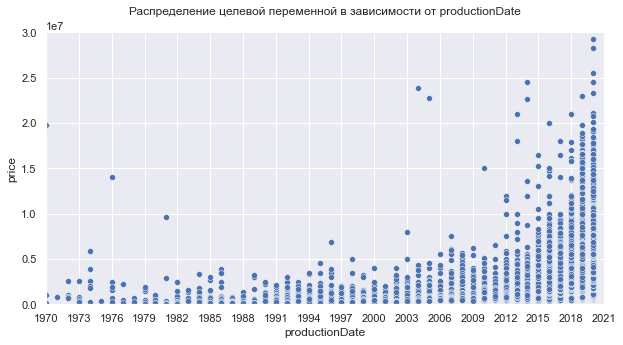

In [129]:
# Детальнее посмотрим, как падает цена в зависимости от productionDate

fig, ax = plt.subplots(figsize=(10, 5))

ax.set_xlim(1970, 2021)
ax.set_ylim(0, 30000000)
ax.set_xticks(np.arange(1970, 2022, 3))

sns.scatterplot(data=data[data['train'] == 1], x='productionDate', y="price")

plt.title("Распределение целевой переменной в зависимости от productionDate\n")
plt.show()

Можно найти много информации, что цена автомобиля значительно падает после 3-5 лет эксплуатации. На графиках даная динамика тоже прослеживается. Идеи для новых признаков:

prodDate_3Y - признак, что автомобилю уже 3 года
prodDate_5Y - признак, что автомобилю уже 5 лет.

### Посмотрим на распределение признаков.

Распределение бинарных и категориальных признаков. Нажимите дважды для увелечения.


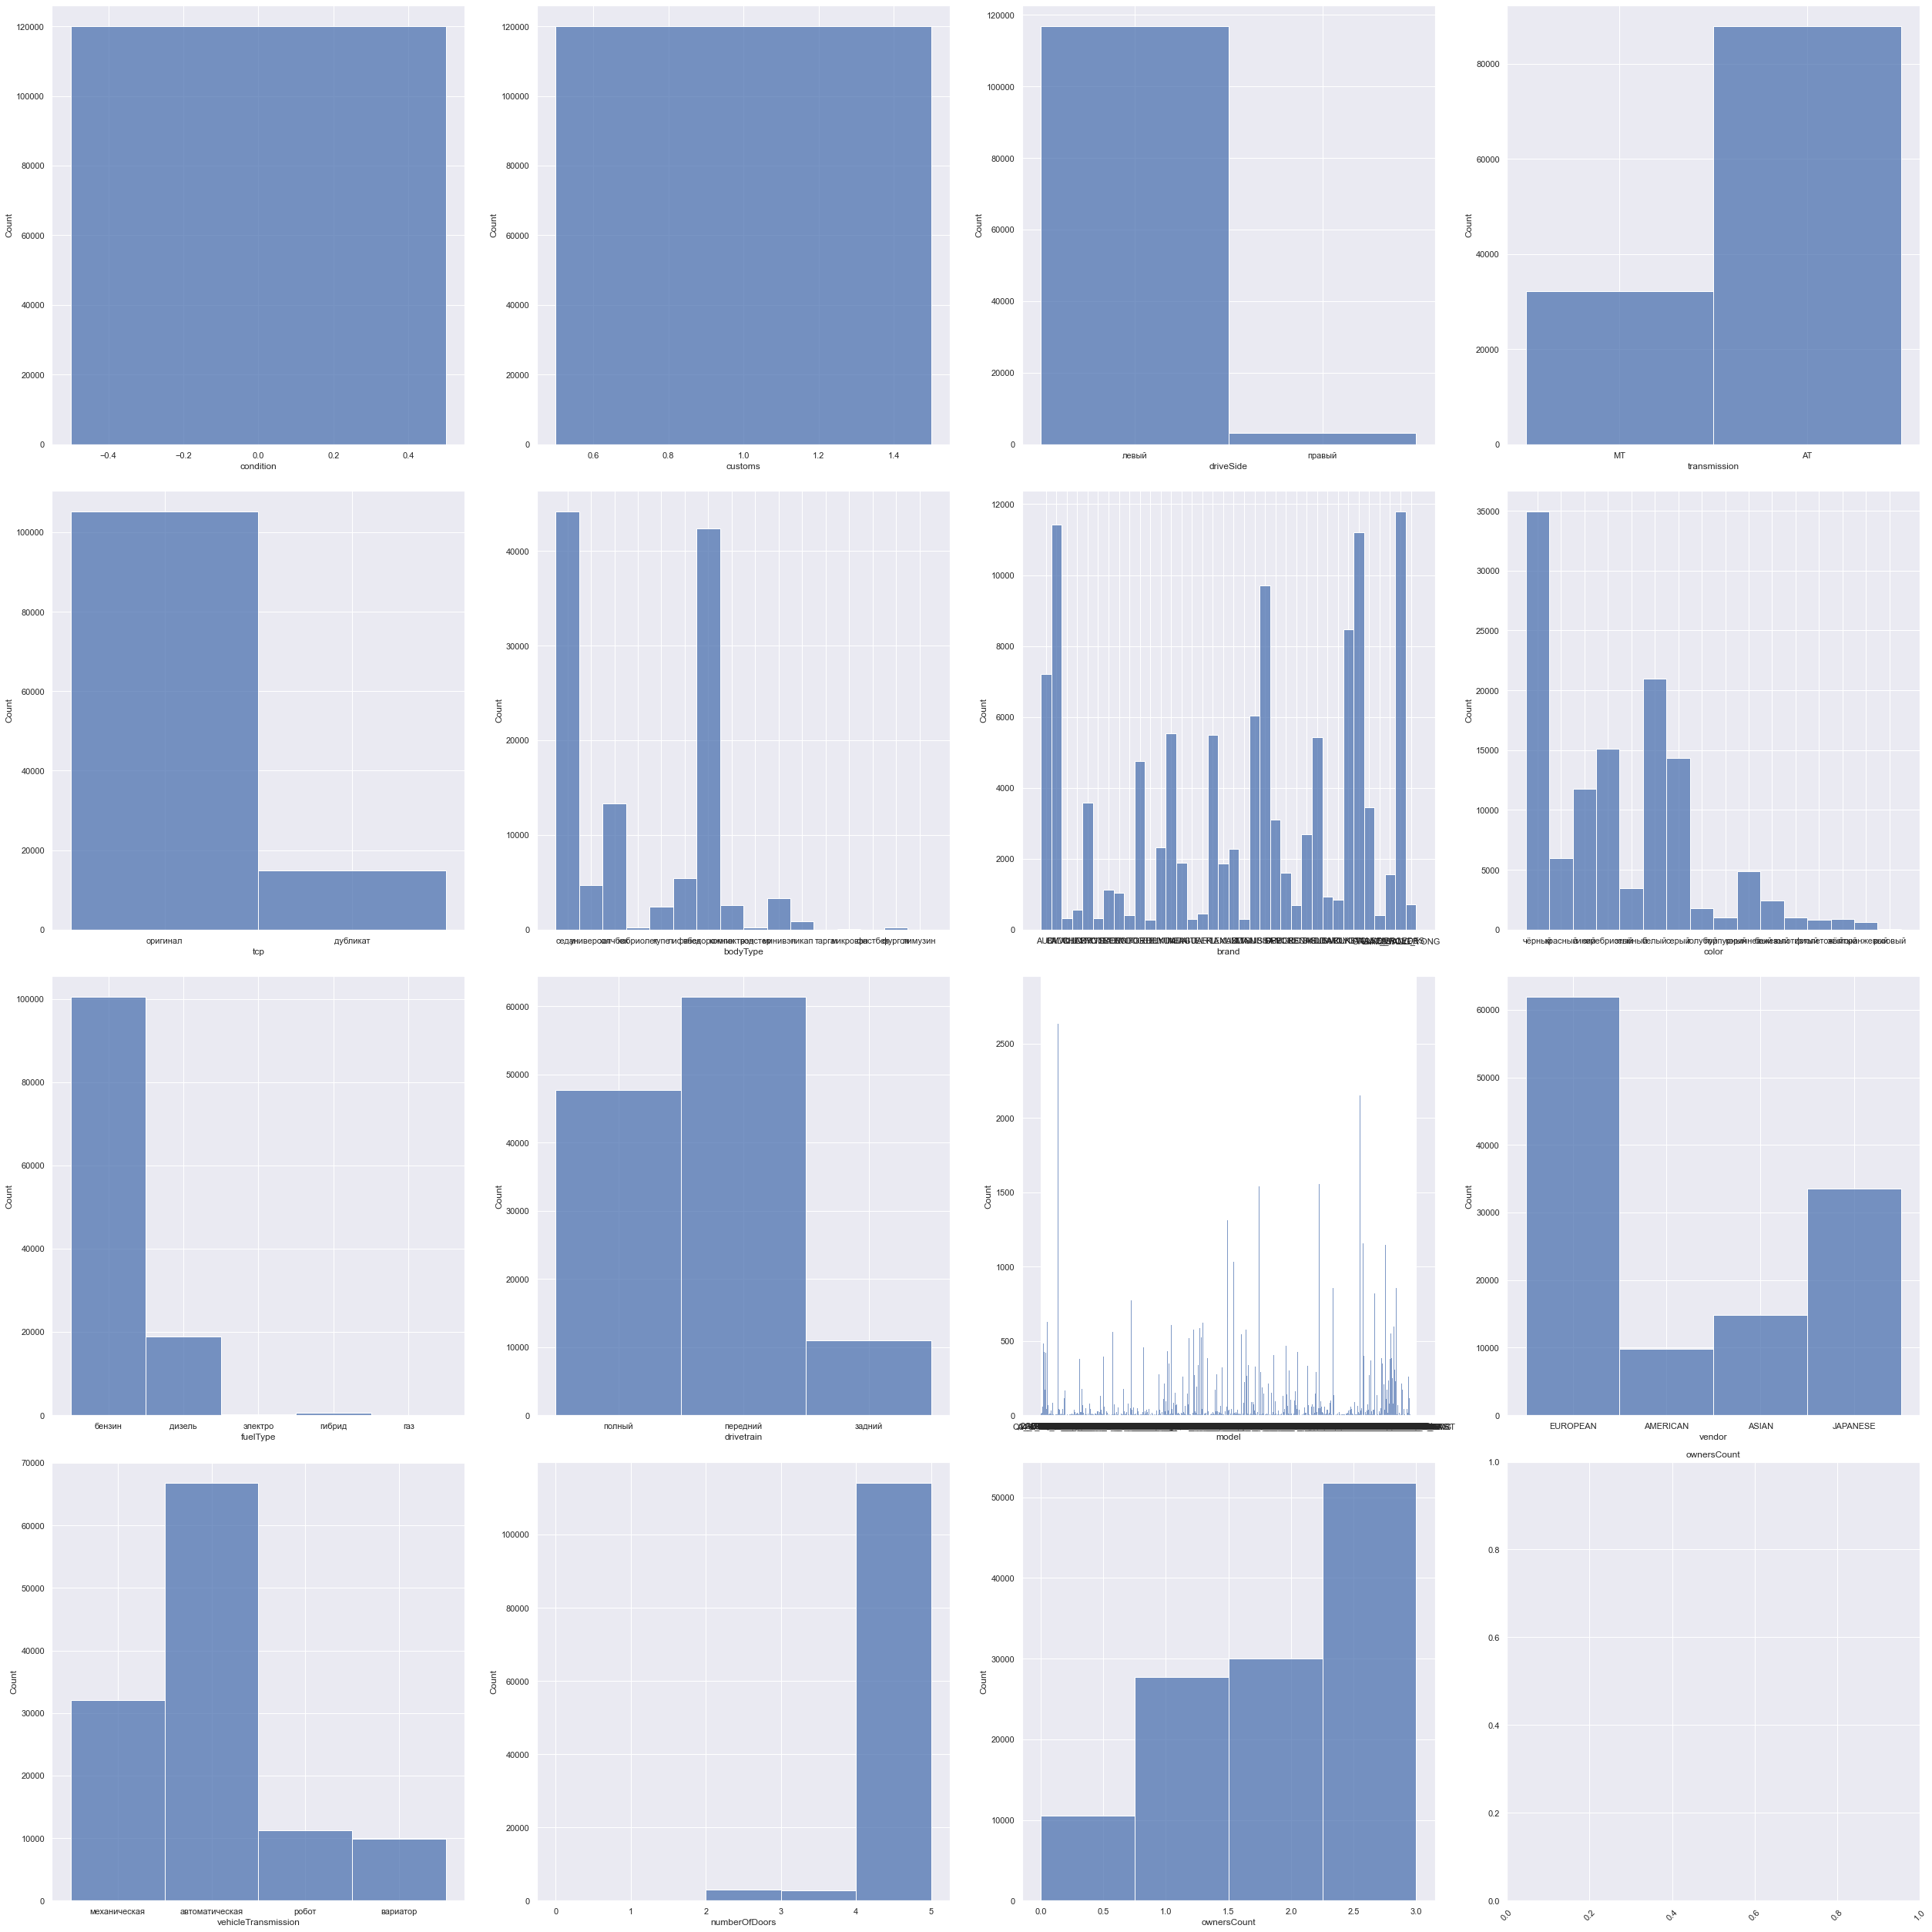

In [130]:
# Построим распределение основных бинарных и категориальных признаков
print("Распределение бинарных и категориальных признаков. Нажимите дважды для увелечения.")

fig, axes = plt.subplots(4, 4, figsize=(35, 35))
plt.subplots_adjust(wspace=0.5)
axes = axes.flatten()
i = 0

for col in (bin_cols + cat_cols):
    sns.histplot(data=data, x=data[col], ax=axes[i],
                 stat='count', bins=data[col].nunique())
    plt.tight_layout()
    plt.xticks(rotation=45)
    plt.title(col)
    i = i + 1

Boxplot нечисловых признаков и их зависимость от цены.


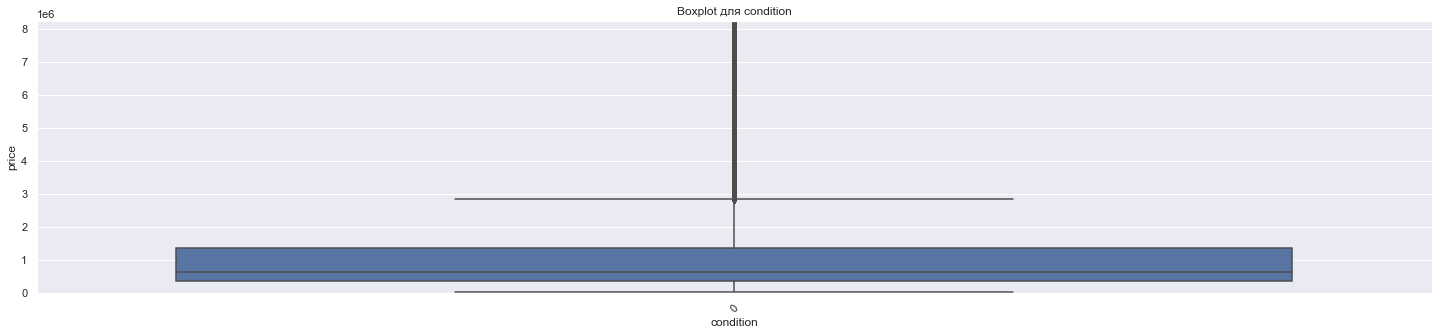

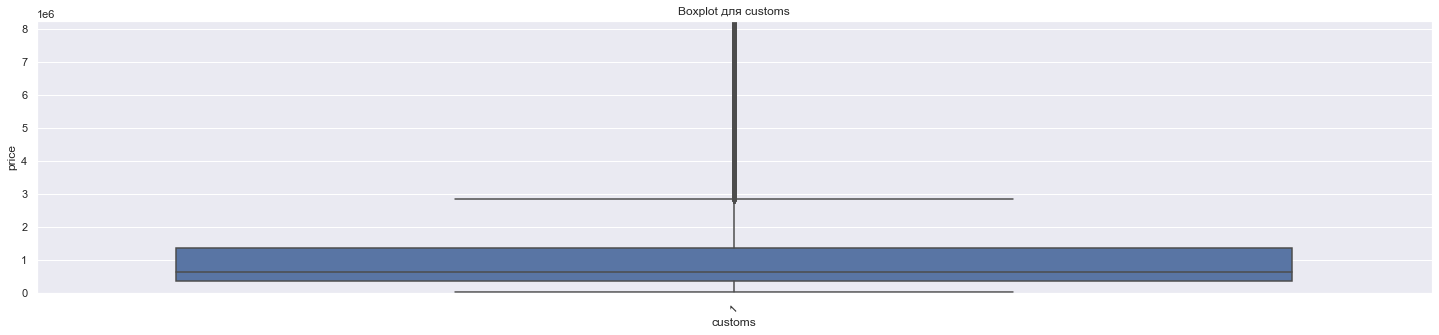

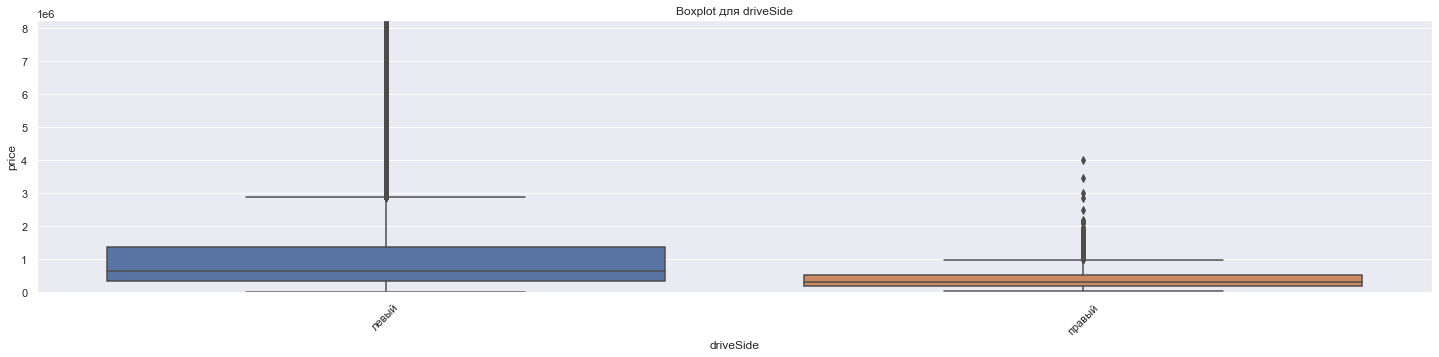

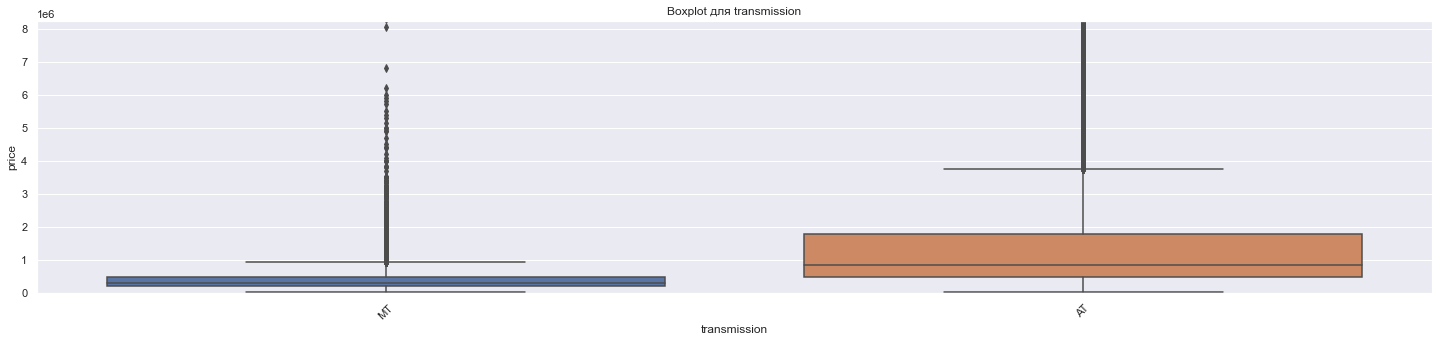

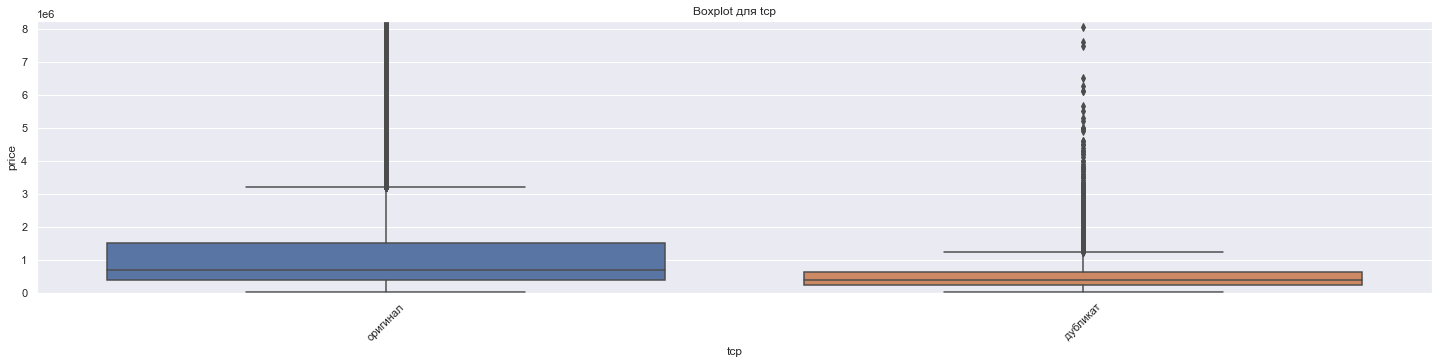

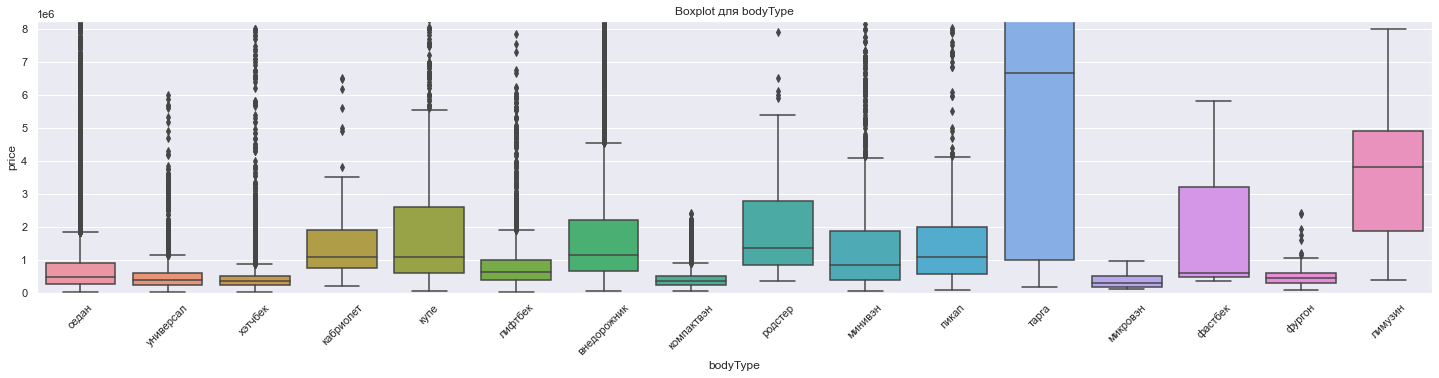

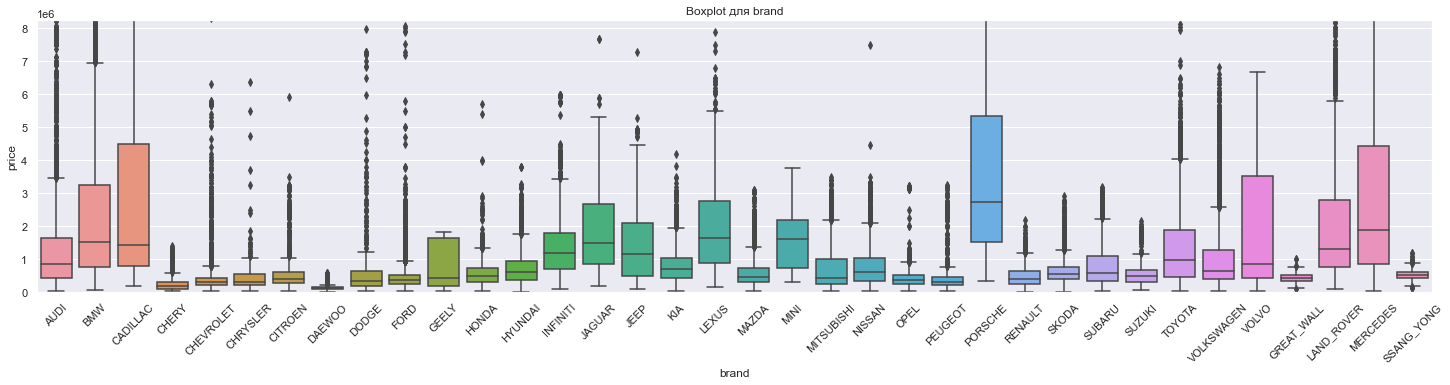

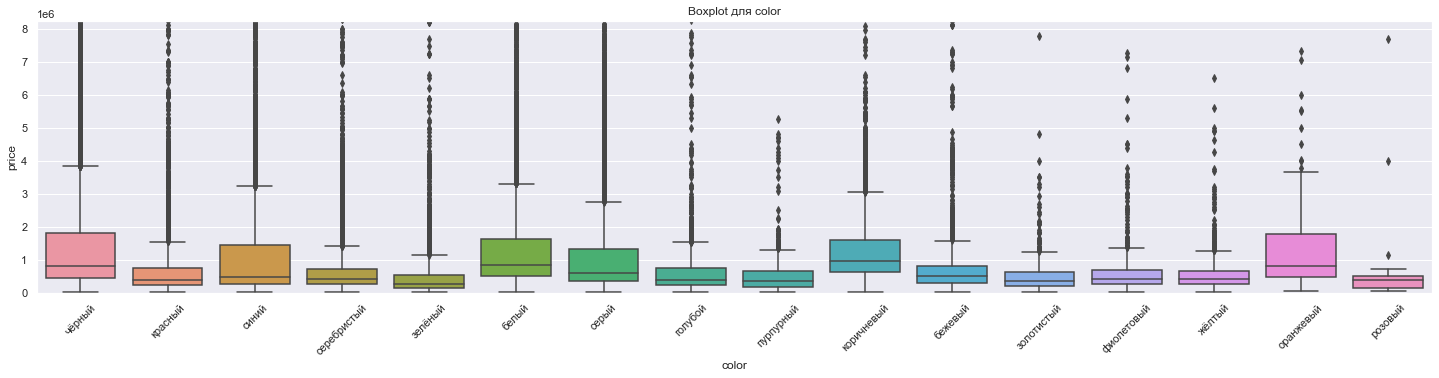

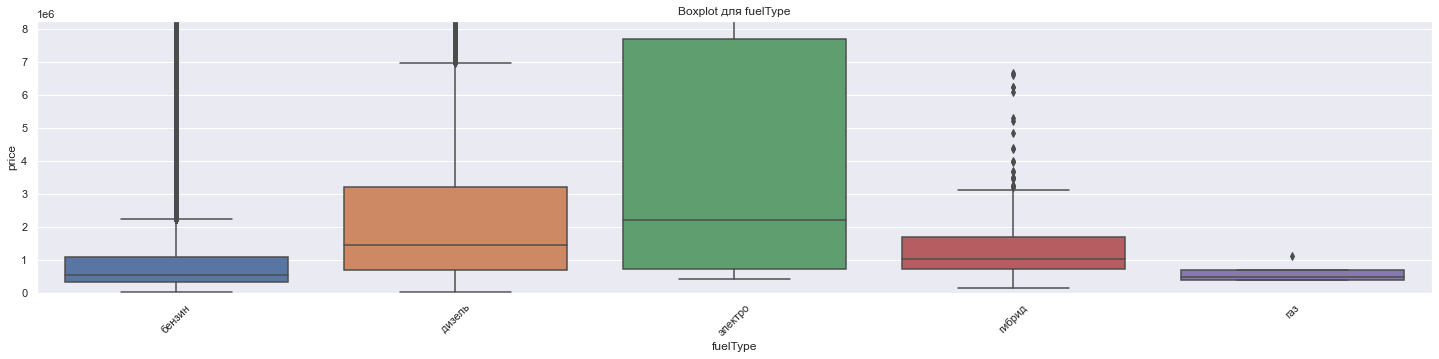

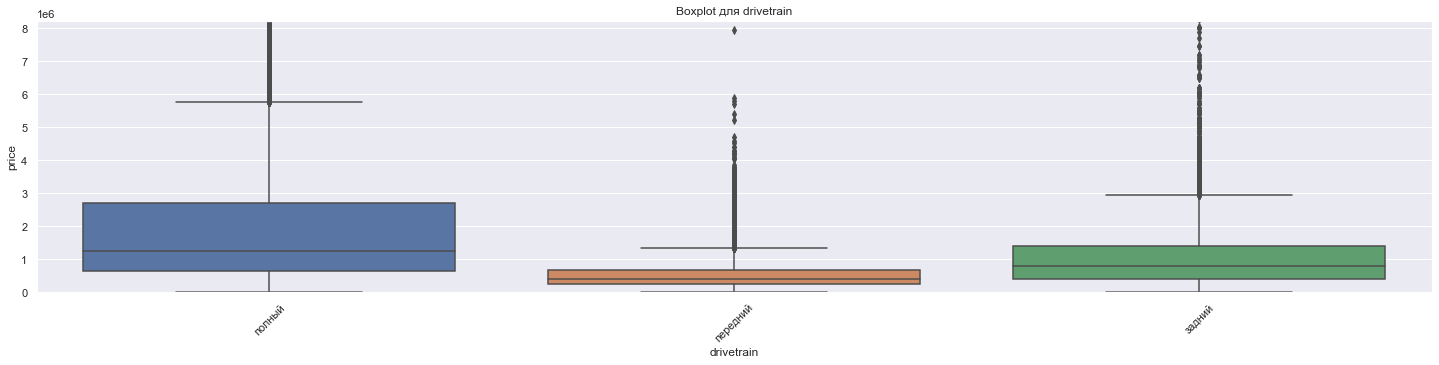

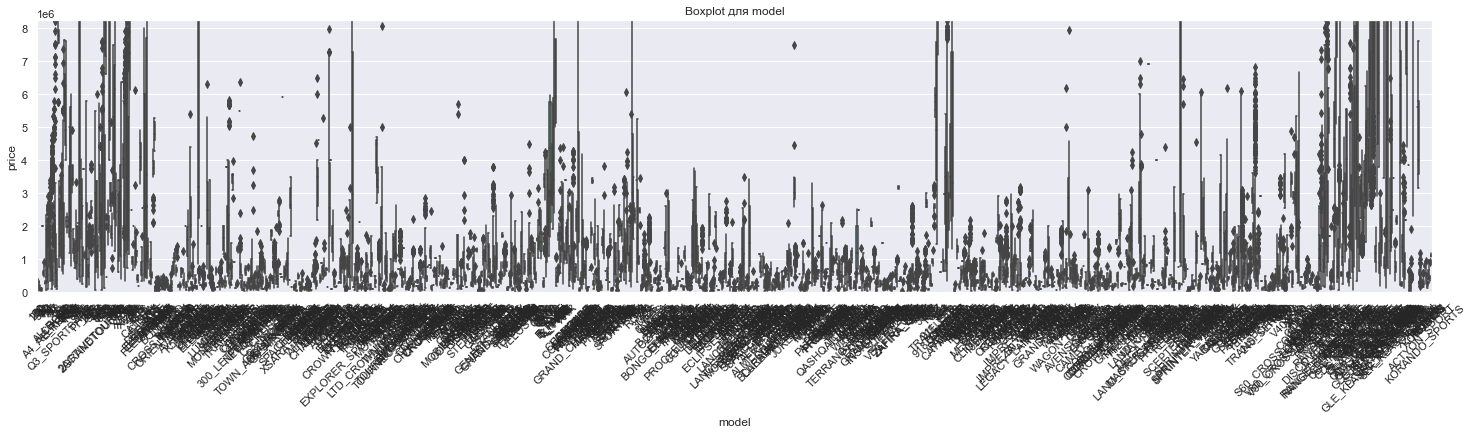

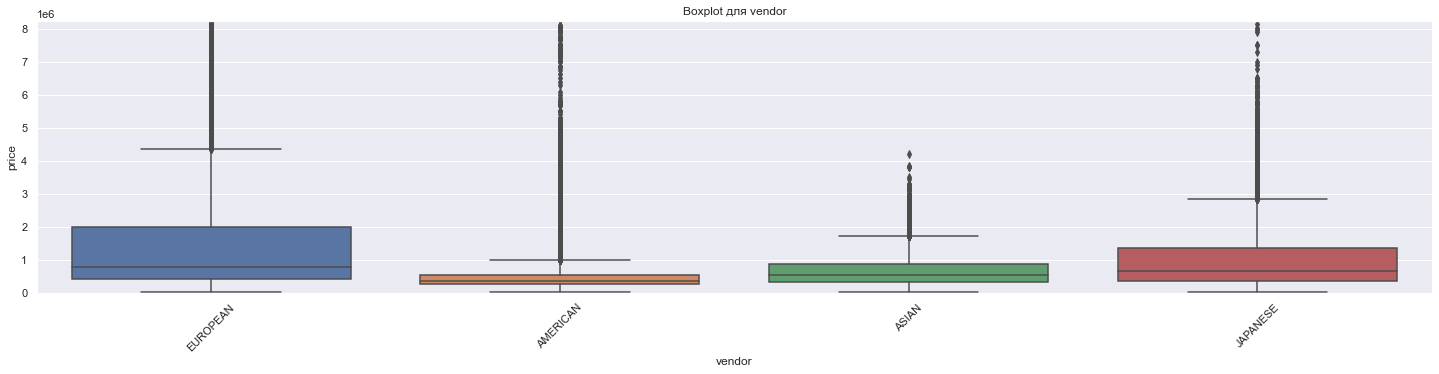

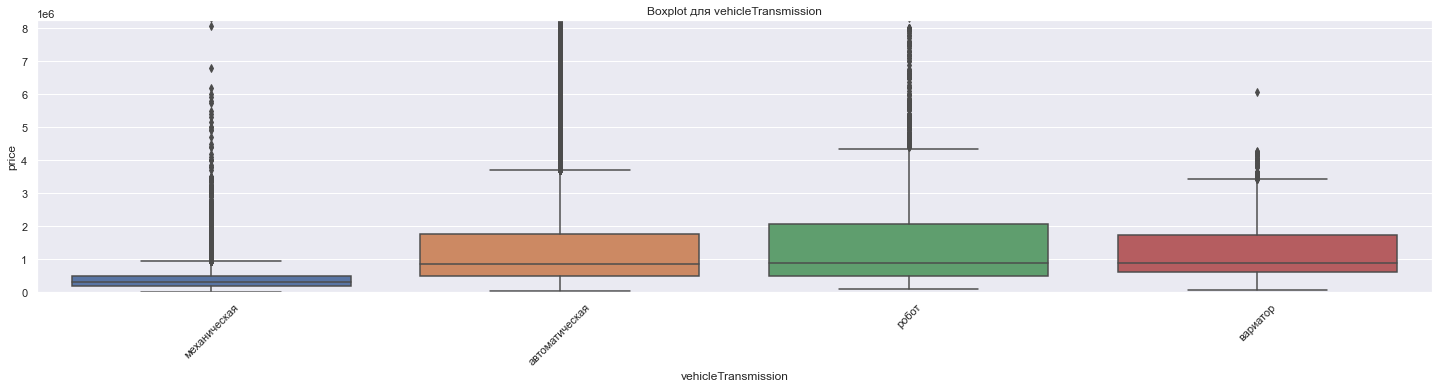

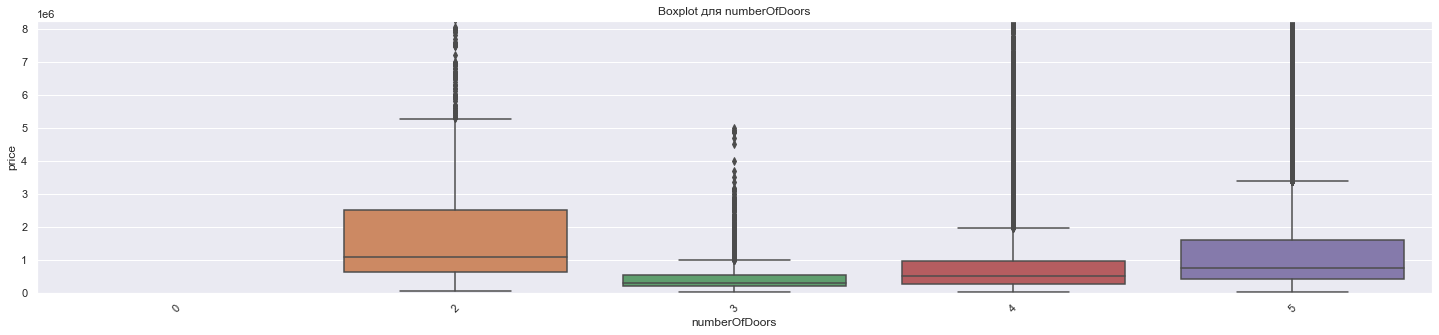

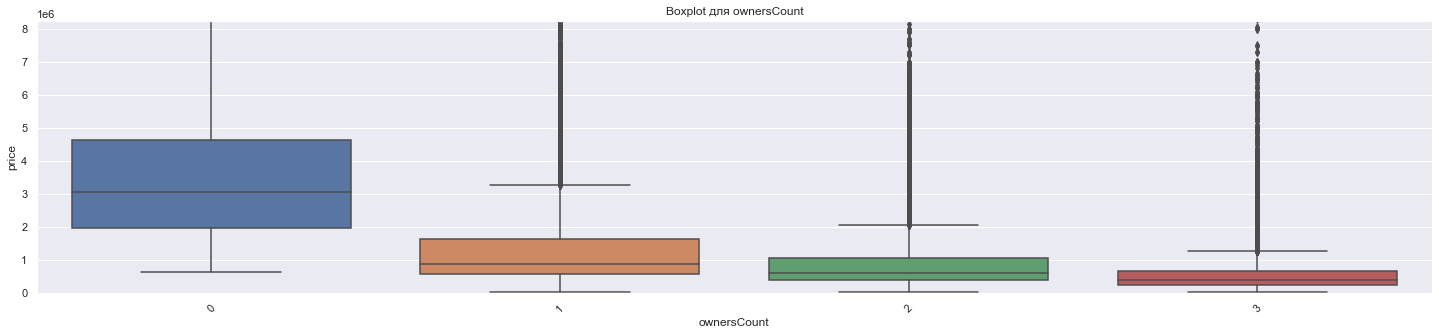

In [131]:
# Построим график boxplot
print("Boxplot нечисловых признаков и их зависимость от цены.")
for col in (bin_cols + cat_cols):    
    get_boxplot(col)

Выводы по всем графикам:

Полностью сбалансированные признаки отсутсвуют.
Особо несбалансированные признаки:

[x] driveSide - левосторонние машины в большинстве: выяснить, есть ли правосторонние машины в тесте. Если нет, то удалить признак
[x] bodyType - некоторые категории представлены небольшим количеством машин, но boxplot показывает значительные различия и распределении по ценам. Идея схлопнуть малочисленные категории в other кажется не очень хорошей, т.к. разброс медианных цен очень большой для этих категорий. Оставлим пока признак, как есть.
[x] brand - много категорий, заметно, что есть массовые, среднепопулярные и редкие бренды авто. Поисследовать дополнительно и подумать над созданием новых признаков (престижные авто/люкс, популярные и т.д.)
[x] color - есть популярные цвета (черный, белый, серый, серебристый, синий) и редкие. Посмотреть дополнительно и создать новый признак о популярности цвета
[x] fuelType - есть типы топлива, которые в явном меньшинстве. Поисследовть и подумать, стоит ли делать группировку непопулярных типов топлива
[x] tcp - несбалансированный признак, но пока оставляем в модели
[x] model - очень много уникальных категорий, подумать, можно ли как-то доработать признак. Подумать про объединение brand + model
[x] numberOfDoors - малое количество машин в 0-3 - изучить детальнее

Сбалансированные признаки с заметно превалирующим классом:

transmission - автомат превалирует
drivertrain - полный привод встречается чаще всего
vendor - большее количество автомобилей европейского региона
ownersCount - привалирует 3 и более.

Неинформативные признаки: conditions, customs - после манипуляций с данными в признаках осталось только одно значение. Удаляем из анализа.

Зависимость с целевой переменной:

driveSide: авто с правосторонним рулем в среднем дешевле машин с левосторонним рулем
transmission: авто с АТ коробкой намного дороже MT, как и сам диапазон цен
bodyType: признак, который значительно влияет на распределение цен
brand: большая разбежка цен от бренда. Выделяются престижные авто (porche, Cadillac, bmw, and Rover, Lexus и др), а есть дешевый сегмент (азиатские авто - Cherry, Daewoo, Great wall и др.). Также видны бренды, которые выпускают дорогие авто, но и есть модели для более дешевого сегмента.
color: цены зависят от цвета, но большие цены представлены у цветов, количество авто по которым больше.
fuelType: очень дорогие машины электро и дизель, возможно выделить отдельный признак, что машина “электрокар”
drivetrain: полноприводные машины дороже всех, заднеприводные машины в среднем дешевле переднеприводных
tcp: авто с дубликатом ПТС дешевле чем те, что с оригиналом
model - данных много, но видно, что присутствую колебания цены в зависимости от модели
vendor: в среднем, европейские и японские машины дороже американских и азиатских
vehicleTransmission: в среднем разновидности автоматов особо не влияют на цену, проверить значимость признака тестом Стьюдента. Потенциально на исключение.
numberOfDoors: в среднем самые дорогие авто - 2-х дверные, затем 5-дверные.
ownersCount: чем больше владельцев, тем ниже средняя цена авто.

In [132]:
# Добавляем modelDate в список колонок на удаление.
cols_removal.append('condition')
cols_removal.append('customs')

Дополнительный анализ бинарных и категориальных признаков
Посмотрим более пристально на признаки, которые не исключили из анализа и по которым возникли вопросы/требуется дополнительное исследование после предварительного анализа.

#### driveSide

Левосторонние машины в большинстве, выясним, есть ли правосторонние машины в test. Если нет, то удалим признак.

In [133]:
# Проверяем распределение признака в test
test.driveSide.value_counts(normalize=True)

Левый     0.959667
Правый    0.040333
Name: driveSide, dtype: float64

4% данных в тесте правосторонние. Оставляем как есть.

#### brand

Марка машины.

In [134]:
print(
    f'Список категорий brand в test, которые не представлены в train: \n{list(set(data[data.train == 0].brand.unique()).difference(data[data.train == 1].brand.unique()))}')
print(
    f'\nСписок зачений brand в train, по которым не нужно делать предсказания в test: \n{list(set(data[data.train == 1].brand.unique()).difference(data[data.train == 0].brand.unique()))}')

Список категорий brand в test, которые не представлены в train: 
[]

Список зачений brand в train, по которым не нужно делать предсказания в test: 
['CHERY', 'CHEVROLET', 'GEELY', 'CADILLAC', 'FORD', 'CHRYSLER', 'SSANG_YONG', 'MINI', 'PEUGEOT', 'PORSCHE', 'KIA', 'DODGE', 'GREAT_WALL', 'CITROEN', 'SUBARU', 'MAZDA', 'HYUNDAI', 'JAGUAR', 'DAEWOO', 'RENAULT', 'OPEL', 'LAND_ROVER', 'JEEP', 'SUZUKI']


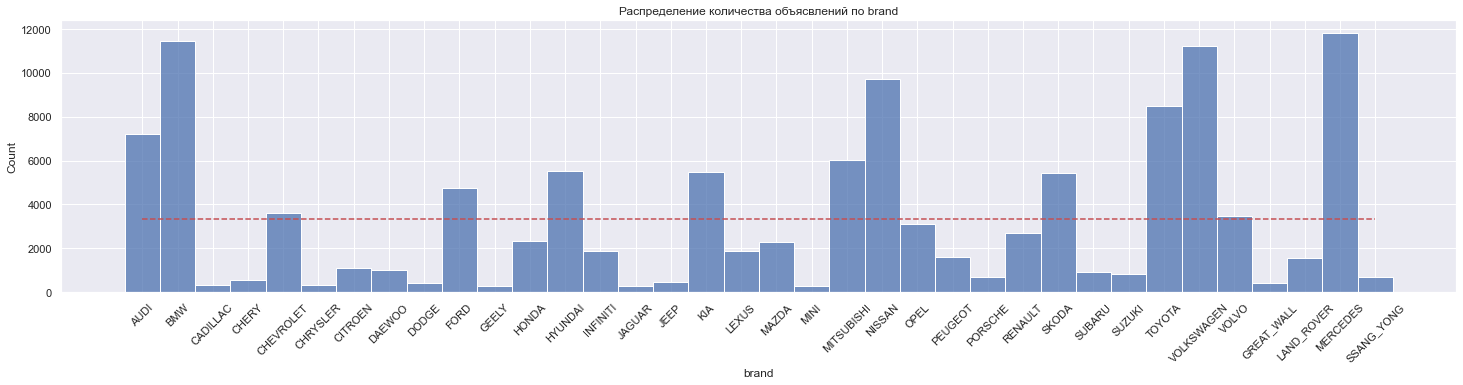

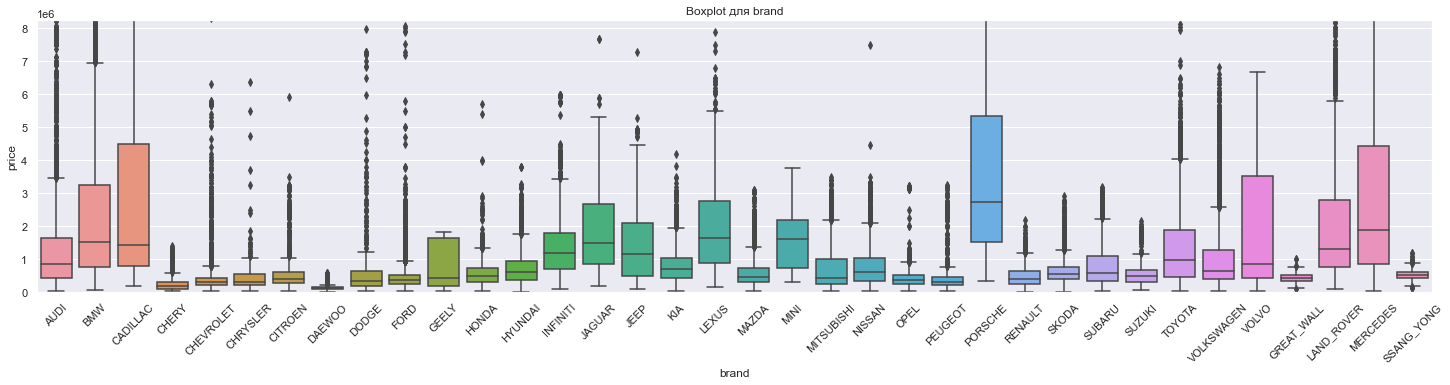

In [135]:
# Посмотрим внимательно на графики еще раз
analyze_cat_cols('brand')

Можно создать новые признаки:

Флаг популярного авто: за ориентир взять значение data['brand'].value_counts() > data['brand'].value_counts().values.mean().
Обычно на цену сильно влияет класс автомобиля (brand + bodyType), попробовать добавить признак с помощью метода главных компонент.
Также в train присутсвует значительно большее количество брендов, чем в test. Учитывать при обработке выбросов.

#### model

Модель машины.

In [136]:
print(
    f'Список категорий brand в test, которые не представлены в train: \n{list(set(data[data.train == 0].model.unique()).difference(data[data.train == 1].model.unique()))}')
print(
    f'\nСписок зачений brand в train, по которым не нужно делать предсказания в test: \n{list(set(data[data.train == 1].model.unique()).difference(data[data.train == 0].model.unique()))}')

Список категорий brand в test, которые не представлены в train: 
['OTTI', 'RSQ3', 'ZEST', 'SPARKY', 'IST', 'Z', 'TORNEO', 'PORTE', 'LM', 'GOLF_R32', 'WILL_CYPHA', 'COROLLA_II', 'LANCER_RALLIART', 'POLO_GTI', 'PRESEA', '300ZX', 'X4_M', 'ARTEON']

Список зачений brand в train, по которым не нужно делать предсказания в test: 
['SRX', 'WAGON_R', 'KAPTUR', 'ORIENTAL_SON', 'XK', 'BRONCO', 'XKR', 'AVANTE', 'HOVER_M2', 'LIFE', 'FOCUS', 'SEVILLE', 'EXPEDITION', 'BEL_AIR', 'KORANDO', 'QQ6', 'BT_50', 'VECTRA_OPC', 'CULTUS', 'DS5', 'PAO', 'OUTBACK', 'STS', 'LEGACY_LANCASTER', 'OPIRUS', 'CEED_GT', 'CABRIO', 'FUSION', 'GETZ', 'ATOS', 'HHR', 'ESPACE', 'H200', '2', 'KA', 'QQ', 'BONGO_FRIENDEE', 'XT5', 'INSIGNIA_OPC', 'CEED', 'VEL_SATIS', 'SCENIC', 'SANDERO', 'PRIDE', 'OPTIMA', 'F_150', 'I30', 'C3', 'LEGACY', 'ASTRA_OPC', 'NEON', 'CX_7', 'SAFE', 'RIO', 'LATITUDE', 'F_PACE', 'EQC', 'PATRIOT', 'ESCAPE', 'CAPELLA', 'CRUZE', 'SAMURAI', 'NEMO', 'MONTE_CARLO', 'INTREPID', 'C1', 'R2', 'GRAND_STAREX', 'VISION'

Вывод:

признак пока оставляем неизменным, можно добавить новый признак популярности модели среди брендов.
В test есть модели, по которым нет данных в train - возможны ошибки в предсказании.

#### color

Есть популярные цвета и редкие. Создадим новый признак популярности цвета.

In [137]:
print(
    f'Список категорий brand в test, которые не представлены в train: \n{list(set(data[data.train == 0].color.unique()).difference(data[data.train == 1].color.unique()))}')
print(
    f'\nСписок зачений brand в train, по которым не нужно делать предсказания в test: \n{list(set(data[data.train == 1].color.unique()).difference(data[data.train == 0].color.unique()))}')

Список категорий brand в test, которые не представлены в train: 
[]

Список зачений brand в train, по которым не нужно делать предсказания в test: 
[]


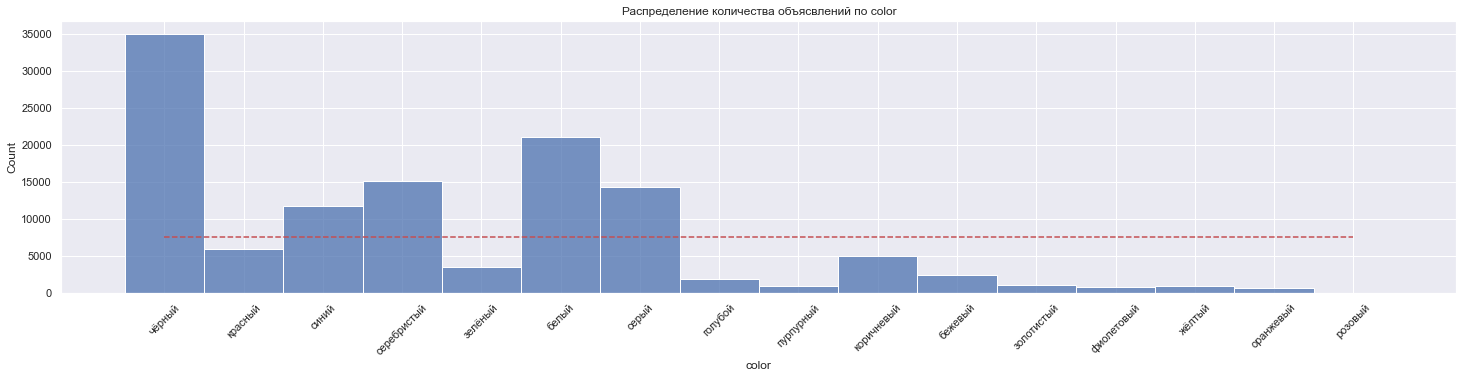

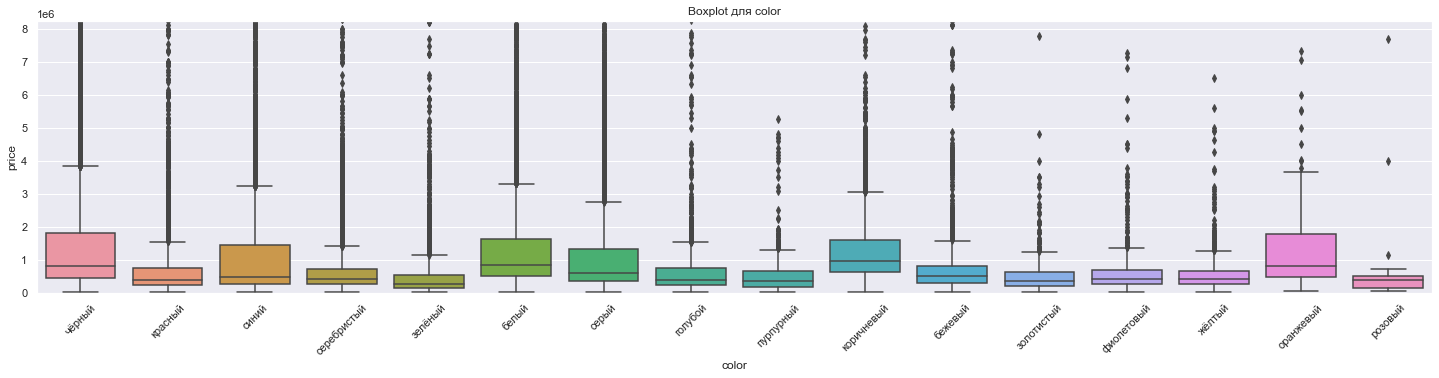

In [138]:
# Посмотрим внимательно на графики еще раз
analyze_cat_cols('color')

Создадим признак популярного авто: за ориентир взять значение data['color'].value_counts() > data['color'].value_counts().values.mean().

#### fuelType

Есть типы топлива, которые в явном меньшинстве. Поисследовть и подумать, стоит ли делать группировку непопулярных типов топлива.

In [139]:
print(
    f'Список зачений по fuelType в трейне:= {list(data[data.train == 0].fuelType.unique())}')
print(
    f'Список зачений по fuelType в тесте:= {list(data[data.train == 1].fuelType.unique())}')

Список зачений по fuelType в трейне:= ['бензин', 'дизель', 'гибрид', 'электро', 'газ']
Список зачений по fuelType в тесте:= ['бензин', 'дизель', 'электро', 'гибрид', 'газ']


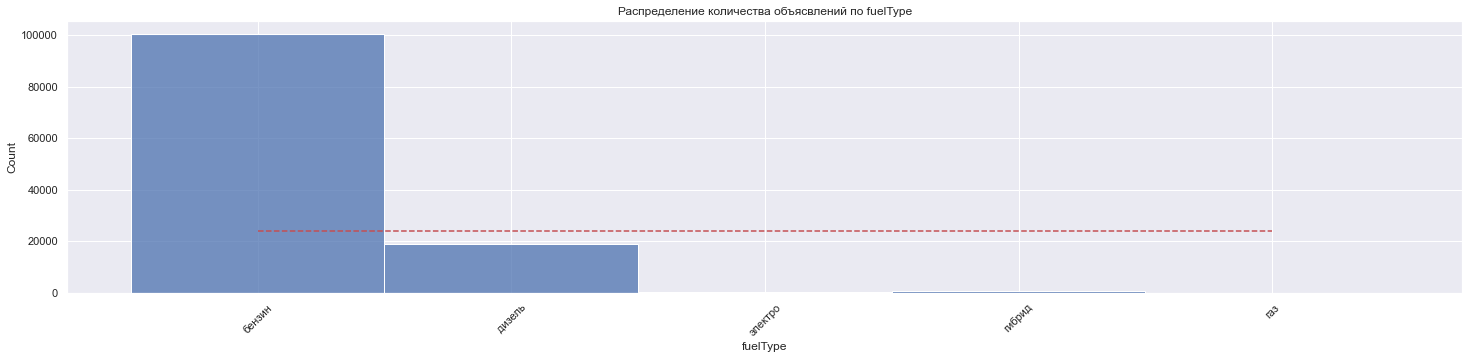

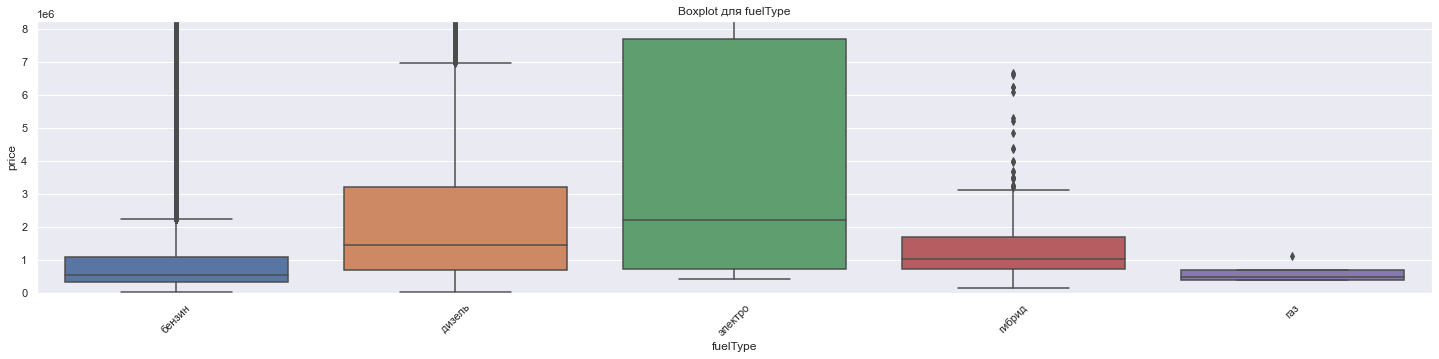

In [140]:
# Посмотрим внимательно на графики еще раз
analyze_cat_cols('fuelType')

In [141]:
# Посмотрим, какие бренды представлены в "электро" типе топлива в трейне и тесте
data[data['fuelType'] == 'электро'].groupby(
    ['train', 'brand'])['bodyType'].count()

train  brand     
0      AUDI           1
       BMW            9
       MERCEDES       1
       MITSUBISHI     2
       NISSAN        40
       VOLKSWAGEN     2
1      AUDI          39
       BMW            7
       CHEVROLET      1
       FORD           1
       JAGUAR         5
       MERCEDES       3
       MITSUBISHI     2
       NISSAN        42
       PORSCHE        5
       RENAULT        2
       VOLKSWAGEN     1
Name: bodyType, dtype: int64

Выводы:

Перечень категорий цветов идентичен в train и test.
Категории для данного признака оставим, как есть, т.к. сильно влияет на распределение цен.
[ ] идея для генерации нового признака - добавить флаг "электрокар".
Использовать информацию по распределению типа топлива-бренд между трейн и тестом для обработки выбросов.

#### numberOfDoors

Во время предварительного анализа появилась идея изучить значение 0 - выброс/ошибка или валидная запись.

In [142]:
# Посмотрим на записи с кол-вом дверей менее 2
data[data.numberOfDoors < 2]

,bodyType,brand,color,fuelType,modelDate,name,numberOfDoors,productionDate,vehicleConfiguration,vehicleTransmission,...,customs,ownershipTime,price,model,vendor,parsing_date,train,sell_id,transmission,ownershipTimeMonths
88065,кабриолет,MERCEDES,белый,бензин,1904,5.3 MT (32 л.с.),0,1904,CABRIO MECHANICAL 5.3,механическая,...,1,6 лет,12000000.0,SIMPLEX,EUROPEAN,2020-09-09,1,0,MT,72.0
106322,кабриолет,MERCEDES,белый,бензин,1904,5.3 MT (32 л.с.),0,1904,CABRIO MECHANICAL 5.3,механическая,...,1,6 лет и 8 месяцев,0.0,SIMPLEX,EUROPEAN,2020-10-21,0,1093802104,MT,80.0


Все в порядке - это раритетные машины, более того 1 из test, 1 из train, оставляем.

#### description

Посмотрим на признак повнимательнее и подумаем, что мы можем из него извлечь.

In [143]:
# Описание в train
data[data.train == 1]['description'].iloc[25]

'На ходу двигаюсь каждый день Все интересующие вопросы по телефону'

In [144]:
# Описание в test
data[data.train == 0]['description'].iloc[18]

'Продажа а/м осуществляется ОФИЦИАЛЬНЫМ ДИЛЕРОМ "АВТОРУСЬ".\nВ наличии более 200 проверенных и готовых к продаже автомобилей\n\n· Автомобиль доступен к просмотру в крытом и хорошо освещенном помещении\n· Автомобиль прошел ТЕХНИЧЕСКУЮ И ЮРИДИЧЕСКУЮ ПРОВЕРКУ\n· Возможна ПОКУПКА В КРЕДИТ по специальной ставке от 9,9%\n· ВЫГОДА при покупке а/м в кредит – до 25 000 р.\n· ВЫГОДА при обмене на Ваш а/м – до 50 000 р.\n· СРОЧНЫЙ ВЫКУП авто, выплата в день обращения.\n\nЖдём вас ежедневно, с 9:00 до 21:00\n\n\n\nКомплектация автомобиля:\n\n• розетка 12V\n• штатная аудиосистема с CD\n• количество мест: 5\n• бортовой компьютер\n• обогрев сидений\n• мультифункциональное рулевое колесо\n• темный салон\n• тканевый салон\n• усилитель руля\n• подогрев передних сидений\n• отделка кожей рулевого колеса\n• отделка кожей рычага КПП\n• регулировка руля по высоте и вылету\n• регулировка сидений водителя по высоте\n• электростеклоподъемники все\n• климат-контроль\n• сиденье водителя: ручная регулировка\n• сид

Для анализа всего текста времени нет, но можно попробовать извлечь признаки количества слов в объявлении.

#### Преобразование бинарных переменных в числа
Чтобы алгоритмы машинного обучения могли работать с категориальными данными, их нужно преобразовать в числа. Применим LabelEncoder ко всему набору бинарных переменных.

In [145]:
# Для бинарных признаков мы будем использовать LabelEncoder
label_encoder = LabelEncoder()

for column in bin_cols:
    data[column] = label_encoder.fit_transform(data[column])

# Убедимся в преобразовании
data[bin_cols].sample(6)

,condition,customs,driveSide,transmission,tcp
43893,0,0,0,0,1
92761,0,0,0,0,0
19907,0,0,0,1,1
119177,0,0,0,0,1
90634,0,0,0,1,1
113783,0,0,0,0,1


#### Анализ целевой переменной price

In [146]:
# Посмотрим на основные статистики
print(data[data.train == 1]['price'].describe())

count    8.539000e+04
mean     1.238098e+06
std      1.921640e+06
min      1.600000e+04
25%      3.500000e+05
50%      6.300000e+05
75%      1.350000e+06
max      9.900000e+07
Name: price, dtype: float64


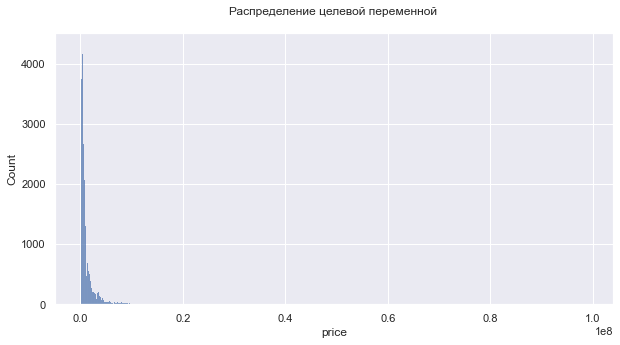

In [147]:
# Посмотрим на распределение целевой переменной
fig, ax = plt.subplots(figsize=(10, 5))
sns.histplot(data=data[data.train == 1], x='price')
plt.title("Распределение целевой переменной \n")
plt.show()

Распределение цены с очень сильным правым хвостом, попробуем добавить доп. целевой признак, взяв логорифм от цены.

#### price_log
Логарифм от цены.

In [148]:
# Добавляем новый признка
data['price_log'] = data['price'].apply(lambda x: np.log(x))

# Добавим новый признак в список целевых
target_col.append('price_log')

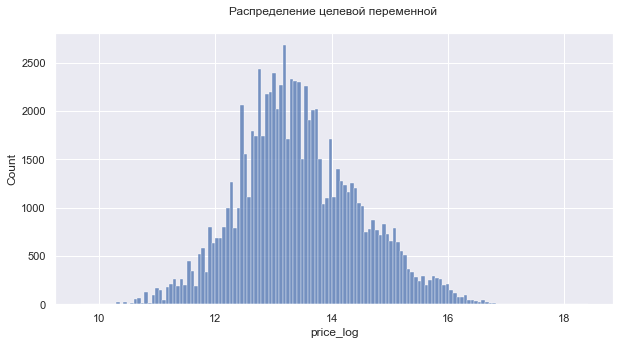

In [149]:
# Посмотрим, как изменилось распределение целевой переменной
fig, ax = plt.subplots(figsize=(10, 5))
sns.histplot(data=data[data.train == 1], x='price_log')
plt.title("Распределение целевой переменной \n")
plt.show()

Вывод: распределение выглядит, как нормальное. Используем для моделирования.

### Идеи по генерации новых признаков по результатам EDA:

[x] km_per_year - показывает, сколько км в год проезжал автомобиль. Вычисляется, как mileage/productionDate(years) или mileage/ownershipTime. Решить, какой метод использовать
[x] carNovelty - показывает, через сколько лет после выхода модели был выпущен автомобиль, т.е. modelDate - productionDate. Гипотеза, что чем меньше это число, тем выше будет цена
[x] `rarity - признак, показывающий, что автомобиль раритетный (ему более 30 лет)
[x] prodDate_3Y - признак, что автомобилю уже 3 года
[x] prodDate_5Y - признак, что автомобилю уже 5 лет
[x] colorPopular - признак для обозначения, что авто популярного цвета: 1 - популярного, 0 - непопулярного
[x] brandPopular - признак для обозначения, что авто популярной марки: 1 - популярного, 0 - непопулярного
[x] modelPopular - признак для обозначения, что авто популярной модели в рамках бренда: 1 - популярного, 0 - непопулярного

In [150]:
# Для упрощения повторного анализа для новых признаков добавим списки
cat_cols_new = []
num_cols_new = []
bin_cols_new = []

#### km_per_year

Пробег авто км/год.

In [151]:
# Добавим дополнительный признак 'km_per_year', который равен пробегу, поделенному на возраст авто,
data['km_per_year'] = data.apply(km_per_year, axis=1)

Диаграмы распределения km_per_year признака, взаимосвязь с целевой переменной


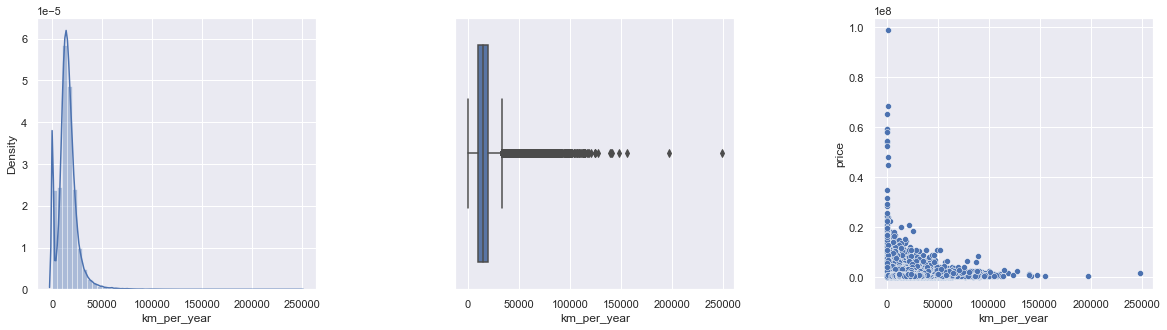

In [152]:
print("Диаграмы распределения km_per_year признака, взаимосвязь с целевой переменной")

fig, axes = plt.subplots(1, 3, figsize=(20, 5))
plt.subplots_adjust(wspace=0.5)
axes = axes.flatten()

sns.distplot(data['km_per_year'], ax=axes[0])
sns.boxplot(data['km_per_year'], ax=axes[1])
sns.scatterplot(data=data[data['train'] == 1],
                x='km_per_year', y="price", ax=axes[2])
plt.show()

Вывод: все равно есть правых хвост. Нужно или убрать выбросы, или попробовать логарифмирование.

In [153]:
# добавляем новый признак к числовым
num_cols.append('km_per_year')

In [154]:
num_cols_new.append('km_per_year')

#### carNovelty

Новизна машины: через сколько лет после появления модели авто была произведена машина.

In [155]:
# Добавим'dateModelProdDiff', равный разнице между годом выпуска авто и годом начала производства модели
data['carNovelty'] = data['productionDate'] - data['modelDate']

In [156]:
# Посмотрим, что получилось
data[['productionDate', 'modelDate', 'mileage',
      'km_per_year', 'carNovelty']].sample(5)

,productionDate,modelDate,mileage,km_per_year,carNovelty
35734,2016,2015,87100,21775.000000,1
36017,2018,2017,9500,4750.000000,1
20061,2013,2011,96000,13714.285714,2
85187,2020,2018,0,0.000000,2
53636,2005,2003,133000,8866.666667,2


In [157]:
# Заменим отрицательные значение на 0
data['carNovelty'] = data['carNovelty'].apply(lambda x: 0 if x < 0 else x)

In [158]:
# добавляем новый признак к числовым
num_cols.append('carNovelty')
num_cols_new.append('carNovelty')

#### prodDate_3Y, prodDate_5Y

prodDate_3Y - признак, что автомобилю уже 3 года
prodDate_5Y - признак, что автомобилю уже 5 лет.

In [159]:
# Добавляем новые признаки
data['prodDate_3Y'] = data.apply(prod_date_range, year_lim=3, axis=1)
data['prodDate_5Y'] = data.apply(prod_date_range, year_lim=5, axis=1)

In [160]:
# Проверяем результат
data[['prodDate_3Y', 'prodDate_5Y',
      'productionDate', 'parsing_date']].sample(5)

,prodDate_3Y,prodDate_5Y,productionDate,parsing_date
49591,1,1,2014,2020-09-09
32726,1,1,2015,2020-09-09
4964,0,0,2020,2020-09-09
98541,0,0,2018,2020-10-19
81229,1,1,2004,2020-09-09


In [161]:
# Добавляем новые признаки к бинарным
bin_cols.append('prodDate_3Y')
bin_cols.append('prodDate_5Y')
bin_cols_new.append('prodDate_3Y')
bin_cols_new.append('prodDate_5Y')

#### brandPopular

[x] флаг популярного авто: за ориентир взять значение data['brand'].value_counts() > data['brand'].value_counts().values.mean() или добавить соотношение кол-ва машин бренда к общему кол-ву объявлений
[ ] обычно на цену сильно влияет класс автомобиля (brand + bodyType) попробовать добавить признак с помощью метода главных компонент

In [162]:
# Создадим датафрейс со значениями количества автомобилей в выборке по маркам
brand_df = pd.DataFrame(data['brand'].value_counts())
# Среднее по всем значениям бренда
mean_brand = data['brand'].value_counts().values.mean()
# Добавляем признак во временный датафрейм
brand_df['brandPopular'] = brand_df.brand.apply(
    lambda x: 1 if x >= mean_brand else 0)
# Удалим ненужный столбец
brand_df.drop('brand', axis=1, inplace=True)
# Создаем словарь популярности брендов
dict_brand = brand_df.to_dict()['brandPopular']
# Создаем новый признак
data['brandPopular'] = data.brand.copy()
data['brandPopular'].replace(to_replace=dict_brand, inplace=True)
# Проверяем результат
data[['brand', 'brandPopular']].sample(5)

,brand,brandPopular
19806,FORD,1
34566,KIA,1
57256,RENAULT,0
77104,VOLVO,1
34709,KIA,1


In [163]:
# Добавляем новый признак к бинарным
bin_cols.append('brandPopular')
bin_cols_new.append('brandPopular')

#### modelPopular

Добавить признак популярности модели.

In [164]:
# Создаем пустой словарь всех моделей
model_dict = {}

for item in data.brand.unique():
    model_df = pd.DataFrame(data[data.brand == item]['model'].value_counts())
    # Среднее по всем значениям моделей бренда
    mean_model = data[data.brand == item]['model'].value_counts().values.mean()
    # Добавляем признак во временный датафрейм
    model_df['modelPopular'] = model_df.model.apply(
        lambda x: 1 if x >= mean_model else 0)
    # Удалим ненужный столбец
    model_df.drop('model', axis=1, inplace=True)
    # Создаем словарь популярности брендов
    dict_model_per_brand = model_df.to_dict()['modelPopular']
    model_dict.update(dict_model_per_brand)

# Создаем новый признак
data['modelPopular'] = data.model.copy()
data['modelPopular'].replace(to_replace=model_dict, inplace=True)
# Проверяем результат
data[['model', 'modelPopular']].sample(5)

,model,modelPopular
28805,SOLARIS,1
24444,CIVIC,1
46464,ALMERA,1
37688,SPORTAGE,1
48950,QASHQAI,1


In [165]:
# Добавляем новый признак к бинарным
bin_cols.append('modelPopular')
bin_cols_new.append('modelPopular')

#### colorPopular

Создадим признак популярного цвета авто. Популярным считаем цвет, который встречается чаще, чем среднее по всем значениям распределения цвета в выборке:

1 - популярный цвет
0 - непопулярный цвет.

In [166]:
# Создадим отдельный датафрейм color_df со столбцами color, counts, colorPopularity
color_df = pd.DataFrame(data['color'].value_counts()).reset_index()

# Среднее по всем значениям цвета
mean = color_df.color.mean()

# Добавляем признак
color_df['colorPopular'] = color_df.color.apply(lambda x: round(x/mean, 2))

# Удаляем лишние колонки и переименовываем
color_df.drop('color', axis=1, inplace=True)
color_df.rename(columns={"index": "color"}, inplace=True)

# Посмотрим на результат
print("Относительная частота цвета по всей выборке.")
display(color_df)

# Мержим с датасетом
data = pd.merge(data, color_df, on="color", how="left")

# Выведем на экран итоговые пример
print("Пример данных в датафрейме.")
data[['color', 'colorPopular']].sample(5)

Относительная частота цвета по всей выборке.


,color,colorPopular
0,чёрный,4.66
1,белый,2.79
2,серебристый,2.01
3,серый,1.91
4,синий,1.57
5,красный,0.79
6,коричневый,0.65
7,зелёный,0.46
8,бежевый,0.33
9,голубой,0.24


Пример данных в датафрейме.


,color,colorPopular
92240,чёрный,4.66
81939,белый,2.79
113204,серебристый,2.01
34342,белый,2.79
25593,чёрный,4.66


In [167]:
# Вариант не числового а бинарного кодирования популярности авто
data['colorPopular'] = data['colorPopular'].apply(lambda x: 1 if x >= 1 else 0)

Вариант бинарного кодирования оказал лучшее влияние на метрику качества, чем числовые значения долей цвета автомобиля. Оставляем признак в бинарном виде.

In [168]:
data[['color', 'colorPopular']].sample(5)

,color,colorPopular
41529,чёрный,1
45049,серебристый,1
55416,голубой,0
95416,белый,1
57818,чёрный,1


In [169]:
# Добавляем новый признак к бинарным
bin_cols.append('colorPopular')
bin_cols_new.append('colorPopular')

#### description_words_count

Признак количества слов в описании.

In [170]:
# Заполним пропуски
data['description'] = data['description'].fillna('[]')
# Создаем новый признак количества слов в описании
data['description_words_count'] = data['description'].apply(
    lambda x: len(x.split()))

In [171]:
# Добавляем новый признак к числовым
num_cols.append('description_words_count')
num_cols_new.append('description_words_count')

#### Посмотрим на распределение новых признаков

Диаграмы распределения новых числовых признаков, взаимосвязь с целевой переменной


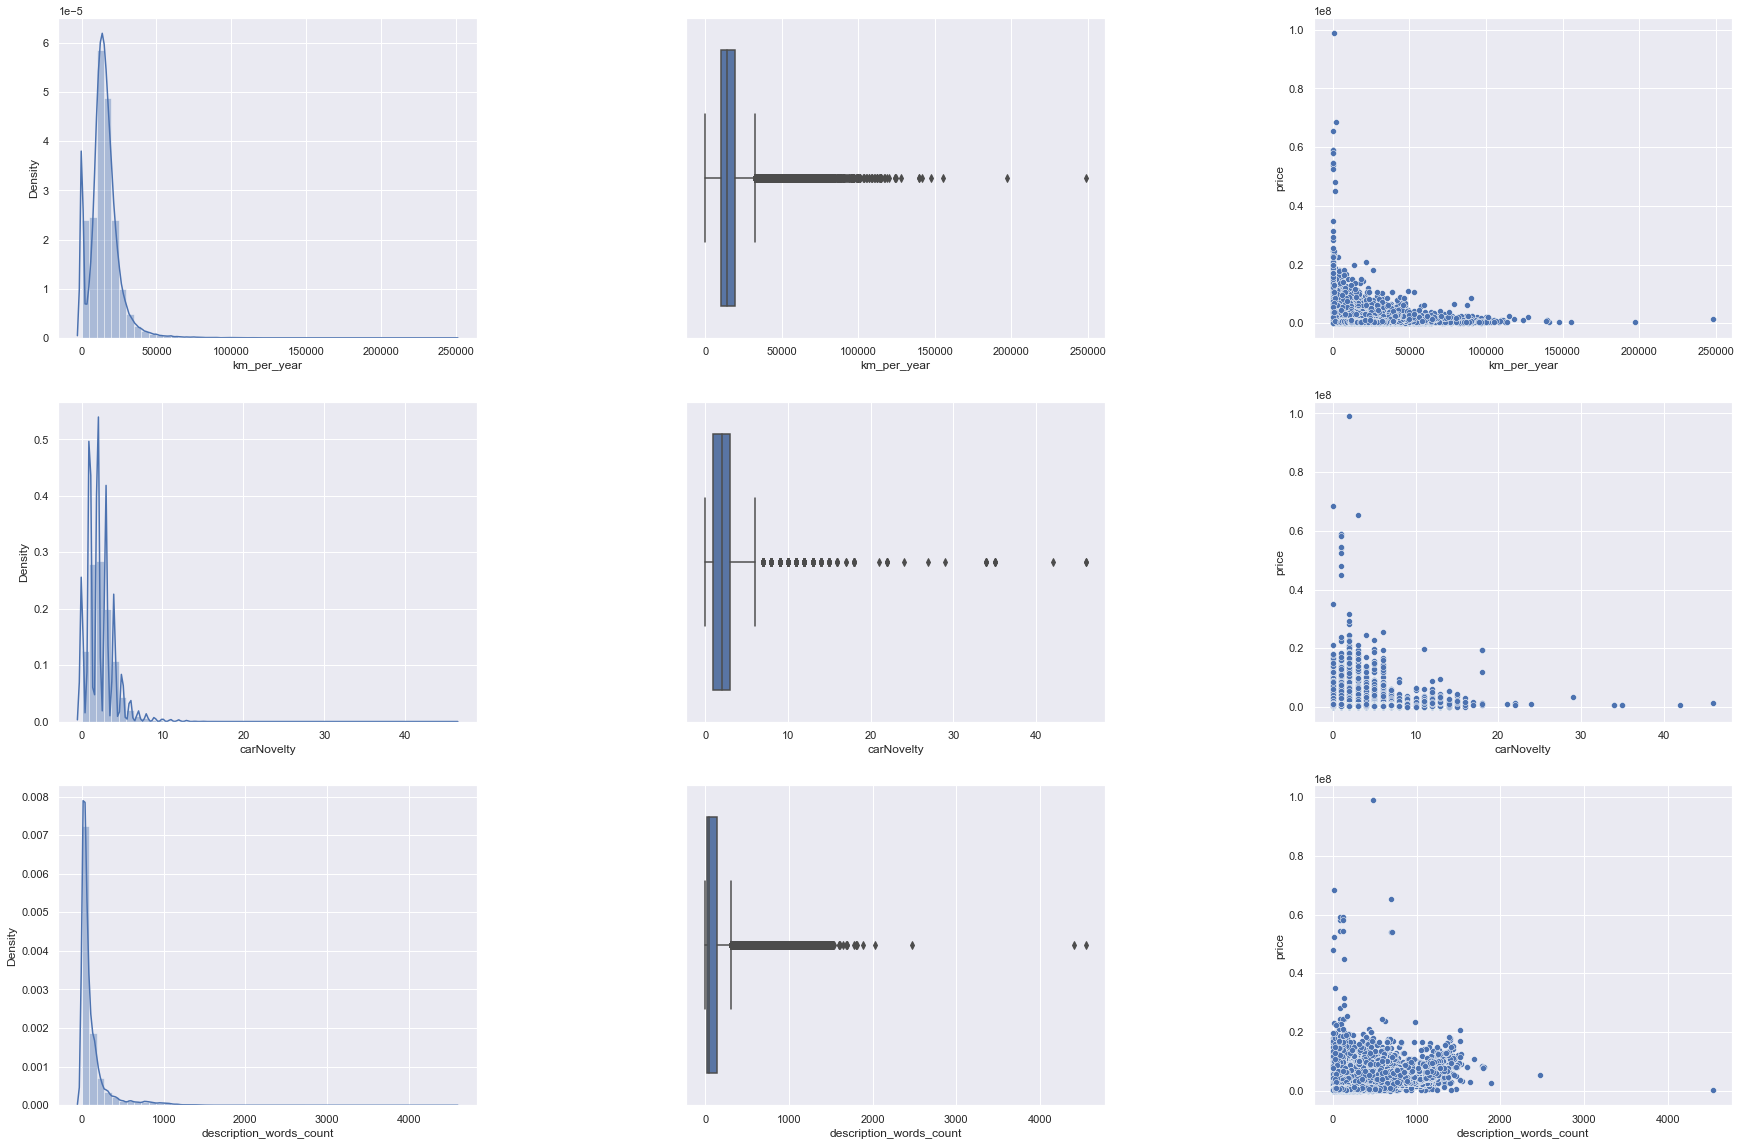

In [172]:
print("Диаграмы распределения новых числовых признаков, взаимосвязь с целевой переменной")

fig, axes = plt.subplots(len(num_cols_new), 3, figsize=(30, 20))
plt.subplots_adjust(wspace=0.5)
axes = axes.flatten()
i = 0

for col in num_cols_new:
    sns.distplot(data[col], ax=axes[i])
    i = i + 1
    sns.boxplot(data[col], ax=axes[i])
    i = i + 1
    sns.scatterplot(data=data[data['train'] == 1],
                    x=col, y="price", ax=axes[i])
    i = i + 1

Графики для переменной  prodDate_3Y


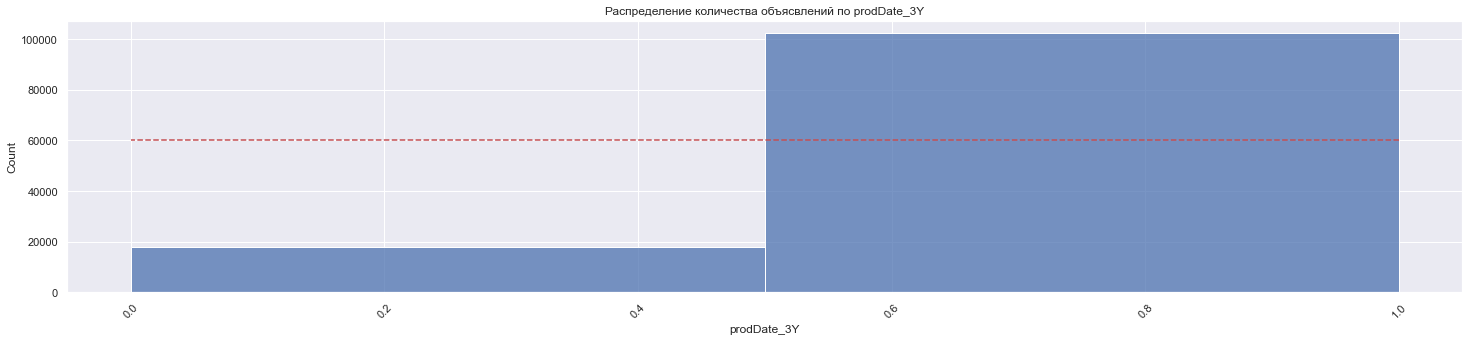

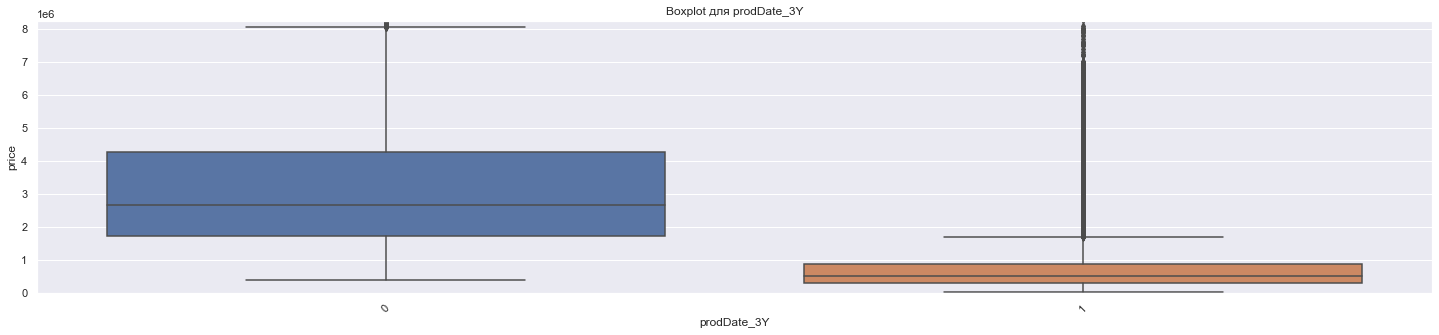



Графики для переменной  prodDate_5Y


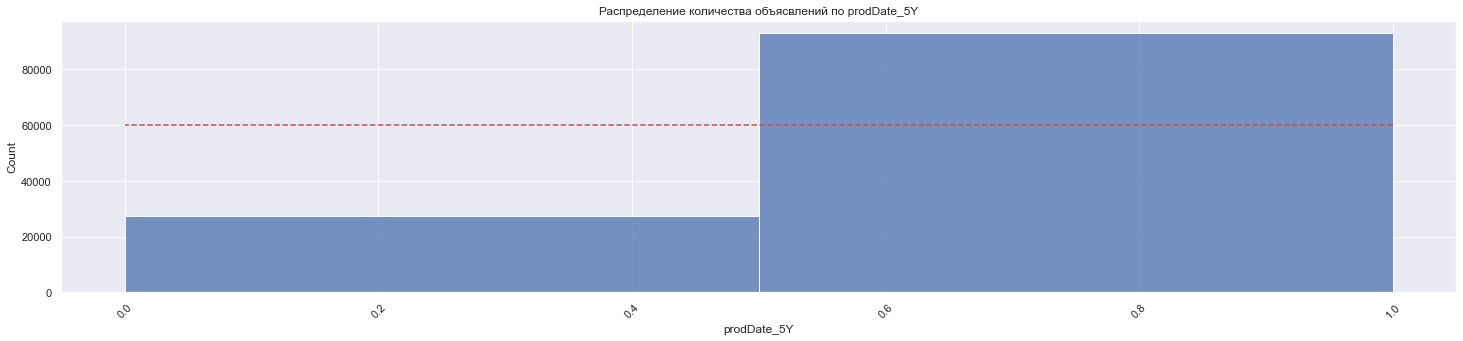

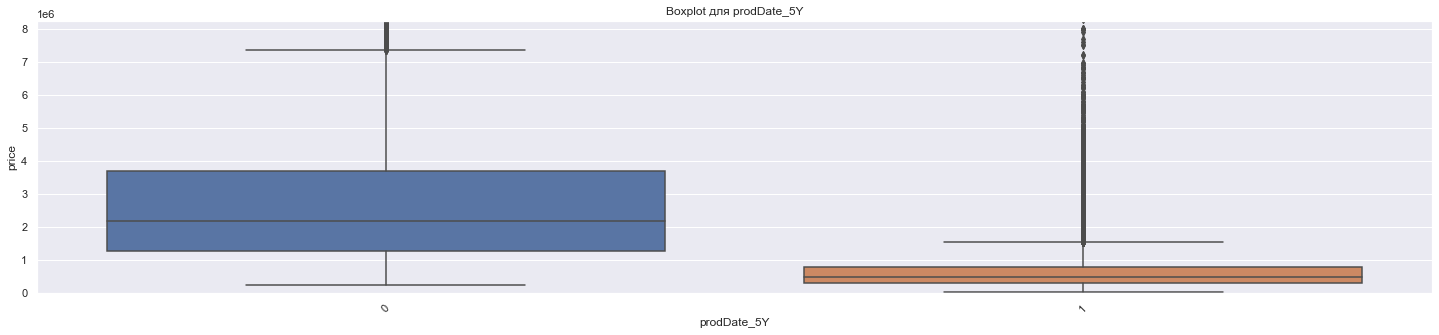



Графики для переменной  brandPopular


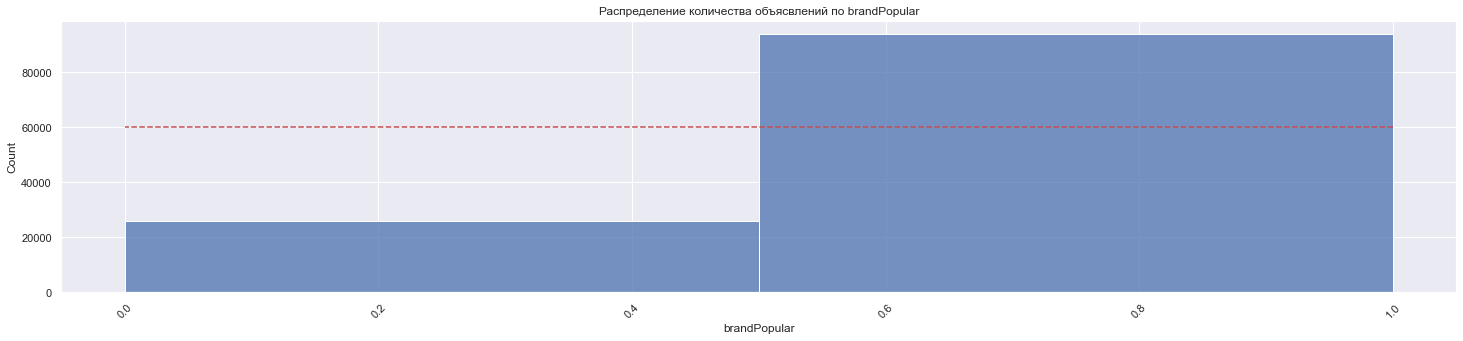

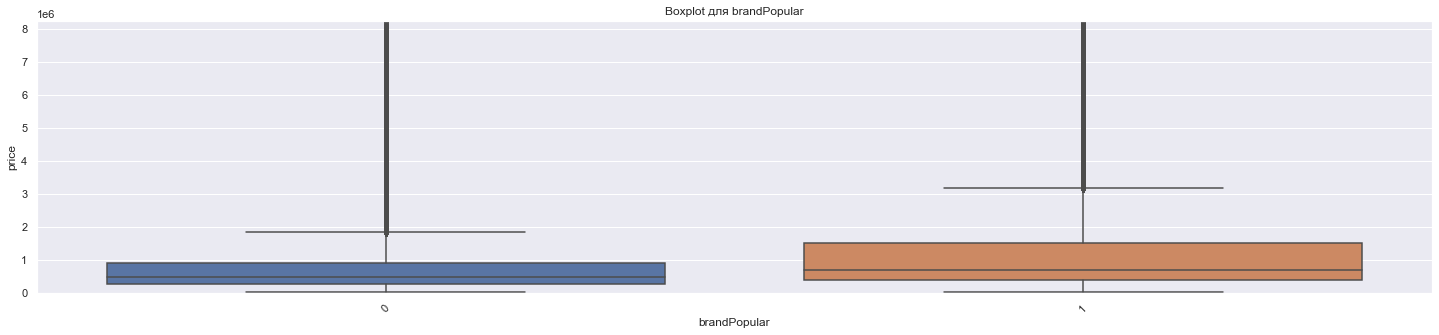



Графики для переменной  modelPopular


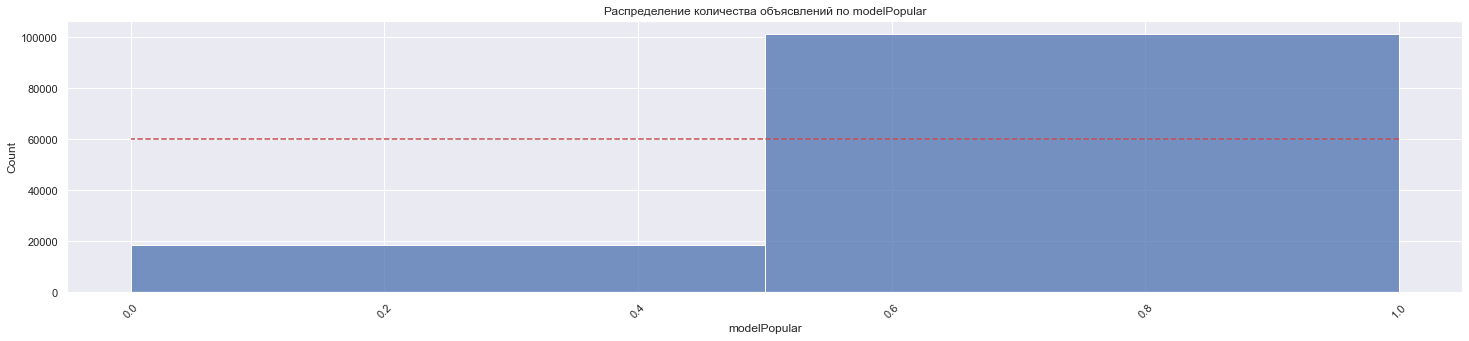

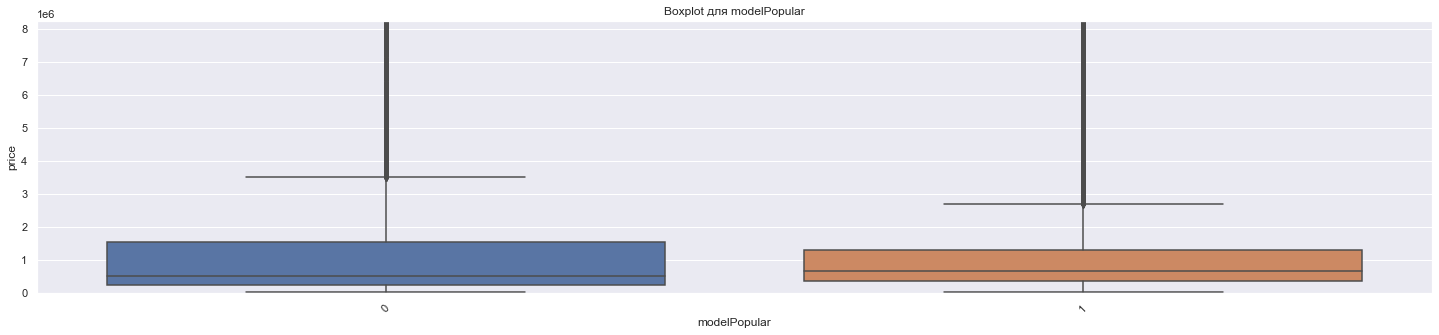



Графики для переменной  colorPopular


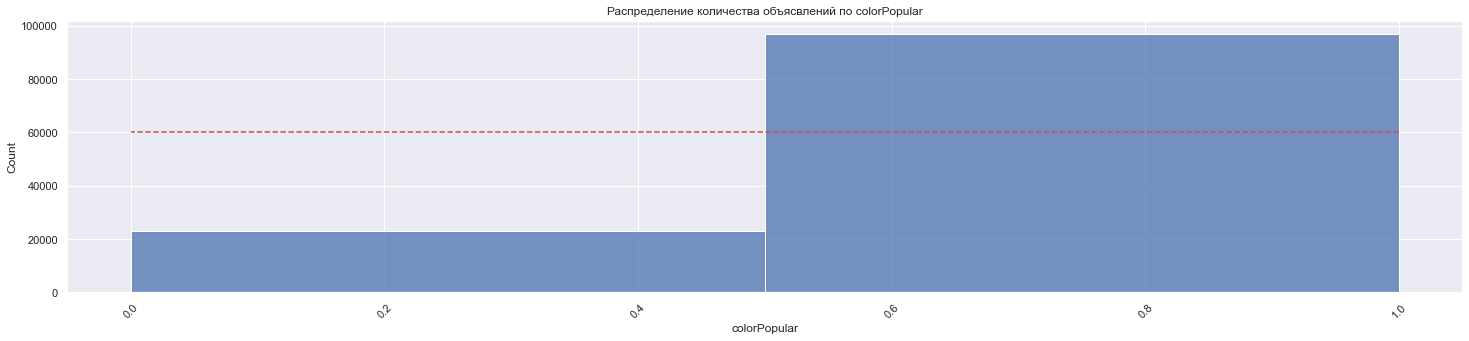

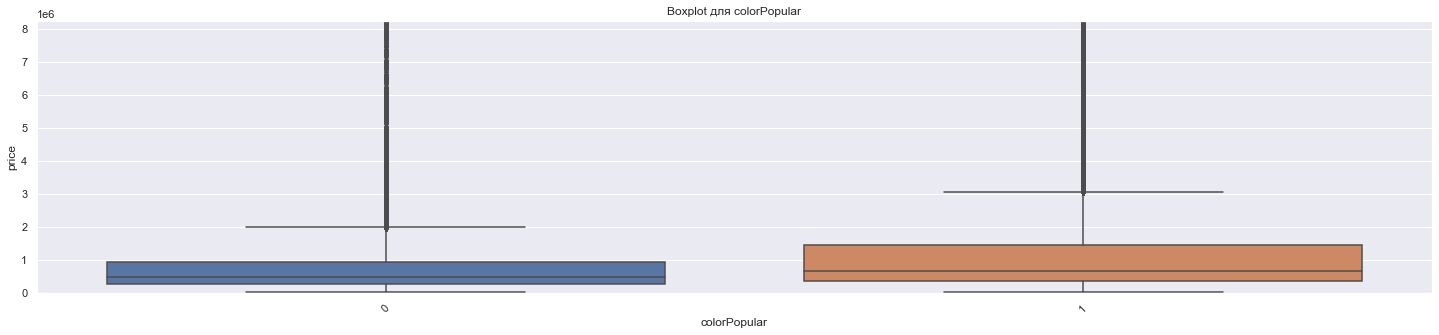

In [173]:
# Посмотрим внимательно на графики еще раз
for col in (bin_cols_new+cat_cols_new):
    print("Графики для переменной ", col)
    analyze_cat_cols(col)
    print("\n")

Выводы:

У числовых признаков опять тяжелый правый хвост. Попробовать работу с выбросами и логарифмирование признаков.
Визуально добавленные признаки статистически значимы и оказывают влияние на формирование цены. Проверим это на этапе отбора признаков.

### Обработка выбросов
Признаки проанализированы, новые фичи созданы. Проведем поиск, анализ и обработку выбросов для числовых и категориальных признаков. Бинарные признаки не смотрим, т.к. мы их анализировали ранее и в них содержатся допустимые значения [0, 1].

In [174]:
# Проанализируем выбросы для категориальных и номинативных признаков
print("Отчет о наличии выбросов в датасете.\n")
for col in (num_cols + target_col):
    print("\nПризнак: ", col)
    iqr_analysis(data[col])
    print("-" * 100)

Отчет о наличии выбросов в датасете.


Признак:  modelDate

25-й перцентиль: 2004.0, 
75-й перцентиль: 2013.0, 
IQR: 9.0,  
Границы выбросов: [1990.5, 2026.5]. 

Минимальное значение признака: 1904. 
Максимальное значение признака: 2020 .

Найдены выбросы по нижней границе признака! Количество: 3061, 2.55%
----------------------------------------------------------------------------------------------------

Признак:  productionDate

25-й перцентиль: 2007.0, 
75-й перцентиль: 2015.0, 
IQR: 8.0,  
Границы выбросов: [1995.0, 2027.0]. 

Минимальное значение признака: 1904. 
Максимальное значение признака: 2020 .

Найдены выбросы по нижней границе признака! Количество: 3614, 3.01%
----------------------------------------------------------------------------------------------------

Признак:  enginePower

25-й перцентиль: 116.0, 
75-й перцентиль: 210.0, 
IQR: 94.0,  
Границы выбросов: [-25.0, 351.0]. 

Минимальное значение признака: 11.0. 
Максимальное значение признака: 800.0 .

Найдены выбро

Оставляем выбросы по признакам modelDate, productionDate, carNovelty. По остальным выбросам проведем анализ и обработку.

Посмотрим детальнее на признаки, где были найдены выбросы. Основная идея: сравнить мин/макс границы по test датасету и удалить лишние данные, если их объем не очень большой.

#### enginePower

In [175]:
# Посмотрим на максимальные значения признака в test
test.enginePower.max()

639.0

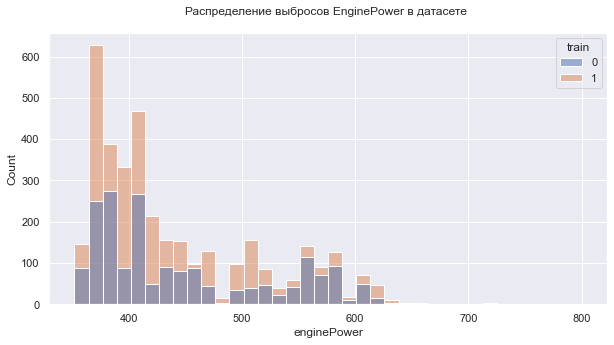

In [176]:
# Посмотрим на распределение выбросов
fig, ax = plt.subplots(figsize=(10, 5))
sns.histplot(data=data[(data.enginePower > 351)], x='enginePower', hue = 'train')
plt.title("Распределение выбросов EnginePower в датасете \n")
plt.show()

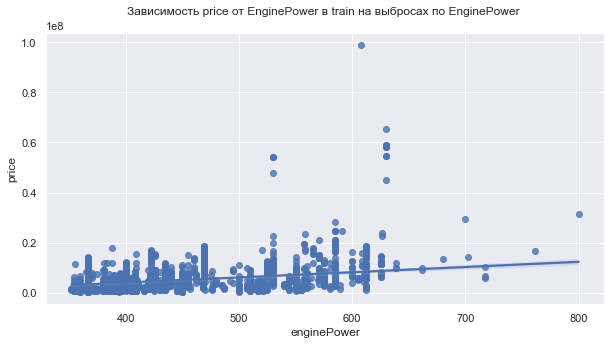

In [177]:
# Посмотрим на распределение выбросов
fig, ax = plt.subplots(figsize=(10, 5))
sns.regplot(data=data[(data.enginePower > 351) & (
    data.train == 1)], x="enginePower", y="price")
plt.title("Зависимость price от EnginePower в train на выбросах по EnginePower \n")
plt.show()

Выбросы по признаку представлены как в train, так и в test части. Удалять строки нельзя, т.к. необходимо строить предсказания по большим значениям enginePower.
Цена варьируется и увеличивается с увеличением мощности двигателя, заменять выбросы на другую величину не стоит.
Можно попробовать логарифмировать переменную.

#### mileage

In [178]:
# Посмотрим на максимальные значения признака в test
test.mileage.max()

1000000

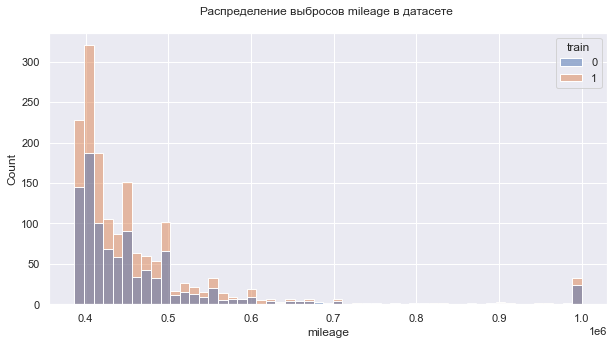

In [179]:
# Посмотрим на распределение выбросов
fig, ax = plt.subplots(figsize=(10, 5))
sns.histplot(data=data[(data.mileage > 386527)], x='mileage', hue = 'train')
plt.title("Распределение выбросов mileage в датасете \n")
plt.show()

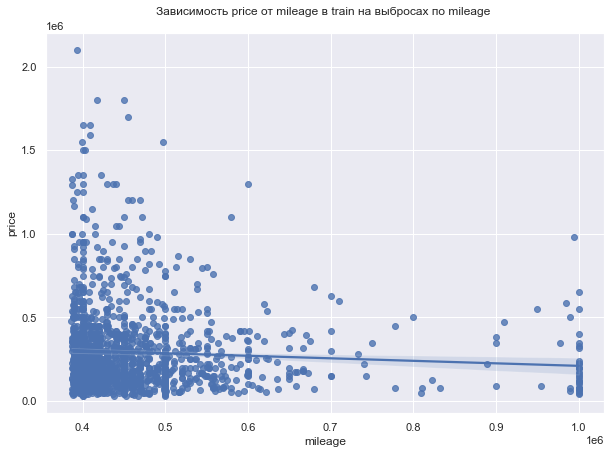

In [180]:
# Посмотрим на распределение выбросов
fig, ax = plt.subplots(figsize=(10, 7))
sns.regplot(data=data[(data.mileage > 386527) & (
    data.train == 1)], x="mileage", y="price")
plt.title("Зависимость price от mileage в train на выбросах по mileage \n")
plt.show()

Выбросы по признаку представлены как в train, так и в test части. Удалять строки нельзя, т.к. необходимо строить предсказания по большим значениям mileage.
Цена варьируется и снижается с увеличением пробега, но есть и увеличение цены на макимальных значениях пробега, заменять выбросы на другую величину не стоит.
Можно попробовать логарифмировать переменную.

#### engineDisplacement

Признак позднее исключается из анализа.

In [181]:
# Посмотрим на максимальные значения признака в test
print("Максимальное значение engineDisplacement  в test:", test.engineDisplacement.max())
# Посмотрим на минимальное значения признака в test
print("Минимальное значение engineDisplacement  в test:", test.engineDisplacement.min())

Максимальное значение engineDisplacement  в test: 6.6
Минимальное значение engineDisplacement  в test: 0.7


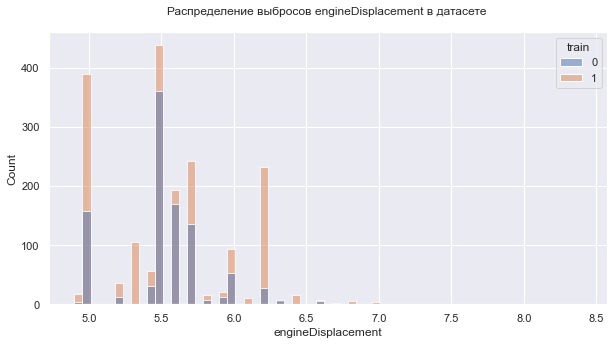

In [182]:
# Посмотрим на распределение выбросов
fig, ax = plt.subplots(figsize=(10, 5))
sns.histplot(data=data[(data.engineDisplacement > 4.8)], x='engineDisplacement', hue = 'train')
plt.title("Распределение выбросов engineDisplacement в датасете \n")
plt.show()

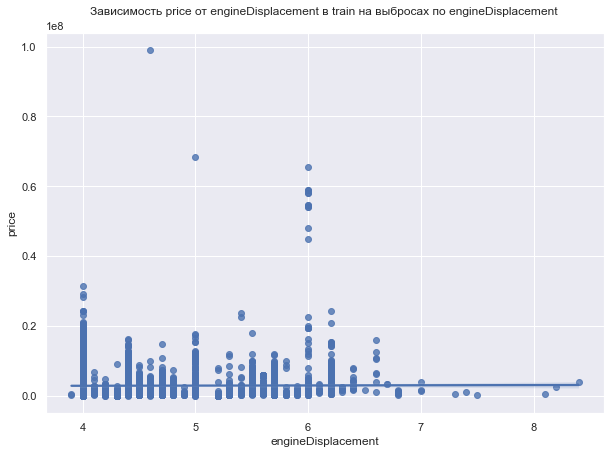

In [183]:
# Посмотрим на распределение выбросов
fig, ax = plt.subplots(figsize=(10, 7))
sns.regplot(data=data[(data.engineDisplacement > 3.8) & (
    data.train == 1)], x="engineDisplacement", y="price")
plt.title("Зависимость price от engineDisplacement в train на выбросах по engineDisplacement \n")
plt.show()

In [184]:
# Посмотрим на записи, которые привышают максимальный порог test
data[(data.engineDisplacement > 6.6)].describe()

,modelDate,numberOfDoors,productionDate,engineDisplacement,enginePower,mileage,driveSide,condition,ownersCount,tcp,...,ownershipTimeMonths,price_log,km_per_year,carNovelty,prodDate_3Y,prodDate_5Y,brandPopular,modelPopular,colorPopular,description_words_count
count,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.0,17.0,17.000000,17.000000,...,10.000000,17.000000,17.000000,17.000000,17.0,17.0,17.000000,17.000000,17.000000,17.000000
mean,1988.941176,3.823529,1992.294118,7.182353,332.764706,140117.588235,0.0,0.0,2.352941,0.823529,...,69.200000,14.109774,6943.640369,3.352941,1.0,1.0,0.705882,0.058824,0.764706,71.352941
std,17.209992,1.286239,17.434752,0.557040,95.387715,130645.475654,0.0,0.0,0.785905,0.392953,...,57.278656,0.812784,6567.466048,2.262222,0.0,0.0,0.469668,0.242536,0.437237,67.295005
min,1956.000000,2.000000,1961.000000,6.700000,215.000000,1000.000000,0.0,0.0,1.000000,0.000000,...,3.000000,12.429216,22.727273,0.000000,1.0,1.0,0.000000,0.000000,0.000000,7.000000
25%,1972.000000,2.000000,1976.000000,6.800000,313.000000,65000.000000,0.0,0.0,2.000000,1.000000,...,23.250000,13.458836,1186.440678,2.000000,1.0,1.0,0.000000,0.000000,1.000000,24.000000
50%,1999.000000,4.000000,1999.000000,7.000000,314.000000,78000.000000,0.0,0.0,3.000000,1.000000,...,59.500000,14.266586,4444.444444,4.000000,1.0,1.0,1.000000,0.000000,1.000000,40.000000
75%,1999.000000,5.000000,2004.000000,7.400000,345.000000,230000.000000,0.0,0.0,3.000000,1.000000,...,108.000000,14.771022,10952.380952,5.000000,1.0,1.0,1.000000,0.000000,1.000000,67.000000
max,2008.000000,5.000000,2013.000000,8.400000,600.000000,403000.000000,0.0,0.0,3.000000,1.000000,...,157.000000,15.226498,18000.000000,7.000000,1.0,1.0,1.000000,1.000000,1.000000,208.000000


Выбросы по признаку представлены как в train, так и в test части. Цена варьируется и увеличивается с увеличением объема двигателя (до определенного значения). Можно попробовать логарифмировать переменную. Также можно попробовать обработать выбросы заменой в строках > 6.6 литров на максимальное значение из теста.

In [185]:
## Заменяем выбросы на максимальное значение признака в тесте
data.engineDisplacement = data.engineDisplacement.apply(lambda x: test.engineDisplacement.max(
) if x > test.engineDisplacement.max() else x)

#### description_words_count

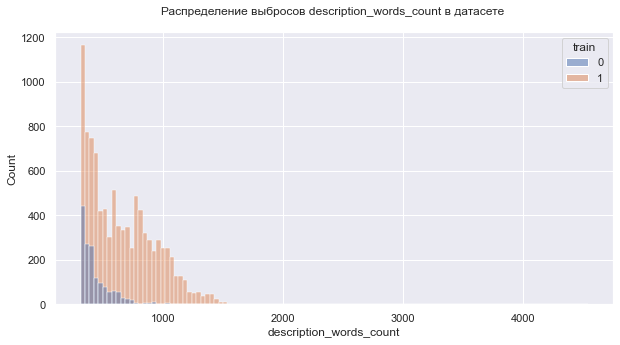

In [186]:
# Посмотрим на распределение выбросов
fig, ax = plt.subplots(figsize=(10, 5))
sns.histplot(data=data[(data.description_words_count > 307)], x='description_words_count', hue = 'train')
plt.title("Распределение выбросов description_words_count в датасете \n")
plt.show()

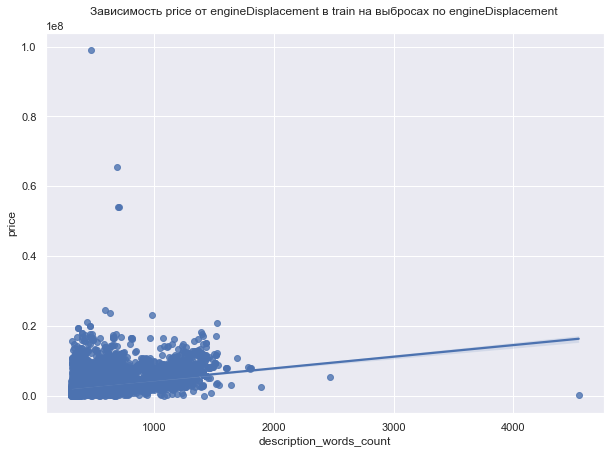

In [187]:
# Посмотрим на распределение выбросов
fig, ax = plt.subplots(figsize=(10, 7))
sns.regplot(data=data[(data.description_words_count > 307) & (
    data.train == 1)], x="description_words_count", y="price")
plt.title("Зависимость price от engineDisplacement в train на выбросах по engineDisplacement \n")
plt.show()

Выбросы по признаку представлены как в train, так и в test части.
Цена варьируется и увеличивается с увеличением признака, поэтому пока оставим без изменений.
Можно попробовать логарифмировать переменную.

#### price

Проанализировать, но вообще log значение выбросы не содержит, а мы его используем в моделях.

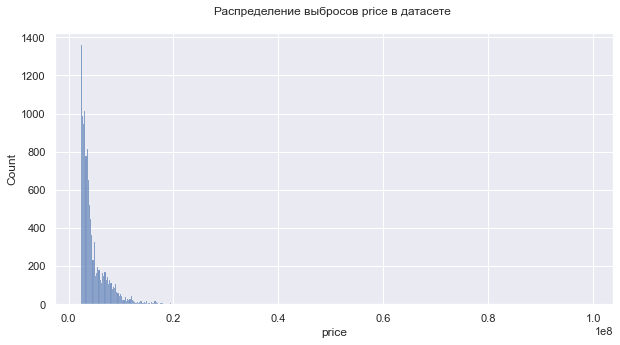

In [188]:
# Посмотрим на распределение выбросов
fig, ax = plt.subplots(figsize=(10, 5))
sns.histplot(data=data[(data.price > 2287500)&(data.train == 1)], x='price')
plt.title("Распределение выбросов price в датасете \n")
plt.show()

In [189]:
data[(data.price > 2287500)&(data.train == 1)].describe(include=object)

,bodyType,brand,color,fuelType,name,vehicleConfiguration,vehicleTransmission,description,drivetrain,ownershipTime,model,vendor
count,11642,11642,11642,11642,11642,11642,11642,11642,11642,11642,11642,11642
unique,15,29,16,4,814,513,4,10308,3,123,281,4
top,внедорожник,MERCEDES,чёрный,бензин,2.0 AT (249 л.с.) 4WD,ALLROAD_5_DOORS AUTOMATIC 2.0,автоматическая,[],полный,no_data,3ER,EUROPEAN
freq,7285,3502,4813,6678,414,494,9341,165,9775,9919,512,9318


In [190]:
# Посмотрим, какие машины имеют особо высокие цены
data[(data.price > 2287500)&(data.train == 1)].groupby(['brand', 'model'])['price'].agg(['count', 'max'])
# Добавим список моделей в список
models_list = data[(data.price > 2287500)&(data.train == 1)].model.values

In [191]:
# Вспомним, сколько авто таких моделей присутствует в тесте
data[(data.model.isin(models_list)) & (data.train == 0)].groupby(
    ['brand', 'model'])['model'].count()

brand  model            
AUDI   A3                   225
       A4                   626
       A4_ALLROAD            31
       A5                   211
       A6                   757
                           ... 
VOLVO  V60_CROSS_COUNTRY      2
       V90_CROSS_COUNTRY      8
       XC40                   8
       XC60                 195
       XC90                 340
Name: model, Length: 177, dtype: int64

Вывод: есть очень дорогие авто, которые представлены и в тестовой выборке.
Удалять строки нельзя, т.к. необходимо строить предсказания по авто таких моделей.

### Логарифмирование числовых признаков

Поскольку многие числовые переменные имеют смещенное распределение влево/вправо попробуем логарифмировать часть признаков.

In [192]:
cols_to_log = ['enginePower', 'mileage', 'engineDisplacement', 'description_words_count']
# Применим логарифмирование ко всем числовым признакам
for col in cols_to_log:
    data[col] = data[col].apply(lambda w: np.log(w+1))

Диаграмы распределения числовых признаков после логарифмирования.


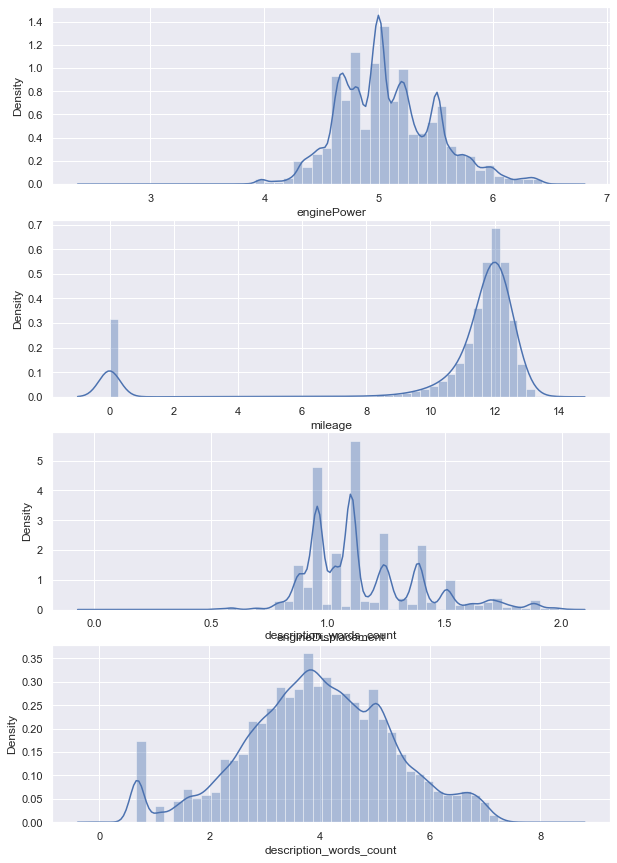

In [193]:
# Посмотрим, как изменилось распределение
print("Диаграмы распределения числовых признаков после логарифмирования.")
fig, axes = plt.subplots(len(cols_to_log), figsize=(10, 15))
axes = axes.flatten()
i = 0

for col in cols_to_log:
    sns.distplot(data[col], ax=axes[i])
    plt.title(col)
    i = i + 1

Вывод: логарифмирование позволило привести признаки к более нормальному распределению. Оставим в таком виде.

### Отбор признаков для моделирования
Корреляционный анализ числовых признаков

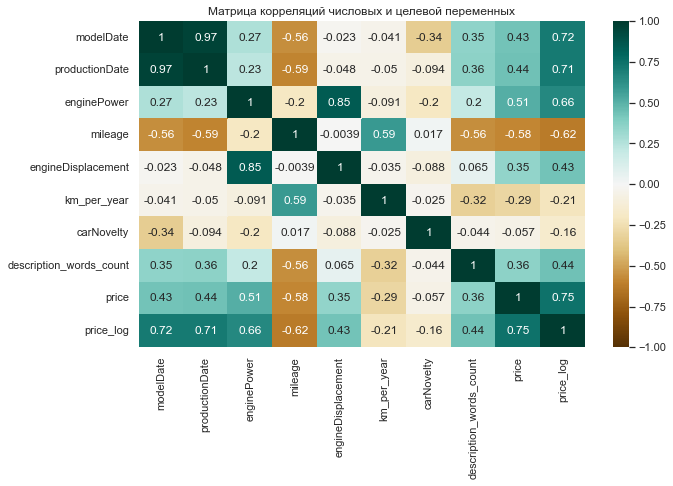

In [194]:
# Построим матрицу корреляций
plt.figure(figsize=(10, 6))
heatmap = sns.heatmap(data[data['train'] == 1][num_cols +
                                               target_col].corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Матрица корреляций числовых и целевой переменных')
plt.show()

Сформируем список признаков, которые коллинеарны. Для этого выставим критерий наличия корреляции больше 0.8 или -0.8.

In [195]:
# Сформируем сет со скоррелированными признаками
correlated_features = set()

# Удаляем целевые и служебные переменные из матрицы корреляций, т.к. корреляция с ней хорошо для модели
correlation_matrix = data[data['train'] == 1][num_cols].corr()

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.8:
            colname = correlation_matrix.columns[j]
            correlated_features.add(colname)

print('Список скоррелированных признаков на удаление из обучения модели:',
      correlated_features)

Список скоррелированных признаков на удаление из обучения модели: {'enginePower', 'modelDate'}


Вывод: найдены сильно скоррелированные признаки, но мы это уже видели во время анализа ранее и добавили признаки в список на исключение.

#### Удаление признаков перед моделированием

In [196]:
# Удаляем признаки из датасета, которые решили удалить по ходу анализа
data.drop(cols_removal, axis=1, inplace=True)

In [197]:
# Смотрим, какие признаки остались
print("После обработки остались следующие признаки:", data.columns)

После обработки остались следующие признаки: Index(['bodyType', 'brand', 'color', 'fuelType', 'numberOfDoors',
       'productionDate', 'vehicleTransmission', 'enginePower', 'mileage',
       'drivetrain', 'driveSide', 'ownersCount', 'tcp', 'price', 'model',
       'vendor', 'train', 'sell_id', 'transmission', 'price_log',
       'km_per_year', 'carNovelty', 'prodDate_3Y', 'prodDate_5Y',
       'brandPopular', 'modelPopular', 'colorPopular',
       'description_words_count'],
      dtype='object')


#### Кодирование категориальных признаков

Основная логика выбора способа кодирования:

если у признака есть какая-то зависимость от порядкового номера категории или какая-то количественно выраженная разница между категориями, то используем label encoding.
если такого свойства нет и в списке большое количество значений, то пробуем one-hot-encoding.
После проведения экспериментов было решено применить label encoding ко всем категориальным признакам, т.к. даже после удаления статистически незначимых признаков, результаты были хуже.

#### Label Encoding

In [198]:
# Labels encoding for all
cols_to_encode = list(set(data.columns) & set(cat_cols))
for colum in cols_to_encode:
    data[colum] = data[colum].astype('category').cat.codes

#### Поиск статистически значимых различий с помощью теста Стьюдента

Проверим, есть ли статистическая разница в распределении цен по категориальным и бинарным признакам, с помощью теста Стьюдента. Проверим нулевую гипотезу о том, что распределения цен по различным параметрам неразличимы.

In [199]:
# Создадим список с колонками, которые удалим из данных ввиду их статистической незначимости
cat_cols_remove = []

# Проходим по колонкам, которые исключали из корреляционного анализа
for column in (list(set(data.columns).difference(num_cols+service_cols+target_col))):
    cat_cols_remove.append(get_stat_dif(column))

Не найдены статистически значимые различия для колонки и комбинации color (15, 8)
Не найдены статистически значимые различия для колонки и комбинации fuelType (0, 1)
Не найдены статистически значимые различия для колонки и комбинации bodyType (10, 5)
Не найдены статистически значимые различия для колонки и комбинации brand (21, 27)
Не найдены статистически значимые различия для колонки и комбинации model (684, 712)
Не найдены статистически значимые различия для колонки и комбинации numberOfDoors (4, 0)


Вывод: присутсвуют признаки, для которых, не все значения категорий влияют на целевую переменную, такие признаки можно было бы удалить, если бы использовали one hot encoding, пока оставляем.

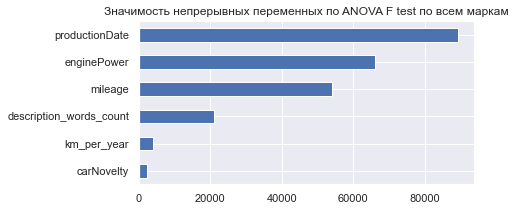

In [200]:
#Оценим значимость числовых признаков
fig, ax = plt.subplots(figsize=(6, 3))
anova_df = data[data['train'] == 1].dropna().copy()
imp_num = pd.Series(f_regression(anova_df[list(set(data.columns) & set(num_cols))], anova_df['price_log'])[
                    0], index=list(set(data.columns) & set(num_cols)))
imp_num.sort_values(inplace=True)
imp_num.plot(
    kind='barh', title='Значимость непрерывных переменных по ANOVA F test по всем маркам')
plt.show()

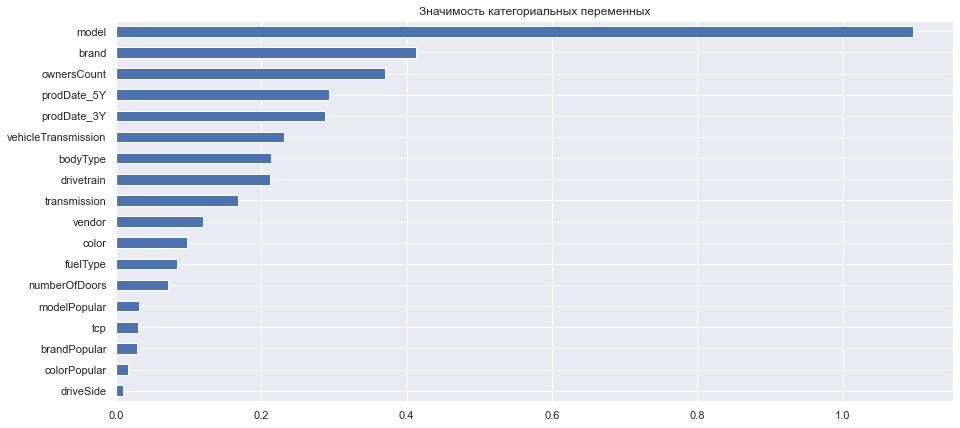

In [201]:
# Оценим значимость бинарных и категориальных признаков
fig, ax = plt.subplots(figsize=(15, 7))

anova_df = data[data['train'] == 1].dropna().copy()

# Labels encoding
cols_to_encode = list(set(anova_df.columns) & set(cat_cols))
for colum in cols_to_encode:
    anova_df[colum] = anova_df[colum].astype('category').cat.codes

imp_cat = pd.Series(mutual_info_regression(
    anova_df[list(set(data.columns) & set(bin_cols+cat_cols))], anova_df['price'], discrete_features=True), index=list(set(data.columns) & set(bin_cols+cat_cols)))
imp_cat.sort_values(inplace=True)
imp_cat.plot(kind='barh', title='Значимость категориальных переменных')
plt.show()

Выводы:

Из числовых признаков очень сильное влияние имеет productionDate, mileage, enginePower.
Из категориальных и бинарных самое сильное влияние оказывает model, brand, ownersCount.

### Стандартизация числовых признаков

In [202]:
## Стандартизация числовых переменных
cols_to_scale = list(set(data.columns) & set(num_cols))
data[cols_to_scale] = StandardScaler().fit_transform(data[cols_to_scale].values)

In [203]:
# Выделим тестовую и тренировочную части
X = data.query('train == 1').drop(
    ['train', 'price', 'price_log'], axis=1)
X_sub = data.query('train == 0').drop(
    ['train', 'price', 'price_log'], axis=1)

In [204]:
# В качестве y указываем цену
y = data[data.train == 1]['price']

In [205]:
#### Train Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=VAL_SIZE, shuffle=True, random_state=RANDOM_SEED)

### Создадим "наивную" модель
Эта модель будет предсказывать среднюю цену по модели двигателя (mileage). C ней будем сравнивать другие модели.

In [206]:
tmp_train = X_train.copy()
tmp_train['price'] = y_train

In [207]:
# Находим median по экземплярам mileage в train и размечаем test
predict = X_test['mileage'].map(
    tmp_train.groupby('mileage')['price'].median())

# оцениваем точность
print(
    f"Точность наивной модели по метрике MAPE: {(mape(y_test, predict.values))*100:0.2f}%")

Точность наивной модели по метрике MAPE: 73.61%


### Простая модель линейной регрессии

In [208]:
from sklearn.linear_model import LinearRegression
linear_regr = LinearRegression().fit(X_train, np.log(y_train+1))
predict_test = np.exp(linear_regr.predict(X_test))
print(f"Точность модели по метрике MAPE: {(mape(y_test, predict_test))*100:0.2f}%")

Точность модели по метрике MAPE: 26.45%


### CatBoost

In [209]:
# model = CatBoostRegressor(iterations = 5000,
#                           random_seed = RANDOM_SEED,
#                           eval_metric='MAPE',
#                           custom_metric=['R2', 'MAE'],
#                           silent=True,
#                          )
# model.fit(X_train, y_train,
#          #cat_features=cat_features_ids,
#          eval_set=(X_test, y_test),
#          verbose_eval=0,
#          use_best_model=True,
#          #plot=True
#          )

# model.save_model('catboost_single_model_baseline.model')

In [210]:
# # оцениваем точность
# predict = model.predict(X_test)
# print(f"Точность модели по метрике MAPE: {(mape(y_test, predict))*100:0.2f}%")

# # Точность модели по метрике MAPE: 15.03%

In [211]:
# # Log Target
# # Попробуем взять таргет в логорифм - это позволит уменьшить влияние выбросов на обучение модели.
# model = CatBoostRegressor(iterations=5000,
#                           random_seed=RANDOM_SEED,
#                           eval_metric='MAPE',
#                           custom_metric=['R2', 'MAE'],
#                           silent=True,
#                           )
# model.fit(X_train, np.log(y_train),
#           # cat_features=cat_features_ids,
#           eval_set=(X_test, np.log(y_test)),
#           verbose_eval=0,
#           use_best_model=True,
#           # plot=True
#           )

# model.save_model('catboost_single_model_2_baseline.model')

# predict_test = np.exp(model.predict(X_test))
# predict_submission = np.exp(model.predict(X_sub))

# print(
#     f"Точность модели по метрике MAPE: {(mape(y_test, predict_test))*100:0.2f}%")

# # Точность модели по метрике MAPE: 12.36%

### xgboost

In [212]:
xb = xgb.XGBRegressor(objective='reg:squarederror', colsample_bytree=0.5, learning_rate=0.03, \
                      max_depth=12, alpha=1, n_jobs=-1, n_estimators=1000)
xb.fit(X_train, np.log(y_train+1))

predict_test = np.exp(xb.predict(X_test))
predict_submission = np.exp(xb.predict(X_sub))

print(
      f"Точность модели по метрике MAPE: {(mape(y_test, predict_test))*100:0.2f}%")

# Точность модели по метрике MAPE: 12.01%

Точность модели по метрике MAPE: 12.09%


### GradientBoosting с подбором параметров

In [213]:
# regularise(X_train, y_train)

In [214]:
# gb = GradientBoostingRegressor(min_samples_split=2, learning_rate=0.03, max_depth=5, n_estimators=1000)
# gb.fit(X_train, np.log(y_train+1))

# predict_test = np.exp(gb.predict(X_test))
# predict_submission = np.exp(gb.predict(X_sub))

# print(
#       f"Точность модели по метрике MAPE: {(mape(y_test, predict_test))*100:0.2f}%")

# # Точность модели по метрике MAPE: 13.91%

### Stacking

In [215]:
# scaler = StandardScaler() 
# X_train = scaler.fit_transform(X_train) 
# X_test = scaler.transform(X_test) 

# y_train = y_train 
# y_test = y_test

# cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)

# X_train = np.where(np.isnan(X_train), 0, X_train)
# X_test = np.where(np.isnan(X_test), 0, X_test)
# y_train = np.where(np.isnan(y_train), 0, y_train)

In [216]:
# regr = RandomForestRegressor(n_estimators=300, min_samples_split=2, min_samples_leaf=1, 
#                              max_features=3, max_depth=19, bootstrap=True, random_state=RANDOM_SEED)

# stacked_features_train, stacked_features_test = generate_meta_features([
#                             regr,
#                             GradientBoostingRegressor(min_samples_split=2, learning_rate=0.03, max_depth=10, n_estimators=300),
#                             KNeighborsRegressor(n_neighbors=2, algorithm = 'ball_tree', weights = 'distance', p=1),
#                             RandomForestRegressor(random_state = RANDOM_SEED, n_jobs = -1, verbose = 1, max_depth=5, n_estimators=200),
#                             ExtraTreesRegressor(random_state=RANDOM_SEED), 
#                             RandomForestRegressor(random_state=RANDOM_SEED, max_depth=15) \
# ], X_train, X_test, y_train, cv)

In [217]:
# egr.fit(X_train, y_train)

# predict_test = regr.predict(X_test)
# predict_submission = regr.predict(X_sub)

# print(
#       f"Точность модели по метрике MAPE: {(mape(y_test, predict_test))*100:0.2f}%")

# # Точность модели по метрике MAPE: 13.86%

### Выводы
CatBoost и GradientBoosting показывают хороший результат метрики, но лучший результат показал xgboost: MAPE 12.01.
Заметно улучшается результат после логарифмирования целевой переменной.

### SUBMISSION

In [218]:
# Для финального сабмишена выбран np.exp(xb.predict(X_sub))
predict_submission = np.exp(xb.predict(X_sub))

sample_submission['price'] = np.round(np.array(predict_submission)/1000,2)*1000
sample_submission.to_csv(f'submission_v{VERSION}.csv', index=False)
sample_submission.head(10)

,sell_id,price
0,1100575026,609670.0
1,1100549428,904200.0
2,1100658222,883210.0
3,1100937408,699890.0
4,1101037972,718620.0
5,1100912634,766800.0
6,1101228730,608730.0
7,1100165896,395240.0
8,1100768262,1658540.0
9,1101218501,824820.0
